# **Imports**

In [1]:
import pickle
import numpy as np
import random
import glob
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
from torchvision.models import resnet18
from torchvision import transforms, models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import entropy
from getData import *
from trainer import *
from getModel import *
import torchprofile

import time
# Seed for reproducibility
SEED = 25
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
def save_for_plot(data, name):
    e = np.asarray(data)
    with open("./Results/"+ name + ".csv", "w") as fe:
        np.savetxt(fe, e, delimiter=",")

# **Data**

In [3]:
dataHandler = getData(0.1)

Training:  (340200, 2, 128) (340200, 2)
Validation:  (37800, 2, 128) (37800, 2)
Testing:  (42000, 2, 128) (42000, 2)


In [4]:
trainLoader, valLoader, testLoader = dataHandler.get_loaders()

# **Baseline Model**

In [10]:
NUM_EPOCHS = 50

In [11]:
bl_initialWeights = "./models/intialized_bl_0420.pth"
blNet = blModel().to(device)
blNet.load_state_dict(torch.load(bl_initialWeights))
optimizer_bl = optim.Adam(blNet.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer_bl, 50, verbose=True)
scheduler = None
criterion_bl = nn.CrossEntropyLoss()

Adjusting learning rate of group 0 to 1.0000e-04.


In [12]:
bl_titleToday = "./models/best_bl_0502.pth"
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
#blNet, blHistory = BL.train(trainLoader, valLoader)
#blNet.load_state_dict(torch.load("./models/best_bl_0426.pth"))
blNet.load_state_dict(torch.load(bl_titleToday))

<All keys matched successfully>

# **EE Model**

In [28]:
eeV0_initialWeights = "./models/intialized_eeV0_0424_after.pth"
eeV1_initialWeights = "./models/intialized_eeV1_0424_after.pth"
eeV2_initialWeights = "./models/intialized_eeV4_0501_after.pth"
eeV3_initialWeights = "./models/intialized_eeV3_0504"

## Training V0

In [14]:
V0_titleToday = "./models/Final/best_eeV0.pth"
eeNet_V0 = eeModel_V0().to(device)
eeNet_V0.load_state_dict(torch.load(eeV0_initialWeights))

optimizer_ee_V0 = optim.Adam(eeNet_V0.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_V0 = CosineAnnealingLR(optimizer_ee_V0, 50, verbose=True)
scheduler_V0 = None
criterion_ee_V0 = nn.CrossEntropyLoss()

EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)
eeNet_V0, eeHistory_V0 = EE_V0.train(trainLoader, valLoader)
eeNet_V0.load_state_dict(torch.load(V0_titleToday))

Number of base parameters: 576
Number of short branch parameters: 68010
Number of long branch parameters: 118842
Difference = 50832
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.608, trainAcc: 0.376, validLoss: 1.598, validAcc: 0.378
Model Saved!
epoch 2 --> trainLoss: 1.520, trainAcc: 0.408, validLoss: 1.586, validAcc: 0.390
Model Saved!
epoch 3 --> trainLoss: 1.471, trainAcc: 0.425, validLoss: 1.458, validAcc: 0.431
Model Saved!
epoch 4 --> trainLoss: 1.445, trainAcc: 0.434, validLoss: 1.451, validAcc: 0.433
Model Saved!
epoch 5 --> trainLoss: 1.425, trainAcc: 0.442, validLoss: 1.407, validAcc: 0.451
Model Saved!
epoch 6 --> trainLoss: 1.407, trainAcc: 0.449, validLoss: 1.389, validAcc: 0.453
Model Saved!
epoch 7 --> trainLoss: 1.391, trainAcc: 0.455, validLoss: 1.359, validAcc: 0.469
Model Saved!
epoch 8 --> trainLoss: 1.374, trainAcc: 0.460, validLoss: 1.351, validAcc: 0.469
Model Saved!
epoch 9 --> trainLoss: 1.357, trainAcc: 0.467, validLoss: 1.321, v

<All keys matched successfully>

In [15]:
eeRecorder_V0, preds_V0, acc_V0 = EE_V0.infer(valLoader, threshold=0.05, verbose=False)
EE_V0.testingSummary(eeRecorder_V0, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 100.00% with 1.42% of the samples
Branch 2: Accuracy 62.32% with 98.58% of the samples
Overall Weighted Accuracy: 62.86%


## Training V1

In [16]:
V1_titleToday = "./models/Final/eeV1.pth"
eeNet_V1 = eeModel_V1().to(device)
eeNet_V1.load_state_dict(torch.load(eeV1_initialWeights))

optimizer_ee_V1 = optim.Adam(eeNet_V1.parameters(), lr=0.0001, weight_decay=5e-4)
criterion_ee_V1 = nn.CrossEntropyLoss()
scheduler_V1 = CosineAnnealingLR(optimizer_ee_V1, 50, verbose=True)
scheduler_V1 = None

EE_V1 = eeHandler(eeNet_V1, criterion_ee_V1, optimizer_ee_V1, device, scheduler=scheduler_V1, num_epochs=NUM_EPOCHS, bestPath=V1_titleToday)
eeNet_V1, eeHistory_V1 = EE_V1.train(trainLoader, valLoader)
eeNet_V1.load_state_dict(torch.load(V1_titleToday))

Number of base parameters: 13056
Number of short branch parameters: 68010
Number of long branch parameters: 106362
Difference = 38352
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.388, trainAcc: 0.457, validLoss: 1.784, validAcc: 0.405
Model Saved!
epoch 2 --> trainLoss: 1.255, trainAcc: 0.506, validLoss: 1.330, validAcc: 0.502
Model Saved!
epoch 3 --> trainLoss: 1.193, trainAcc: 0.531, validLoss: 1.238, validAcc: 0.532
Model Saved!
epoch 4 --> trainLoss: 1.161, trainAcc: 0.544, validLoss: 1.240, validAcc: 0.532
epoch 5 --> trainLoss: 1.142, trainAcc: 0.551, validLoss: 1.140, validAcc: 0.557
Model Saved!
epoch 6 --> trainLoss: 1.128, trainAcc: 0.557, validLoss: 1.114, validAcc: 0.565
Model Saved!
epoch 7 --> trainLoss: 1.115, trainAcc: 0.562, validLoss: 1.107, validAcc: 0.564
Model Saved!
epoch 8 --> trainLoss: 1.106, trainAcc: 0.565, validLoss: 1.085, validAcc: 0.566
Model Saved!
epoch 9 --> trainLoss: 1.098, trainAcc: 0.568, validLoss: 1.065, validAcc: 0.

<All keys matched successfully>

In [17]:
eeRecorder_V1, preds_V1, acc_V1 = EE_V1.infer(valLoader, threshold=0.05, verbose=False)
EE_V1.testingSummary(eeRecorder_V1, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.99% with 20.82% of the samples
Branch 2: Accuracy 52.51% with 79.18% of the samples
Overall Weighted Accuracy: 62.40%


## Training V2

In [22]:
V2_titleToday = "./models/Final/eeV2.pth"

eeNet_V2 = eeModel_V2().to(device)
eeNet_V2.load_state_dict(torch.load(eeV2_initialWeights))

optimizer_ee_V2 = optim.Adam(eeNet_V2.parameters(), lr=0.0001, weight_decay=5e-4)
criterion_ee_V2 = nn.CrossEntropyLoss()
scheduler_V2 = CosineAnnealingLR(optimizer_ee_V2, 50, verbose=True)
scheduler_V2 = None

EE_V2 = eeHandler(eeNet_V2, criterion_ee_V2, optimizer_ee_V2, device, scheduler=scheduler_V2, num_epochs=NUM_EPOCHS, bestPath=V2_titleToday)
eeNet_V2, eeHistory_V2 = EE_V2.train(trainLoader, valLoader)
eeNet_V2.load_state_dict(torch.load(V2_titleToday))

Number of base parameters: 25536
Number of short branch parameters: 68010
Number of long branch parameters: 93882
Difference = 25872
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.289, trainAcc: 0.488, validLoss: 1.216, validAcc: 0.520
Model Saved!
epoch 2 --> trainLoss: 1.158, trainAcc: 0.533, validLoss: 1.116, validAcc: 0.547
Model Saved!
epoch 3 --> trainLoss: 1.106, trainAcc: 0.550, validLoss: 1.069, validAcc: 0.565
Model Saved!
epoch 4 --> trainLoss: 1.080, trainAcc: 0.559, validLoss: 1.040, validAcc: 0.571
Model Saved!
epoch 5 --> trainLoss: 1.061, trainAcc: 0.566, validLoss: 1.032, validAcc: 0.573
Model Saved!
epoch 6 --> trainLoss: 1.049, trainAcc: 0.571, validLoss: 1.023, validAcc: 0.579
Model Saved!
epoch 7 --> trainLoss: 1.038, trainAcc: 0.575, validLoss: 1.023, validAcc: 0.577
epoch 8 --> trainLoss: 1.030, trainAcc: 0.577, validLoss: 1.007, validAcc: 0.581
Model Saved!
epoch 9 --> trainLoss: 1.023, trainAcc: 0.580, validLoss: 1.009, validAcc: 0.5

<All keys matched successfully>

In [23]:
eeRecorder_V2, preds_V2, acc_V2 = EE_V2.infer(valLoader, threshold=0.05, verbose=False)
EE_V2.testingSummary(eeRecorder_V2, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.93% with 25.61% of the samples
Branch 2: Accuracy 47.88% with 74.39% of the samples
Overall Weighted Accuracy: 61.21%


# Training V3

In [29]:
V3_titleToday = "./models/Final/eeV3.pth"
eeNet_V3 = eeModel_V3().to(device)
eeNet_V3.load_state_dict(torch.load(eeV3_initialWeights))

optimizer_ee_V3 = optim.Adam(eeNet_V3.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_V3 = CosineAnnealingLR(optimizer_ee_V3, 50, verbose=True)
scheduler_V3 = None
criterion_ee_V3 = nn.CrossEntropyLoss()

EE_V3 = eeHandler(eeNet_V3, criterion_ee_V3, optimizer_ee_V3, device, scheduler=scheduler_V3, num_epochs=NUM_EPOCHS, bestPath=V3_titleToday)
eeNet_V3, eeHistory_V3 = EE_V3.train(trainLoader, valLoader)
eeNet_V3.load_state_dict(torch.load(V3_titleToday))

Number of base parameters: 34944
Number of short branch parameters: 68010
Number of long branch parameters: 84474
Difference = 16464
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.291, trainAcc: 0.469, validLoss: 1.174, validAcc: 0.530
Model Saved!
epoch 2 --> trainLoss: 1.114, trainAcc: 0.547, validLoss: 1.114, validAcc: 0.550
Model Saved!
epoch 3 --> trainLoss: 1.063, trainAcc: 0.563, validLoss: 1.078, validAcc: 0.563
Model Saved!
epoch 4 --> trainLoss: 1.040, trainAcc: 0.572, validLoss: 1.025, validAcc: 0.580
Model Saved!
epoch 5 --> trainLoss: 1.025, trainAcc: 0.579, validLoss: 1.013, validAcc: 0.581
Model Saved!
epoch 6 --> trainLoss: 1.014, trainAcc: 0.582, validLoss: 0.993, validAcc: 0.589
Model Saved!
epoch 7 --> trainLoss: 1.004, trainAcc: 0.586, validLoss: 0.982, validAcc: 0.595
Model Saved!
epoch 8 --> trainLoss: 0.997, trainAcc: 0.588, validLoss: 0.981, validAcc: 0.594
Model Saved!
epoch 9 --> trainLoss: 0.990, trainAcc: 0.592, validLoss: 0.977, 

<All keys matched successfully>

In [30]:
eeRecorder_V3, preds_V3, acc_V3 = EE_V3.infer(valLoader, threshold=0.05, verbose=False)
EE_V3.testingSummary(eeRecorder_V3, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.82% with 32.10% of the samples
Branch 2: Accuracy 45.77% with 67.90% of the samples
Overall Weighted Accuracy: 63.12%


# SNR

# 1 ST

In [34]:
snrs = dataHandler.get_snrs()
trainXs, valXs, testXs = dataHandler.get_Xs()
trainLabels, valLabels, testLabels = dataHandler.get_labels()
label_dict = dataHandler.get_label_dict()

stringSNRs = ['{}'.format(x) for x in snrs]
thresholds = [0.01, 0.05, 0.15, 0.3, 0.4, 0.6]
nBranches = 2

accuracies = {typ: {thre:{y: 0 for y in stringSNRs} for thre in thresholds} for typ in ["Baseline", "V0", "V1", "V2", "V3"]}
inferenceCounter = {y: {thre: {x: {snr: 0 for snr in stringSNRs} for x in range(nBranches)} for thre in thresholds} for y in ["V0", "V1", "V2", "V3"]}

In [35]:
# Getting TRAIN data with differebt SNRs values in dB
for snr in stringSNRs:
    
    tmpData = np.array([valXs[i] for i in range(len(valLabels)) if valLabels[i][1]==snr])
    tmpLabels = np.array([valLabels[i][0] for i in range(len(valLabels)) if valLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    

    bl_Acc = 0
    
    with torch.no_grad():
            blNet.eval()
            for data, labels in tmpLoader:
                data, labels = data.to(device), labels.to(device)
                # Long
                outputs = blNet(data)
                _, preds = torch.max(outputs, 1)
                bl_Acc += accuracy_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())     
                
            bl_Acc = bl_Acc/len(tmpLoader)
            
            accuracies["Baseline"][0.05][snr] = bl_Acc  # 0.01 is just a placeholder..
    
    # Early Exiting
    for thre in thresholds:
        recorder_V0, _, eeAcc_V0 = EE_V0.infer(tmpLoader, threshold=thre)
        accuracies["V0"][thre][snr] = eeAcc_V0

        recorder_V1, _, eeAcc_V1 = EE_V1.infer(tmpLoader, threshold=thre)
        accuracies["V1"][thre][snr] = eeAcc_V1

        recorder_V2, _, eeAcc_V2 = EE_V2.infer(tmpLoader, threshold=thre)
        accuracies["V2"][thre][snr] = eeAcc_V2
        
        recorder_V3, _, eeAcc_V3 = EE_V3.infer(tmpLoader, threshold=thre)
        accuracies["V3"][thre][snr] = eeAcc_V3

    
        for i in range(nBranches):
            inferenceCounter["V0"][thre][i][snr] = len(recorder_V0[i])/(len(recorder_V0[0])+len(recorder_V0[1]))*100
            inferenceCounter["V1"][thre][i][snr] = len(recorder_V1[i])/(len(recorder_V1[0])+len(recorder_V1[1]))*100 
            inferenceCounter["V2"][thre][i][snr] = len(recorder_V2[i])/(len(recorder_V2[0])+len(recorder_V2[1]))*100
            inferenceCounter["V3"][thre][i][snr] = len(recorder_V3[i])/(len(recorder_V3[0])+len(recorder_V3[1]))*100

# 2 ND

In [147]:
accuracies2 = {typ: {thre:{y: 0 for y in stringSNRs} for thre in thresholds} for typ in ["Baseline", "V0", "V1", "V2", "V3"]}
inferenceCounter2= {y: {thre: {x: {snr: 0 for snr in stringSNRs} for x in range(nBranches)} for thre in thresholds} for y in ["V0", "V1", "V2", "V3"]}
shortAccs = {V:{thre: {y: 0 for y in stringSNRs} for thre in thresholds} for V in ["V0", "V1", "V2", "V3"]}

In [148]:
# Getting TRAIN data with differebt SNRs values in dB
for snr in stringSNRs:
    
    tmpData = np.array([valXs[i] for i in range(len(valLabels)) if valLabels[i][1]==snr])
    tmpLabels = np.array([valLabels[i][0] for i in range(len(valLabels)) if valLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    

    bl_Acc = 0
    
    with torch.no_grad():
            blNet.eval()
            for data, labels in tmpLoader:
                data, labels = data.to(device), labels.to(device)
                # Long
                outputs = blNet(data)
                _, preds = torch.max(outputs, 1)
                bl_Acc += accuracy_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())     
                
            bl_Acc = bl_Acc/len(tmpLoader)
            
            accuracies2["Baseline"][0.05][snr] = bl_Acc  # 0.01 is just a placeholder..
    
    # Early Exiting
    for thre in thresholds:
        recorder_V0, _, eeAcc_V0 = EE_V0.infer(tmpLoader, threshold=thre)
        accuracies2["V0"][thre][snr] = eeAcc_V0
        if len(recorder_V0[0]) > 0:
            shortAccs["V0"][thre][snr] = sum(recorder_V0[0])/len(recorder_V0[0])
        
        recorder_V1, _, eeAcc_V1 = EE_V1.infer(tmpLoader, threshold=thre)
        accuracies2["V1"][thre][snr] = eeAcc_V1
        if len(recorder_V1[0]) > 0:
            shortAccs["V1"][thre][snr] = sum(recorder_V1[0])/len(recorder_V1[0])

        recorder_V2, _, eeAcc_V2 = EE_V2.infer(tmpLoader, threshold=thre)
        accuracies2["V2"][thre][snr] = eeAcc_V2
        if len(recorder_V2[0]) > 0:
            shortAccs["V2"][thre][snr] = sum(recorder_V2[0])/len(recorder_V2[0])
        
        recorder_V3, _, eeAcc_V3 = EE_V3.infer(tmpLoader, threshold=thre)
        accuracies2["V3"][thre][snr] = eeAcc_V3
        if len(recorder_V3[0]) > 0:
            shortAccs["V3"][thre][snr] = sum(recorder_V3[0])/len(recorder_V3[0])

    
        for i in range(nBranches):
            inferenceCounter2["V0"][thre][i][snr] = len(recorder_V0[i])/(len(recorder_V0[0])+len(recorder_V0[1]))*100
            inferenceCounter2["V1"][thre][i][snr] = len(recorder_V1[i])/(len(recorder_V1[0])+len(recorder_V1[1]))*100 
            inferenceCounter2["V2"][thre][i][snr] = len(recorder_V2[i])/(len(recorder_V2[0])+len(recorder_V2[1]))*100
            inferenceCounter2["V3"][thre][i][snr] = len(recorder_V3[i])/(len(recorder_V3[0])+len(recorder_V3[1]))*100

# Visualization

In [320]:
colors = {"baseline": 'black', "V0":'green', "V1": 'orange', "V2": 'red', "V3": 'purple', 
         0.01: "deepskyblue", 0.05: "brown", 0.15: "deeppink", 0.3: "navy", 0.4: "dimgrey", 0.6:"limegreen", 0.35: "crimson"}

## Accuracy

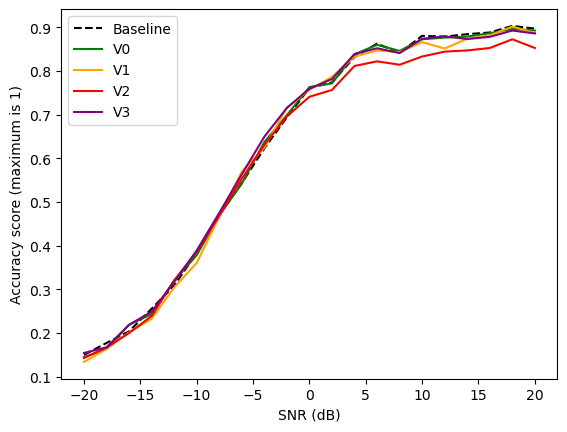

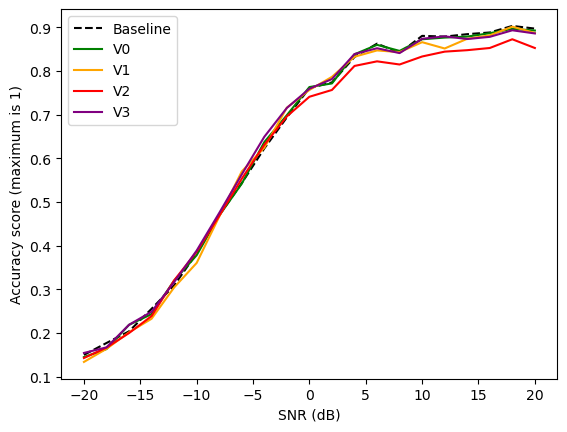

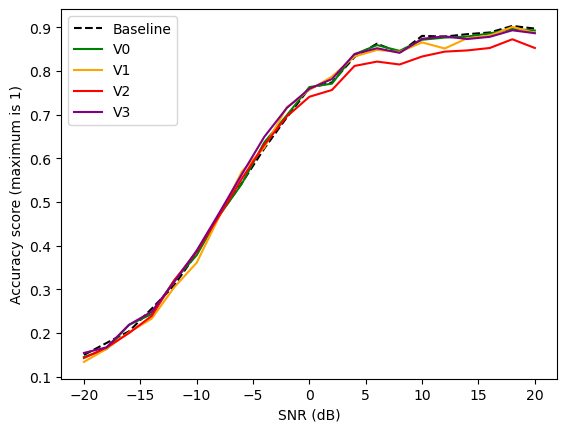

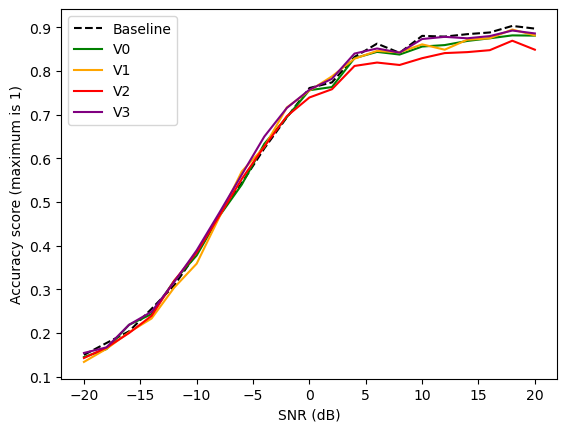

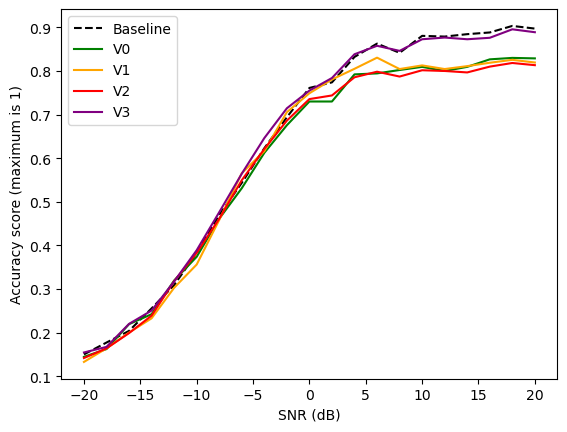

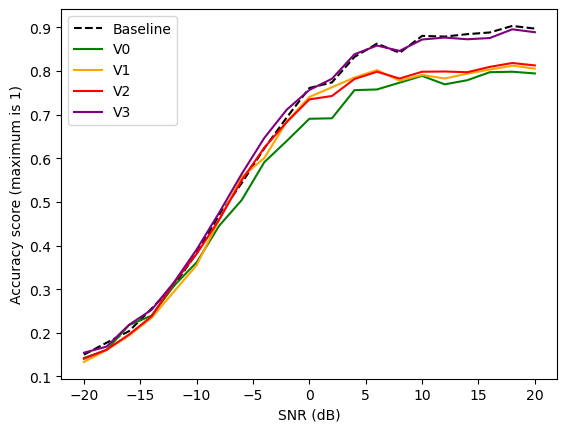

In [226]:
#thresholds = [0.01, 0.05, 0.15, 0.3, 0.4, 0.6]
figTitles = ['./Figures/accs/accuracy_all_T001.png', './Figures/accs/accuracy_all_T005.png', './Figures/accs/accuracy_all_T015.png',
             './Figures/accs/accuracy_all_T03.png','./Figures/accs/accuracy_all_T04.png','./Figures/accs/accuracy_all_T06.png']
for i in range(len(thresholds)):
    
    THRESHOLD = thresholds[i]
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(accuracies["Baseline"][0.05].values()), color = colors["baseline"], ls='--');
    plt.plot(xAxis, list(accuracies["V0"][THRESHOLD].values()), color = colors["V0"]);
    plt.plot(xAxis, list(accuracies["V1"][THRESHOLD].values()), color = colors["V1"]);
    plt.plot(xAxis, list(accuracies["V2"][THRESHOLD].values()), color = colors["V2"]);
    plt.plot(xAxis, list(accuracies["V3"][THRESHOLD].values()), color = colors["V3"]);
    plt.legend(["Baseline", "V0", "V1", "V2", "V3"])
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy score (maximum is 1)')
    #plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
    plt.savefig(figTitles[i])
    plt.show()

### Numbers at 10 dB

In [132]:
valuedB = '12'
print(accuracies["Baseline"][0.05][valuedB])
print(accuracies["V0"][0.3][valuedB])
print(accuracies["V1"][0.3][valuedB])
print(accuracies["V2"][0.3][valuedB])
print(accuracies["V3"][0.3][valuedB])

0.8788888888888899
0.8594444444444445
0.8488888888888889
0.8411111111111111
0.8783333333333333


### Accuracy at short branches

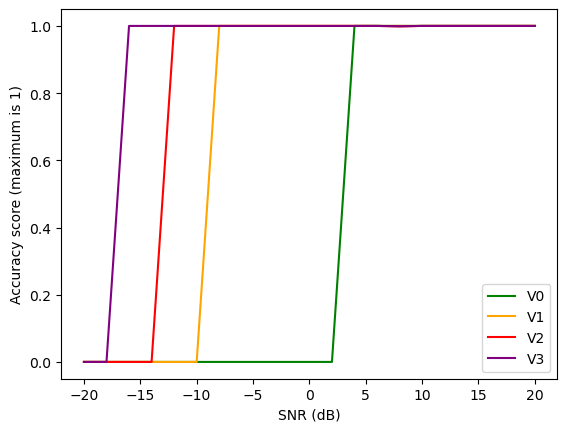

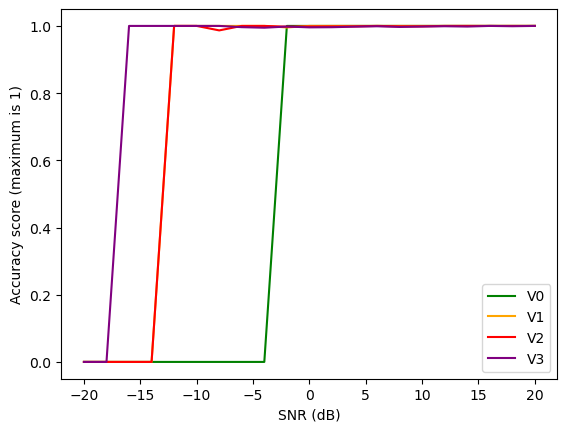

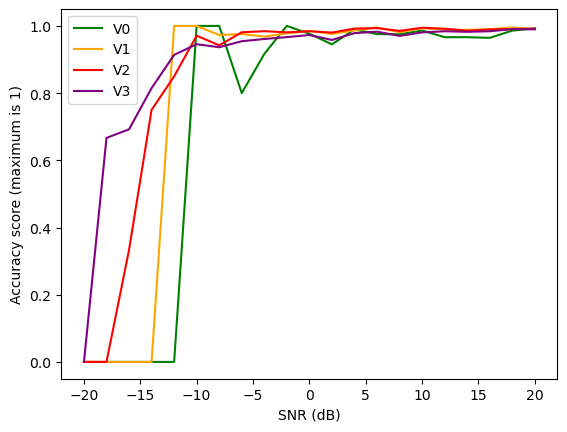

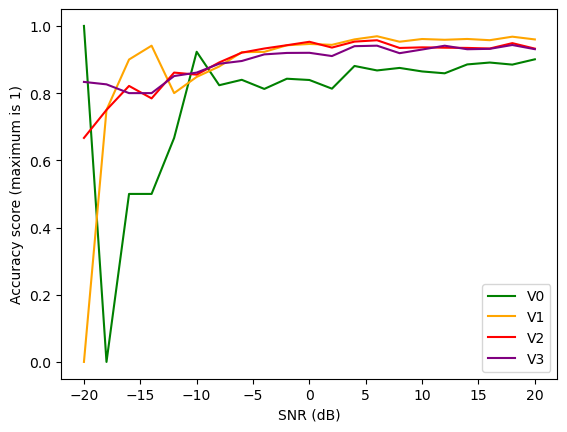

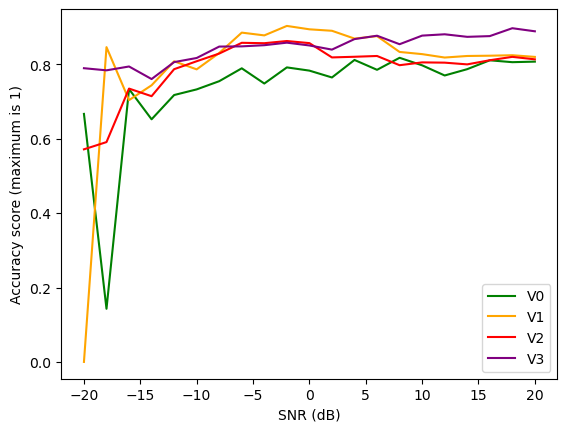

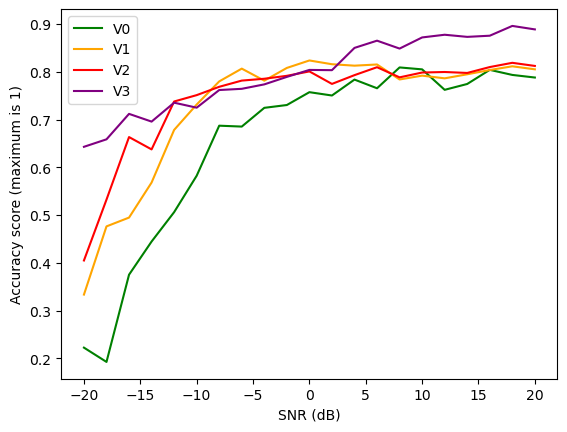

In [227]:
#thresholds = [0.01, 0.05, 0.15, 0.3, 0.4, 0.6]
figTitles = ['./Figures/accs/accuracy_short_T001.png', './Figures/accs/accuracy_short_T005.png', './Figures/accs/accuracy_short_T015.png',
             './Figures/accs/accuracy_short_T03.png','./Figures/accs/accuracy_short_T04.png','./Figures/accs/accuracy_short_T06.png']
for i in range(len(thresholds)):
    
    THRESHOLD = thresholds[i]
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(shortAccs["V0"][THRESHOLD].values()), color = colors["V0"]);
    plt.plot(xAxis, list(shortAccs["V1"][THRESHOLD].values()), color = colors["V1"]);
    plt.plot(xAxis, list(shortAccs["V2"][THRESHOLD].values()), color = colors["V2"]);
    plt.plot(xAxis, list(shortAccs["V3"][THRESHOLD].values()), color = colors["V3"]);
    plt.legend(["V0", "V1", "V2", "V3"])
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy score (maximum is 1)')
    #plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
    #plt.savefig(figTitles[i])
    plt.show()

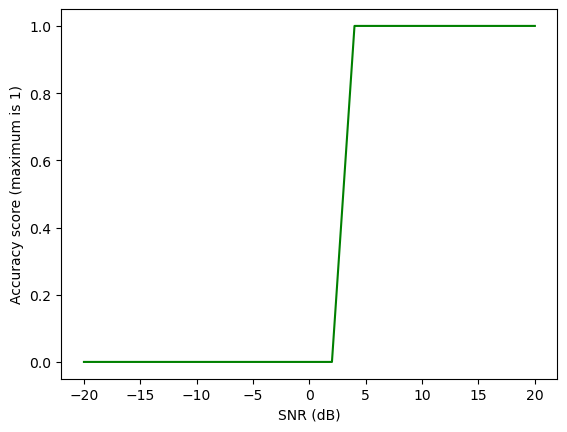

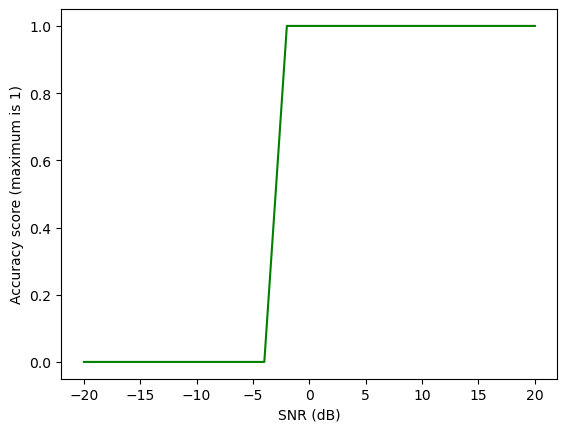

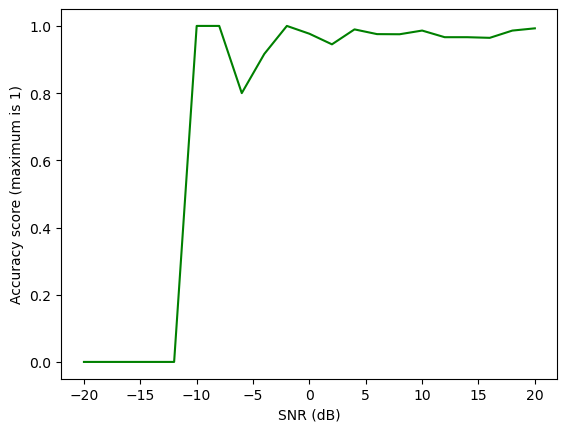

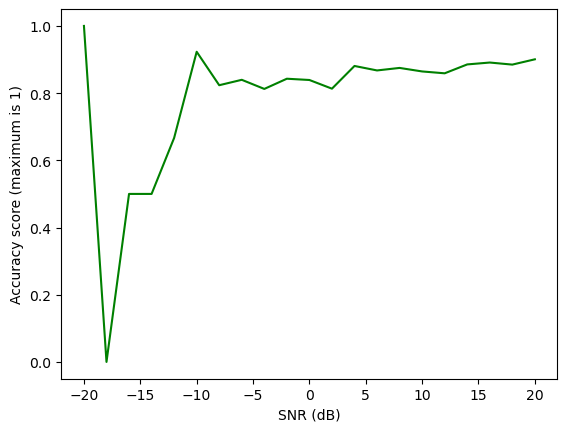

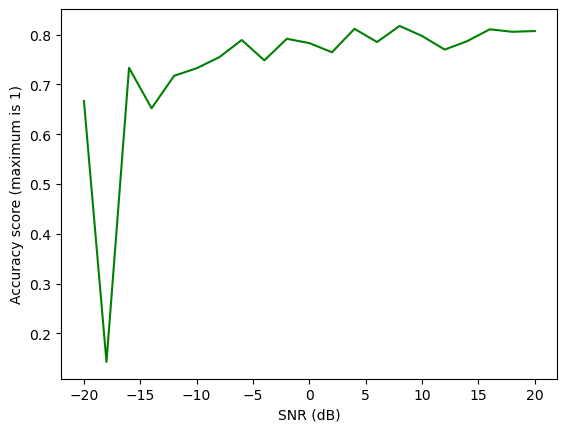

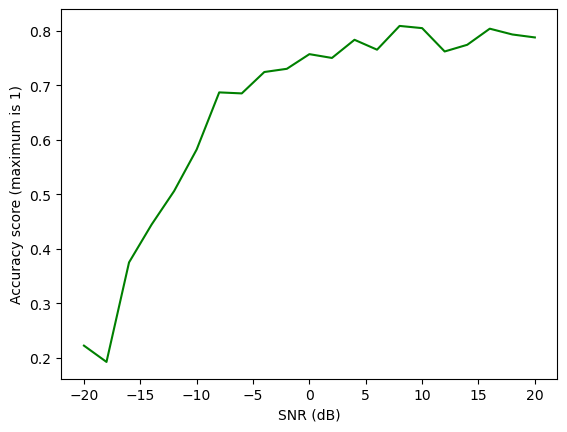

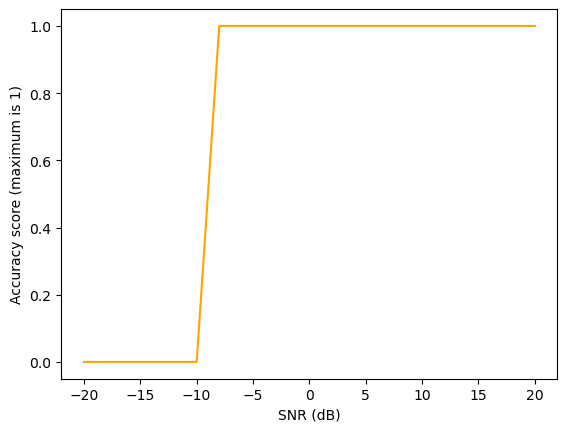

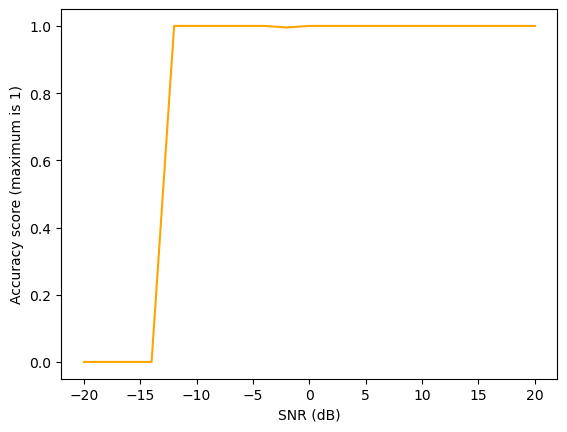

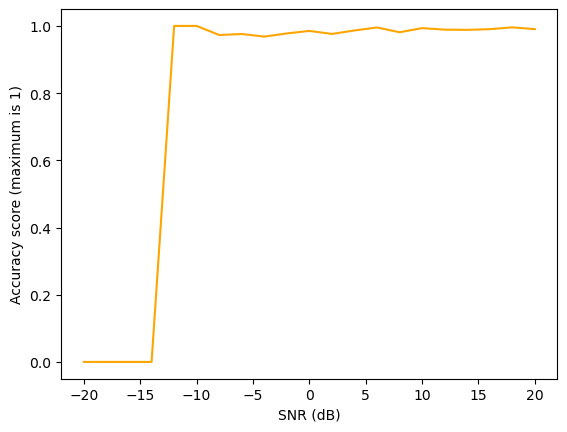

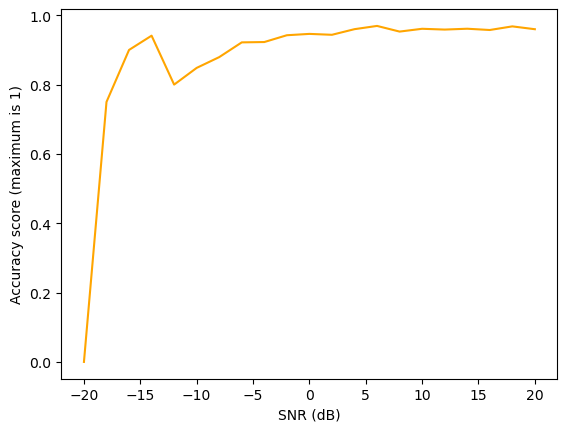

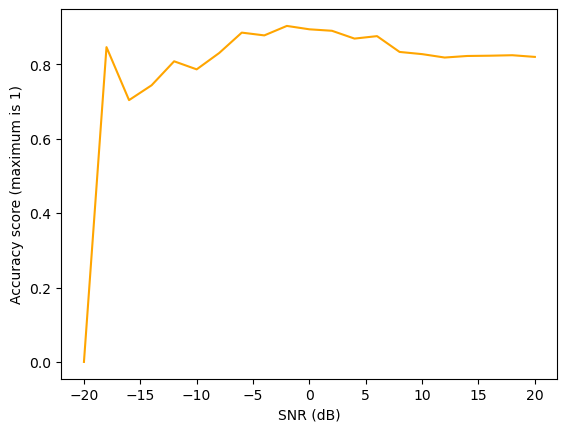

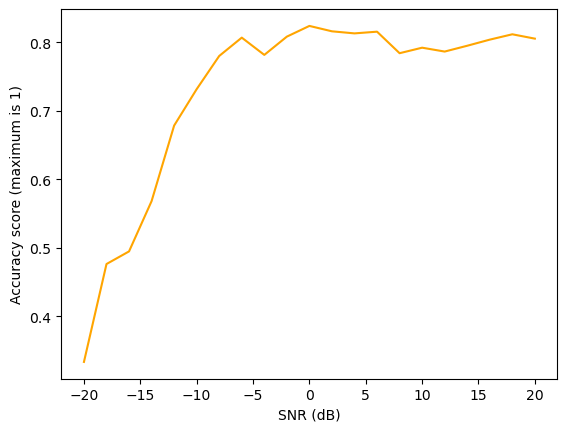

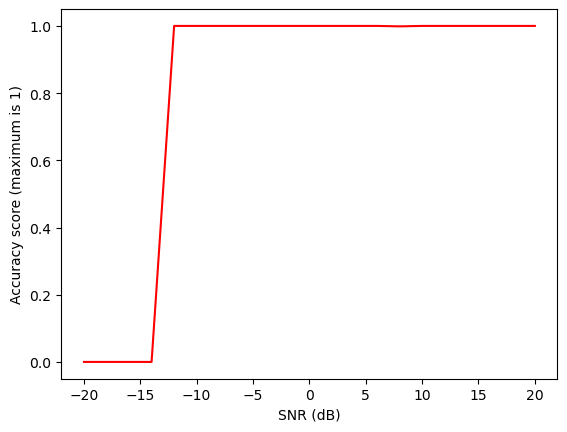

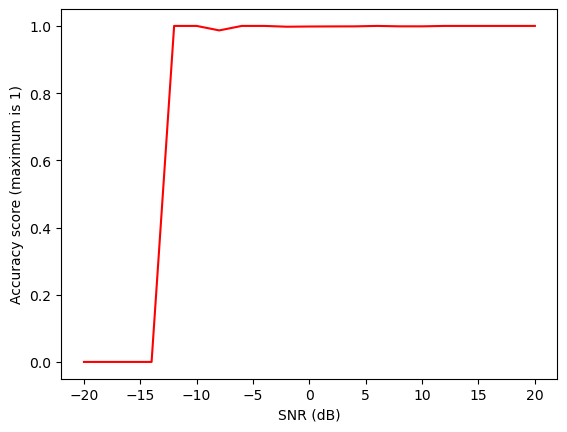

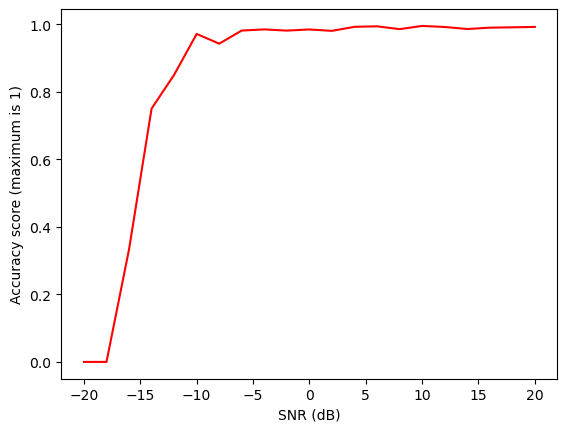

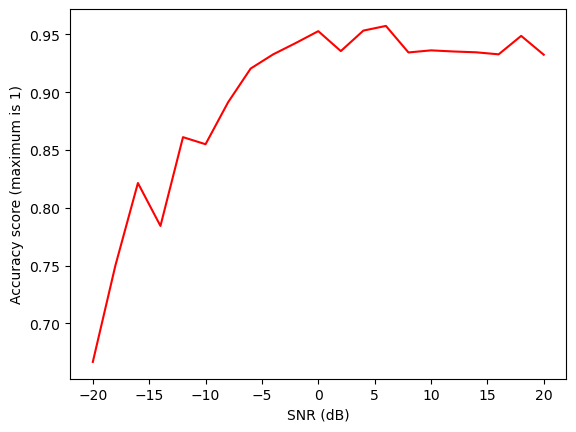

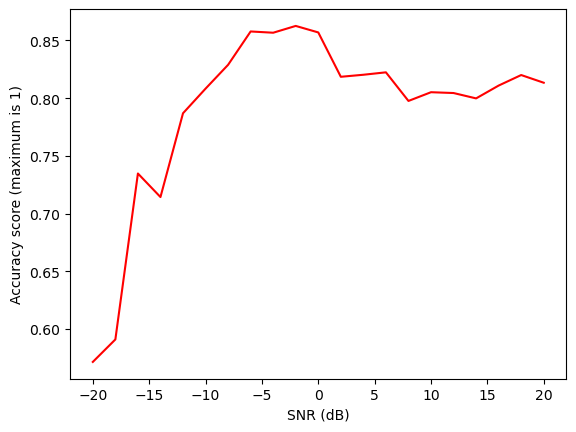

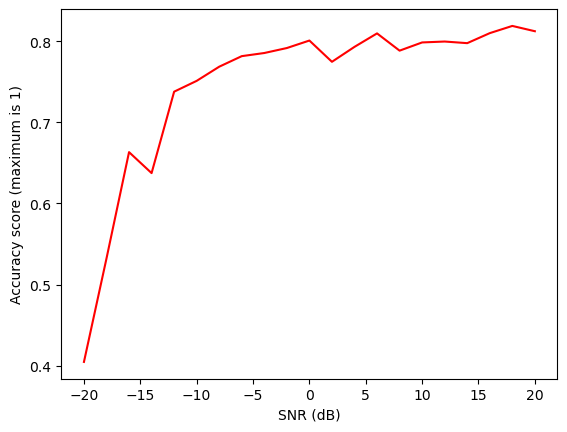

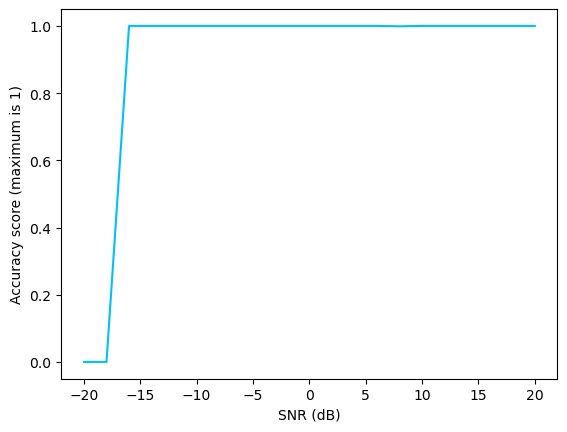

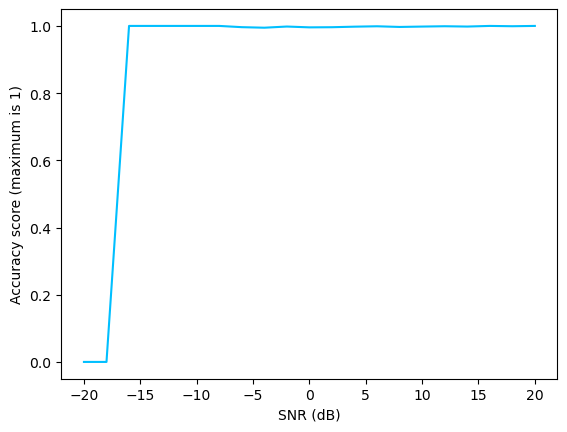

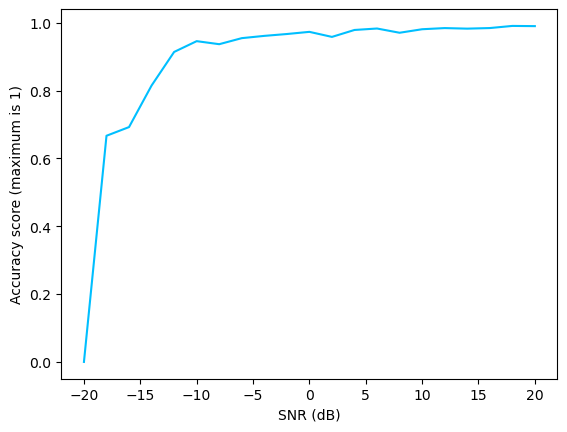

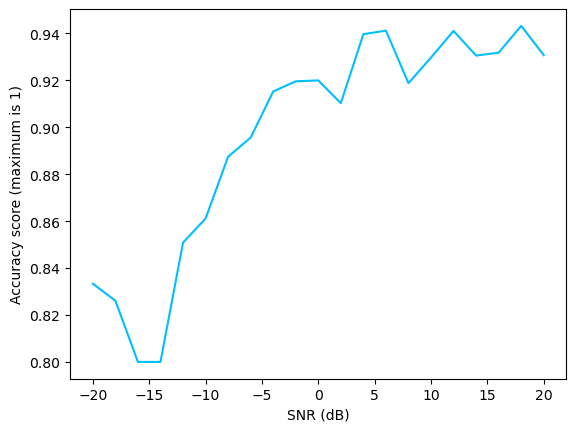

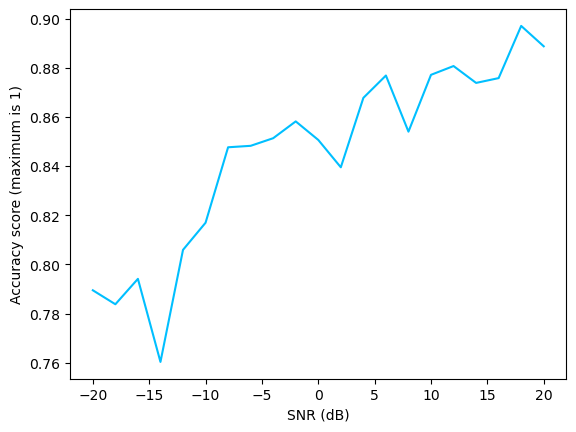

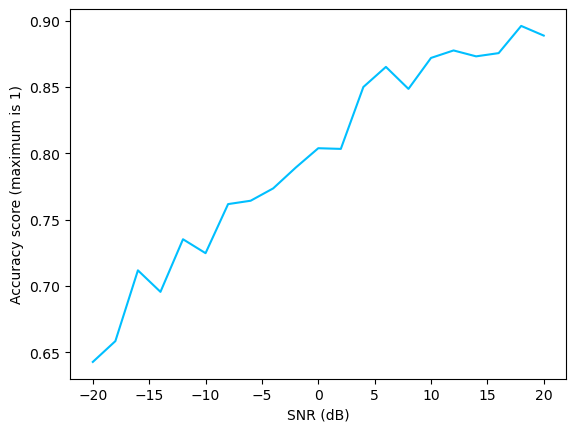

In [220]:
#thresholds = [0.01, 0.05, 0.15, 0.3, 0.4, 0.6]
# Only for certain V and T
figTitle = './Figures/accs/accuracy_short_{}_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']

for Version in ["V0", "V1", "V2", "V3"]:
    for i, THRESHOLD in enumerate(thresholds):

        fig = plt.Figure()

        xAxis = np.arange(-20, 21, 2) #SNRs
        plt.plot(xAxis, list(shortAccs[Version][THRESHOLD].values()), color = colors[Version]);
        
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy score (maximum is 1)')
        #plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
        #plt.savefig(figTitle.format(Version, thresholds_titles[i]))
        plt.show()

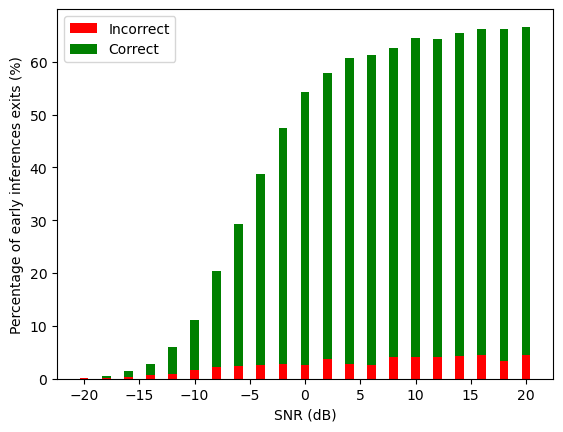

In [263]:

# Data
THRESHOLD = 0.3
Version = "V2"
figTitle = "./Figures/accs/bar_{}_T{}"
percentages = list(inferenceCounter2[Version][THRESHOLD][0].values())
correct = list(shortAccs[Version][THRESHOLD].values())
correct_percentage = [correct[i] * percentages[i] for i in range(len(percentages))]
incorrect_percentage = [percentages[i] - correct_percentage[i] for i in range(len(percentages))]


# Set the figure size
fig = plt.Figure(figsize=(8, 6))

# Create the plot
plt.bar(xAxis, incorrect_percentage, label='Incorrect', color='red')
plt.bar(xAxis, correct_percentage, label='Correct', bottom=incorrect_percentage, color='green')

# Add legend and labels
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('Percentage of early inferences exits (%)')
plt.savefig(figTitle.format(Version, "03"))
plt.show()


# EE Inference Percentage

### To compare all versions at all Ts

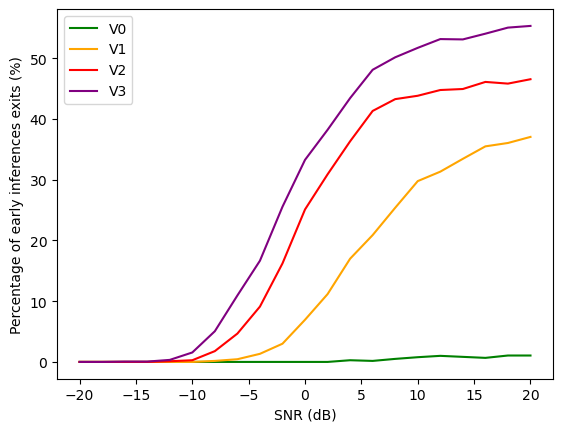

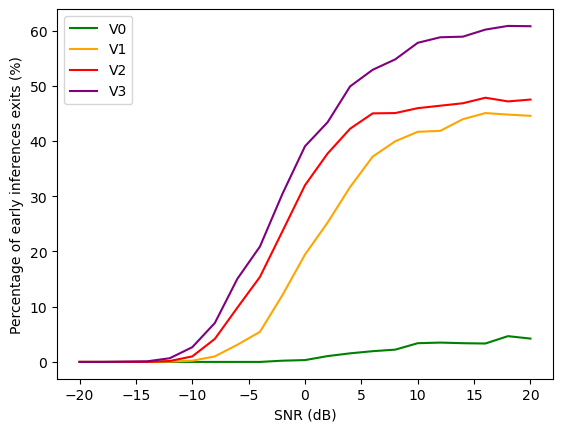

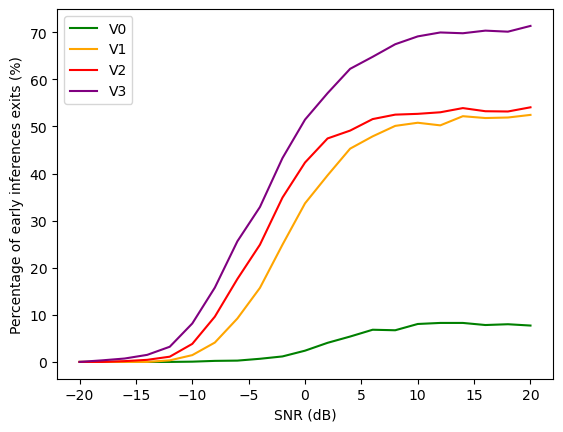

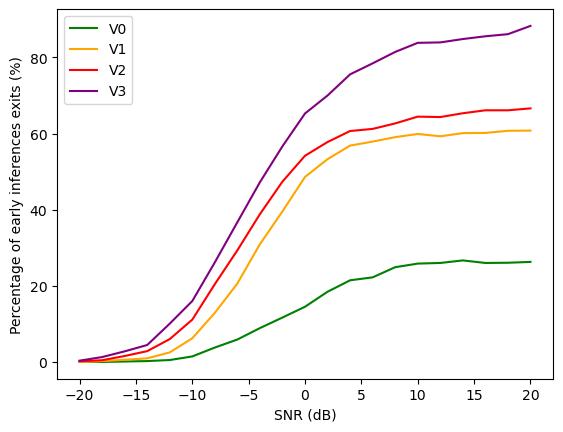

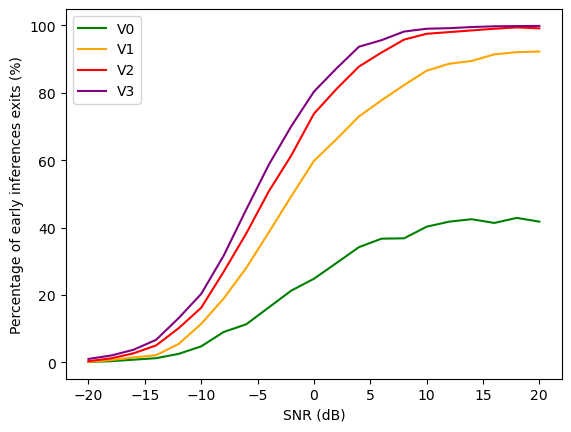

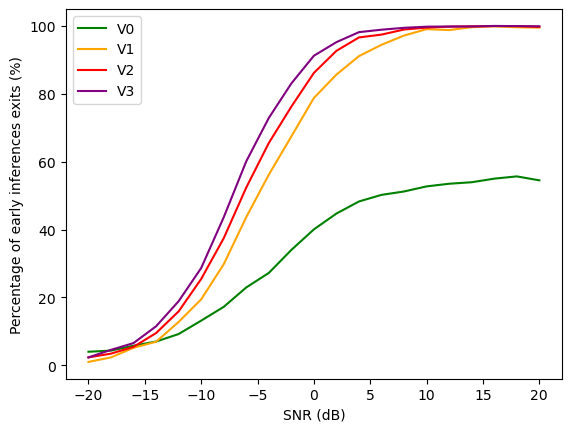

In [229]:
figTitle = './Figures/inference/diff_Versions/percent_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']

for i, THRESHOLD in enumerate(thresholds):
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(inferenceCounter["V0"][THRESHOLD][0].values()), color = colors["V0"])
    plt.plot(xAxis, list(inferenceCounter["V1"][THRESHOLD][0].values()), color = colors["V1"])
    plt.plot(xAxis, list(inferenceCounter["V2"][THRESHOLD][0].values()), color = colors["V2"])
    plt.plot(xAxis, list(inferenceCounter["V3"][THRESHOLD][0].values()), color = colors["V3"])

    plt.legend(["V0","V1", "V2", "V3"])
    plt.xlabel("SNR (dB)")
    plt.ylabel('Percentage of early inferences exits (%)')
    # Save the figure as a PNG file
    plt.savefig(figTitle.format(thresholds_titles[i]))
    plt.show()

In [137]:
print(inferenceCounter["V3"][0.3][0]['4'])
print(inferenceCounter["V3"][0.3][0]['10'])

75.55555555555556
83.83333333333334


###  To compare a certain version at different Ts

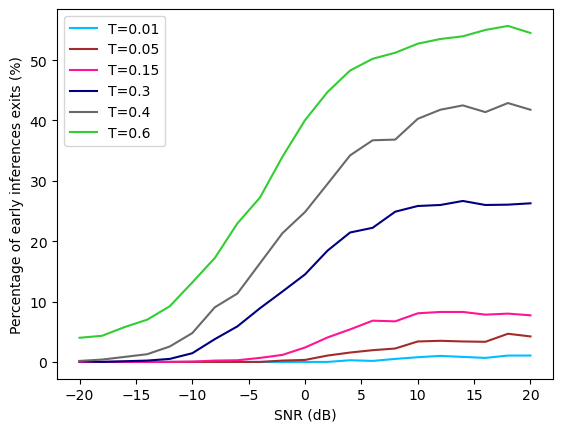

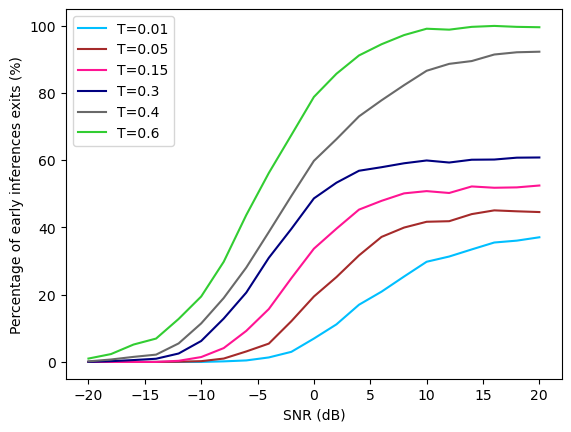

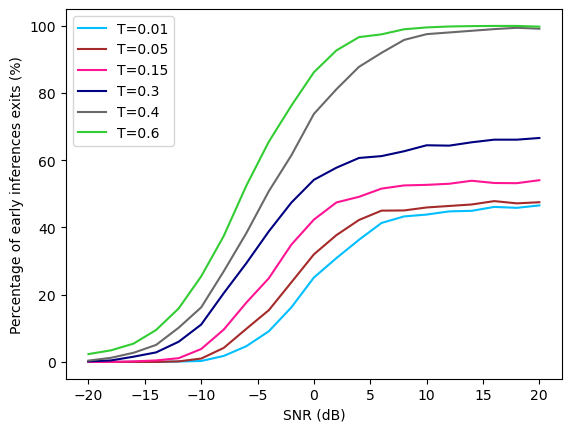

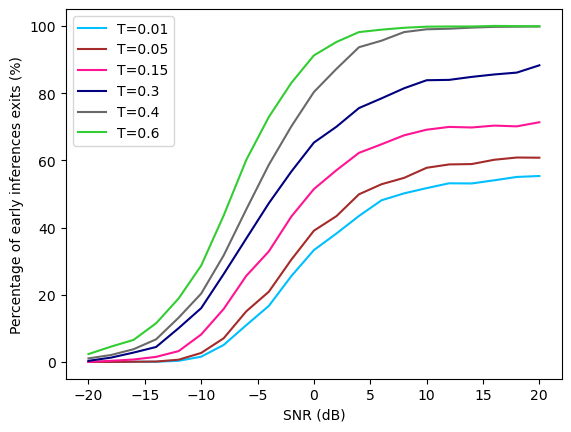

In [235]:
figTitle = './Figures/inference/diff_Thresholds/percent_{}.png'

for Version in ["V0", "V1", "V2", "V3"]:
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    for THRESHOLD in thresholds:
        plt.plot(xAxis, list(inferenceCounter[Version][THRESHOLD][0].values()), color = colors[THRESHOLD])

    plt.legend(["T=0.01", "T=0.05", "T=0.15", "T=0.3", "T=0.4", "T=0.6"])
    plt.xlabel("SNR (dB)")
    plt.ylabel('Percentage of early inferences exits (%)')
    # Save the figure as a PNG file
    plt.savefig(figTitle.format(Version))
    plt.show()

### Inference Bar Plots

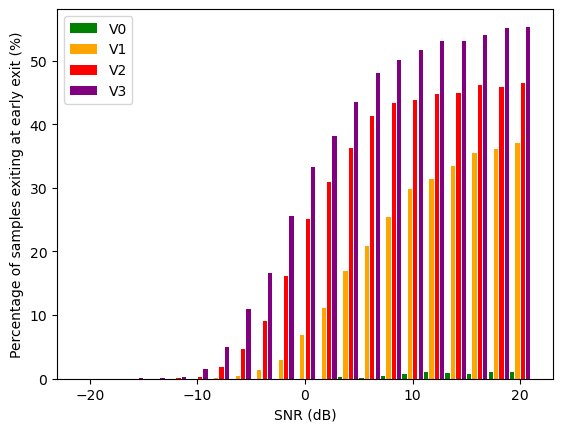

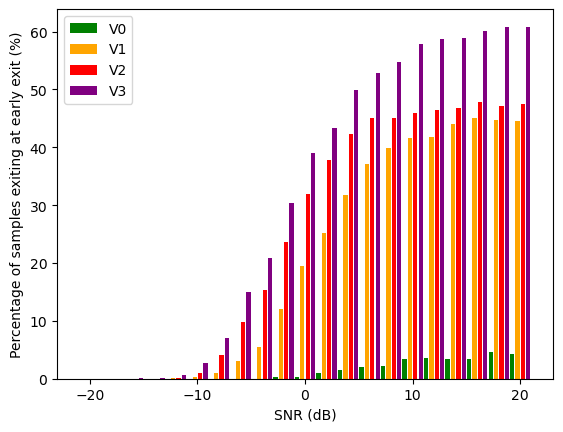

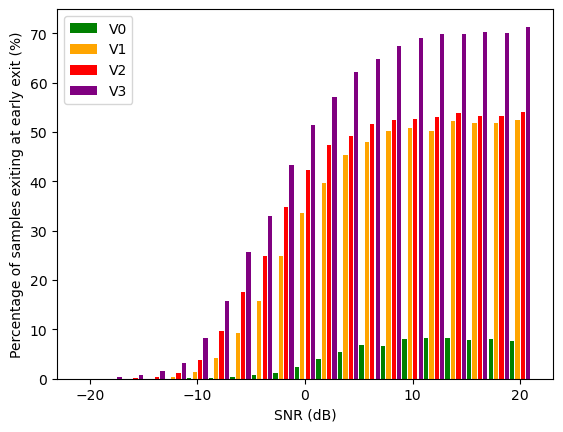

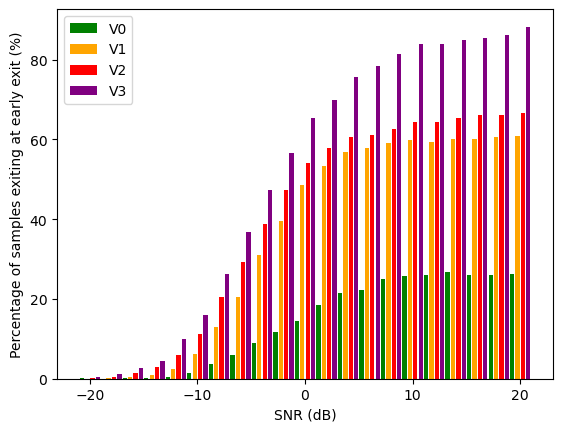

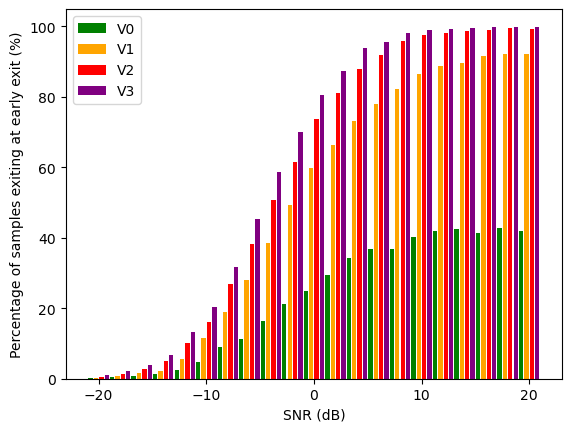

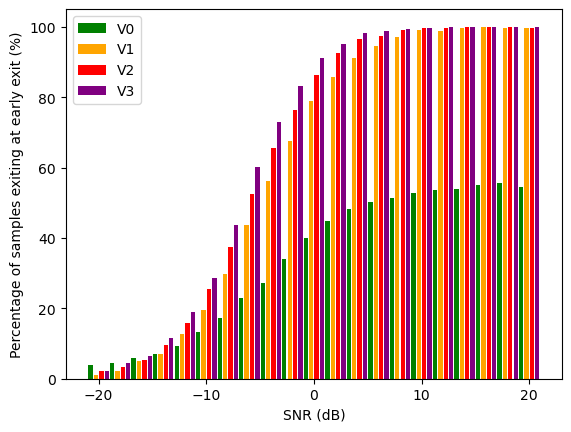

In [237]:
figTitle = './Figures/inference/bars/percent_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']
bar_width = 0.5 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

for i, THRESHOLD in enumerate(thresholds):

    data0 = list(inferenceCounter["V0"][THRESHOLD][0].values())
    data1 = list(inferenceCounter["V1"][THRESHOLD][0].values())
    data2 = list(inferenceCounter["V2"][THRESHOLD][0].values())
    data3 = list(inferenceCounter["V3"][THRESHOLD][0].values())

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot the data as grouped bars
    ax.bar(xAxis - 1.5*bar_width, data0, width=bar_width*0.8, label='V0', color = colors["V0"])
    ax.bar(xAxis - 0.5*bar_width, data1, width=bar_width*0.8, label='V1', color = colors["V1"])
    ax.bar(xAxis + 0.5*bar_width, data2, width=bar_width*0.8, label='V2', color = colors["V2"])
    ax.bar(xAxis + 1.5*bar_width, data3, width=bar_width*0.8, label='V3', color = colors["V3"])

    # Set the axis labels and title
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Percentage of samples exiting at early exit (%)')
    #ax.set_title('Grouped Bar Chart')

    # Add a legend
    ax.legend()

    # Save the figure as a PNG file
    fig.savefig(figTitle.format(thresholds_titles[i]))
    
    plt.show()


### Individuals

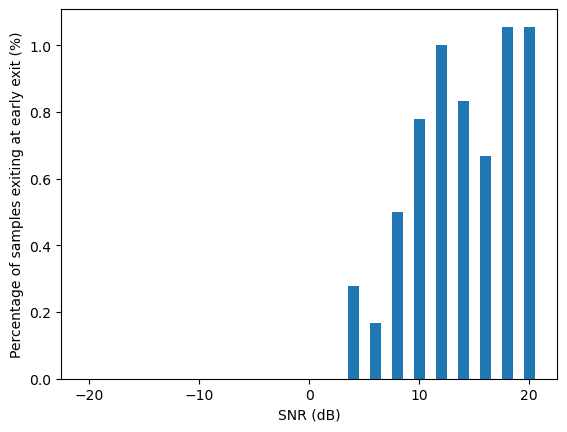

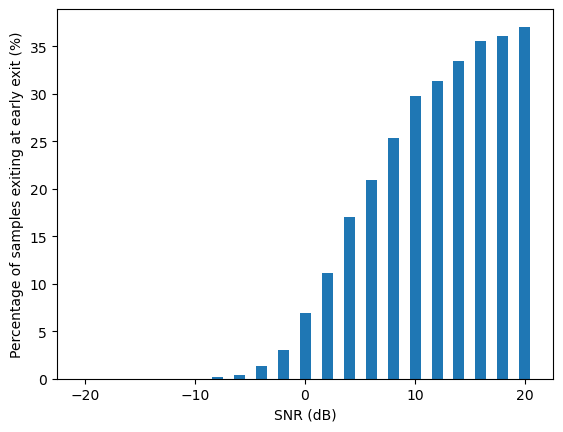

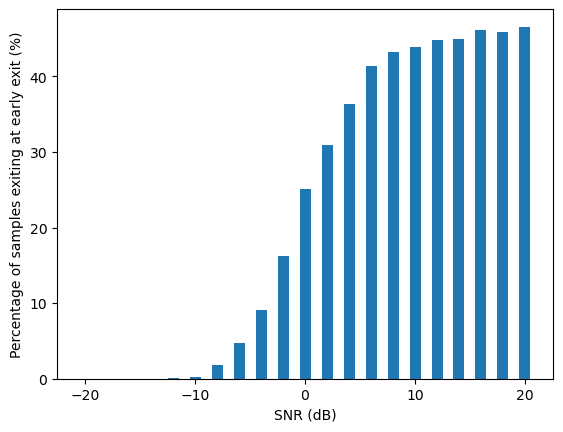

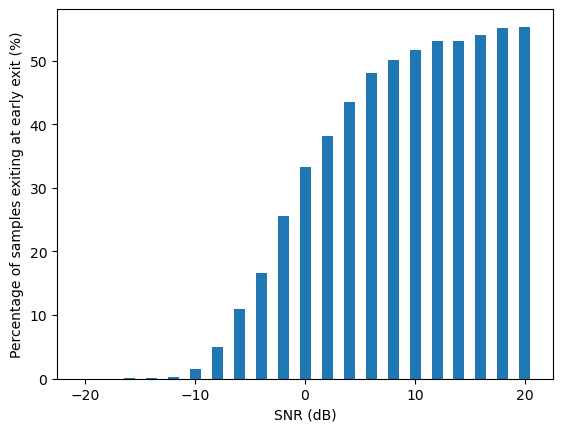

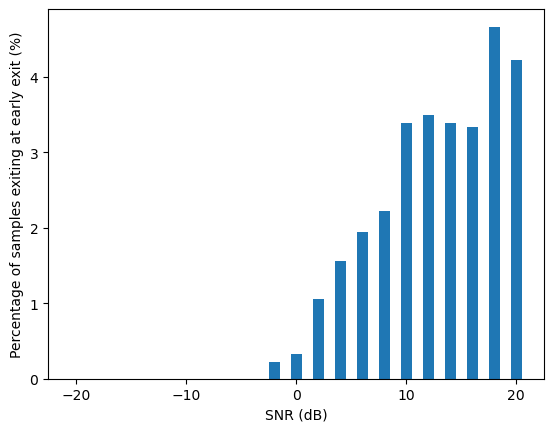

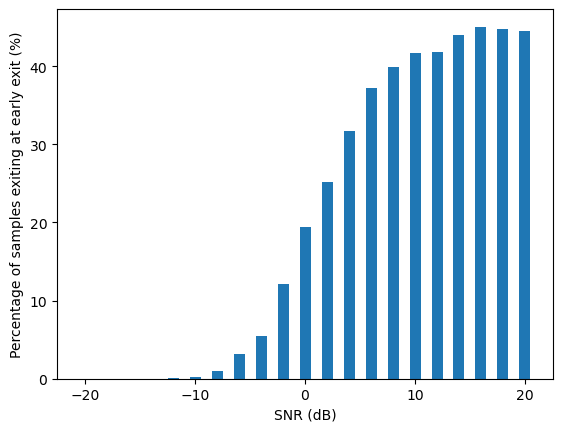

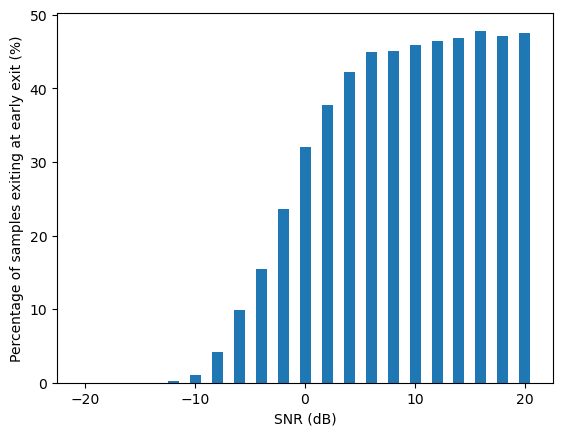

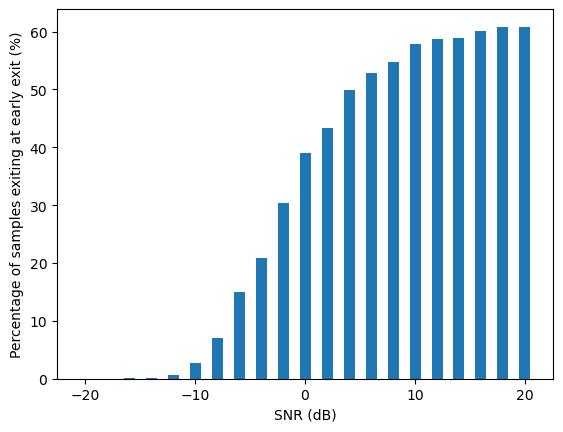

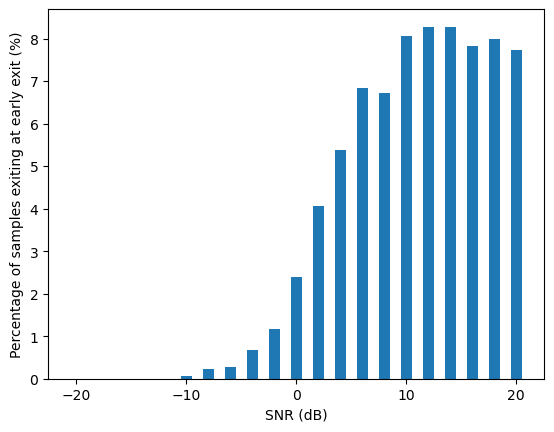

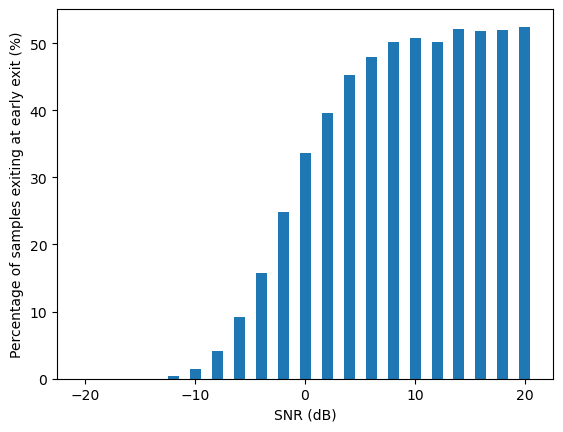

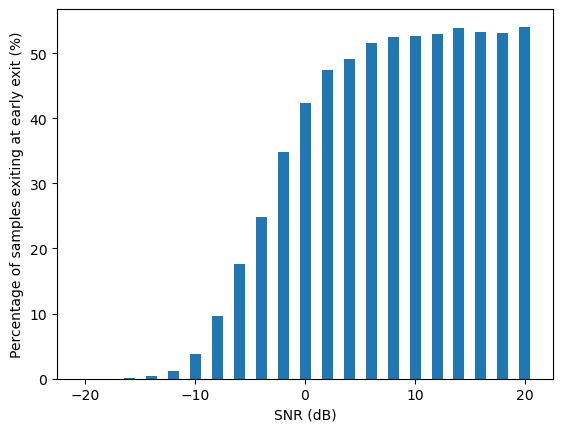

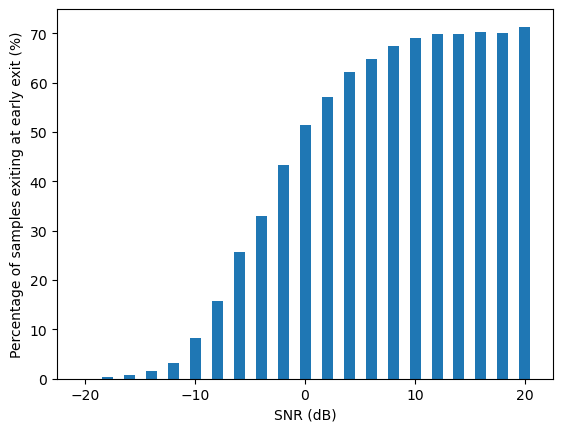

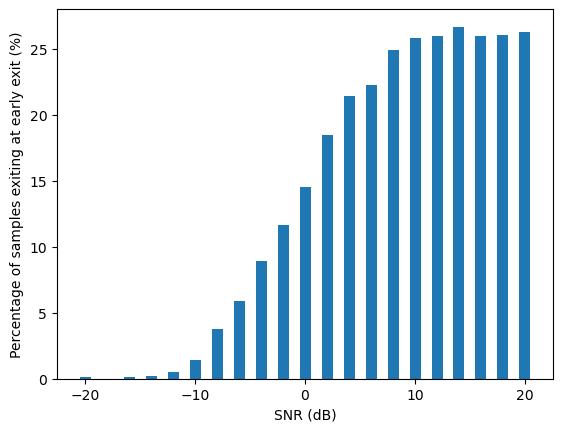

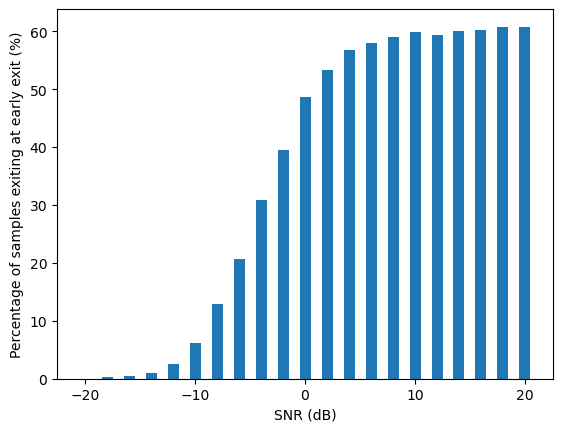

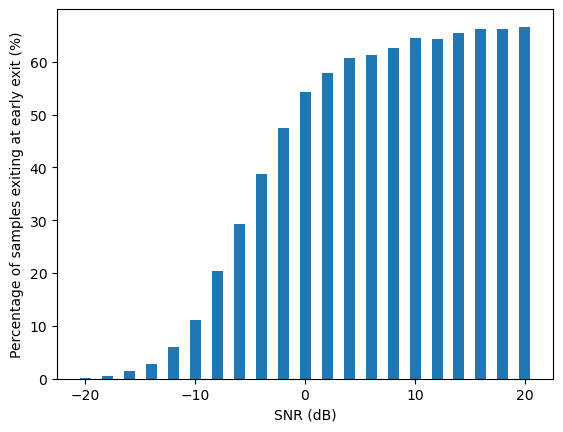

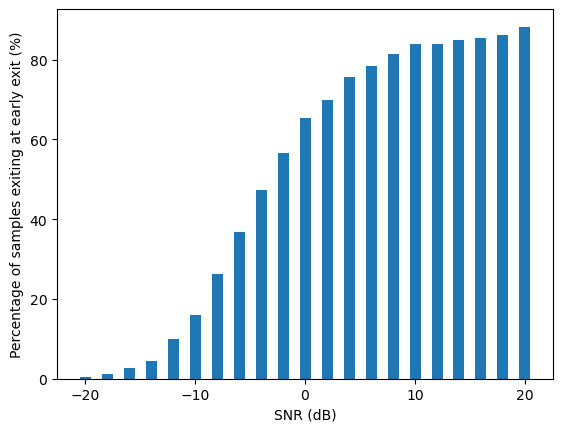

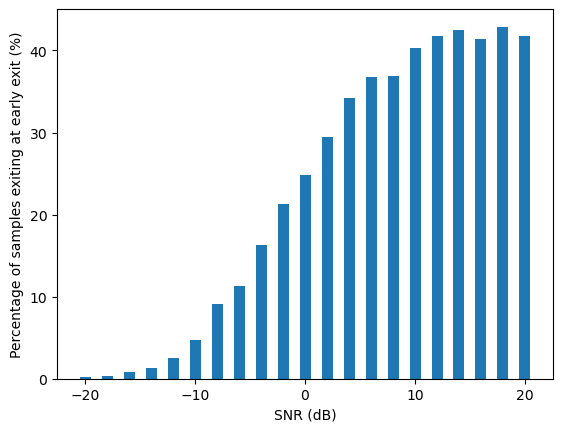

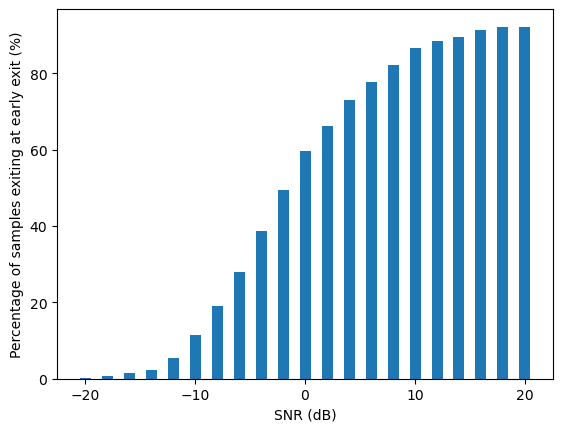

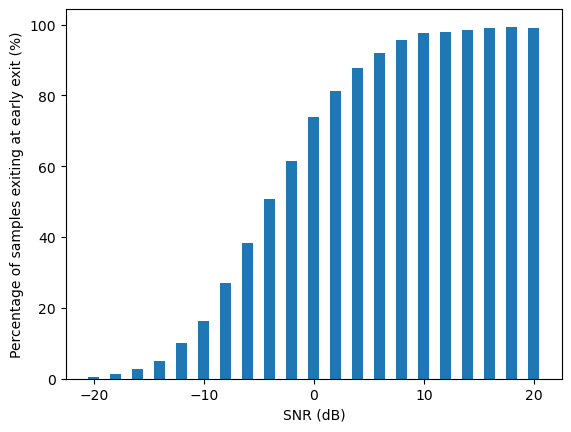

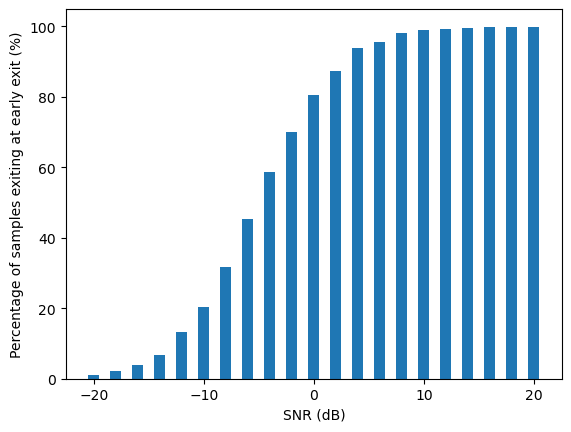

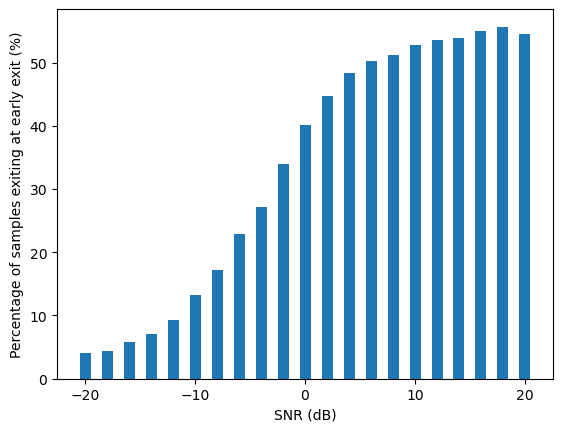

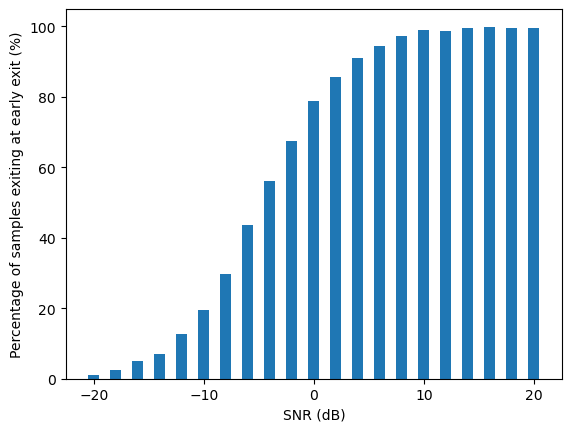

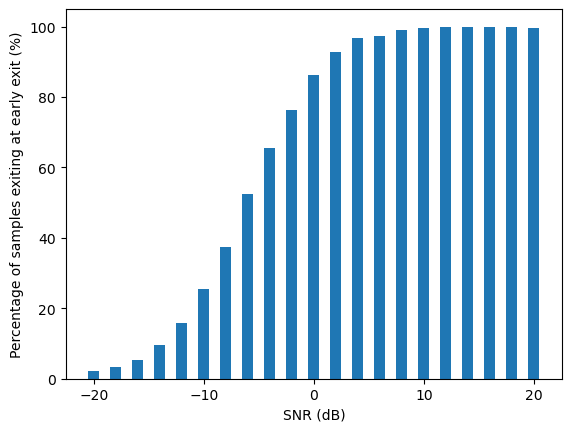

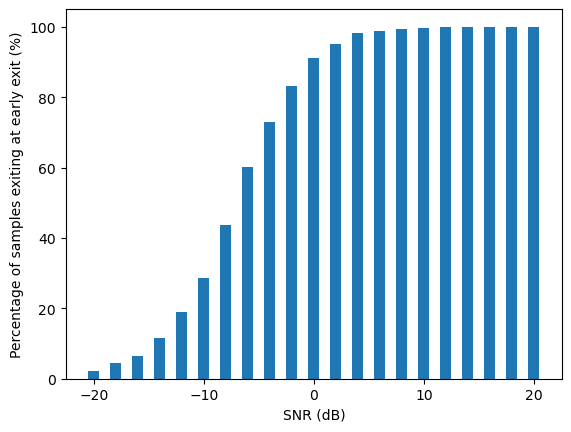

In [238]:
figTitle = './Figures/inference/individuals/percent_{}_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']
bar_width = 1.0 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

for i, THRESHOLD in enumerate(thresholds):
    for Version in ["V0", "V1", "V2", "V3"]:
        # Create a figure and axis object
        fig, ax = plt.subplots()

        # Plot the data as grouped bars
        ax.bar(xAxis, inferenceCounter[Version][THRESHOLD][0].values(), width=bar_width, label='short branch')

        # Set the axis labels and title
        ax.set_xlabel('SNR (dB)')
        ax.set_ylabel('Percentage of samples exiting at early exit (%)')

        # Show the plot
        plt.show()

        # Save the figure as a PNG file
        fig.savefig(figTitle.format(Version, thresholds_titles[i]))

## Inference Time

In [103]:
def smoothing(x, y):
    # Define the window size and type
    window_size = 10
    window_type = 'blackman'
    for _ in range(3):
        x = np.insert(x, [0], x[0]-1)
    y = [y[0], y[0], y[0]] + y
    # Apply the window function
    window = getattr(np, window_type)(window_size)
    y_smooth = np.convolve(y, window, mode='same') / sum(window)

    return x, y_smooth

# Input of 1 sample for time estimation
input_ = torch.randn(1, 2, 128).to(device)
input_.size()

torch.Size([1, 2, 128])

In [96]:
def infer_short(net, i):
        net.eval()
        with torch.no_grad():
            x = net.short_forward(i)
def infer_long(net, i):
        net.eval()
        with torch.no_grad():
            x = net.long_forward(i)
                
Versions_times = {x:{"short": 0, "long":0} for x in ["V0", "V1", "V2", "V3"]}


    
v0_short, v1_short, v2_short, v3_short = 0, 0, 0, 0
v0_long, v1_long, v2_long, v3_long = 0, 0, 0, 0
N = 200
for _ in range(N):
    # V0
    start_time = time.time()
    infer_short(eeNet_V0, input_)
    v0_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V0, input_)
    v0_long += time.time() - start_time
        
    # V1
    start_time = time.time()
    infer_short(eeNet_V1, input_)
    v1_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V1, input_)
    v1_long += time.time() - start_time
        
    # V2
    start_time = time.time()
    infer_short(eeNet_V2, input_)
    v2_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V2, input_)
    v2_long += time.time() - start_time
        
    # V3
    start_time = time.time()
    infer_short(eeNet_V3, input_)
    v3_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V3, input_)
    v3_long += time.time() - start_time
        

    Versions_times["V0"]["short"], Versions_times["V1"]["short"], Versions_times["V2"]["short"], Versions_times["V3"]["short"] = v0_short/N, v1_short/N, v2_short/N, v3_short/N
    Versions_times["V0"]["long"], Versions_times["V1"]["long"], Versions_times["V2"]["long"], Versions_times["V3"]["long"] = v0_long/N, v1_long/N, v2_long/N, v3_long/N

Versions_times     

{'V0': {'short': 0.0002886486053466797, 'long': 0.0012257027626037598},
 'V1': {'short': 0.0006323301792144775, 'long': 0.0012754344940185548},
 'V2': {'short': 0.0008005154132843018, 'long': 0.0015632498264312744},
 'V3': {'short': 0.001005946397781372, 'long': 0.0009813272953033446}}

In [98]:
avg_longTime = sum(Versions_times[x]["long"] for x in ["V0", "V1", "V2", "V3"])/4
avg_longTime

0.0012614285945892335

In [123]:
# Baseline Inference Time
bl_time = 1800*avg_longTime
bl_time

2.27057147026062

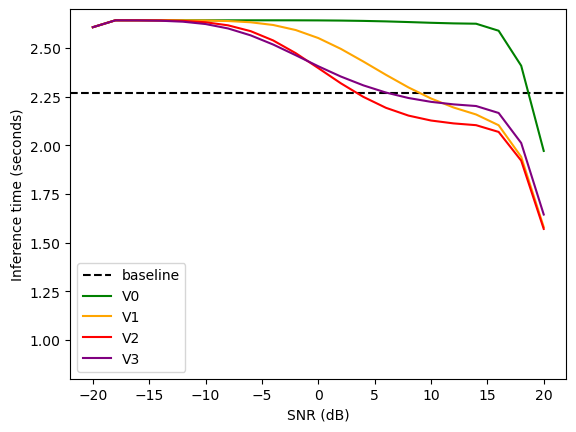

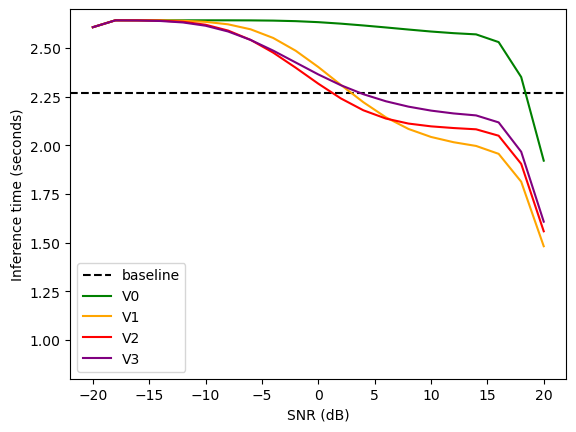

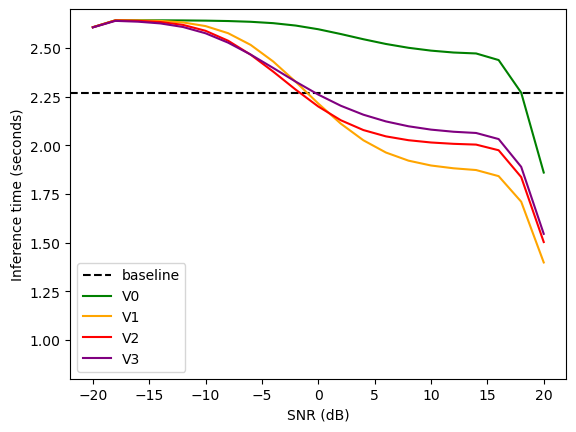

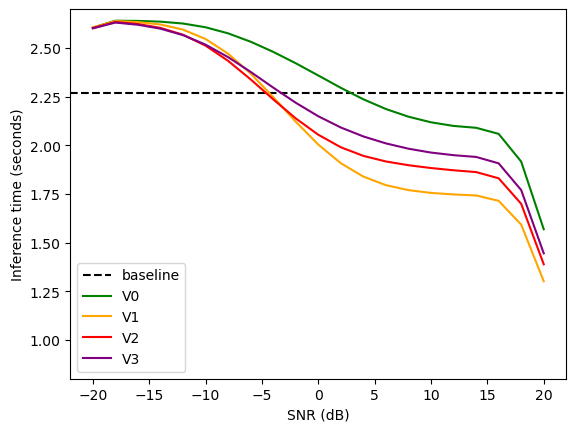

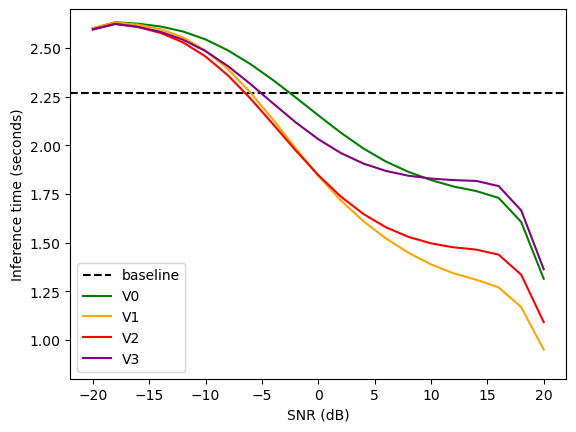

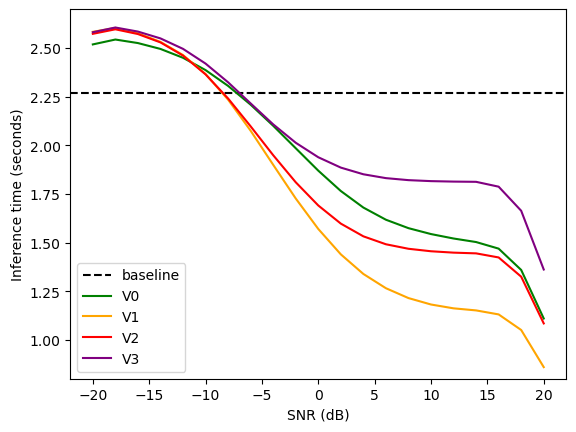

In [313]:
figTitle = './Figures/time/diff_Versions/times_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']
dbl_calc_time = 0.00020662546157836914
xAxis = np.arange(-20, 21, 2) #SNRs
finalTimes = {x: {v:{snrV: 0 for snrV in stringSNRs} for v in ["V0", "V1", "V2", "V3"]} for x in thresholds}
for i, THRESHOLD in enumerate(thresholds):

    for Version in ["V0", "V1", "V2", "V3"]:
        for snrV in stringSNRs:
            short_percentage = inferenceCounter[Version][THRESHOLD][0][snrV]
            long_percentage = inferenceCounter[Version][THRESHOLD][1][snrV]
            shortTime = int(short_percentage*1800/100)*Versions_times[Version]['short'] 

            longTime = int(long_percentage*1800/100)*(avg_longTime+dbl_calc_time)  
            #longTime += int(long_percentage*1800/100)*dbl_calc_time

            finalTimes[THRESHOLD][Version][snrV] = shortTime + longTime
    
    #fig = plt.Figure()
    fig, ax = plt.subplots()
    # Add the vertical line
    plt.axhline(y=bl_time, color=colors["baseline"], ls='--')
    
    # V0
    x, y_0 = smoothing(xAxis, list(finalTimes[THRESHOLD]['V0'].values()))
    plt.plot(xAxis, y_0[3:], color = colors["V0"])
    # V1
    x, y_1 = smoothing(xAxis, list(finalTimes[THRESHOLD]['V1'].values()))
    plt.plot(xAxis, y_1[3:], color = colors["V1"])
    # V2
    x, y_2 = smoothing(xAxis, list(finalTimes[THRESHOLD]['V2'].values()))
    plt.plot(xAxis, y_2[3:], color = colors["V2"])
    # V3
    x, y_3 = smoothing(xAxis, list(finalTimes[THRESHOLD]['V3'].values()))
    plt.plot(xAxis, y_3[3:], color = colors["V3"])

    

    plt.legend(["baseline", "V0", "V1", "V2", "V3"])
    plt.xlabel("SNR (dB)")
    plt.ylabel("Inference time (seconds)")
    plt.ylim(0.8, 2.7)
    plt.show()
    fig.savefig(figTitle.format(thresholds_titles[i]))

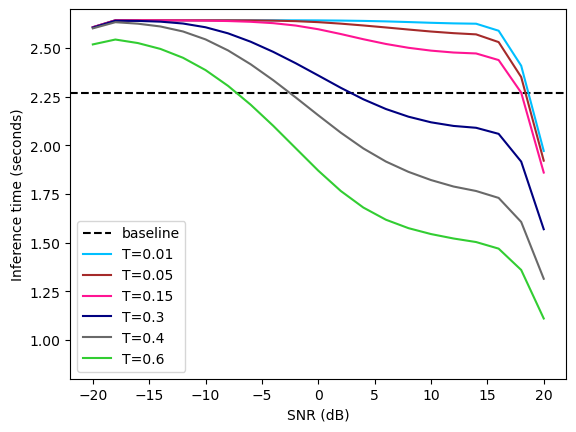

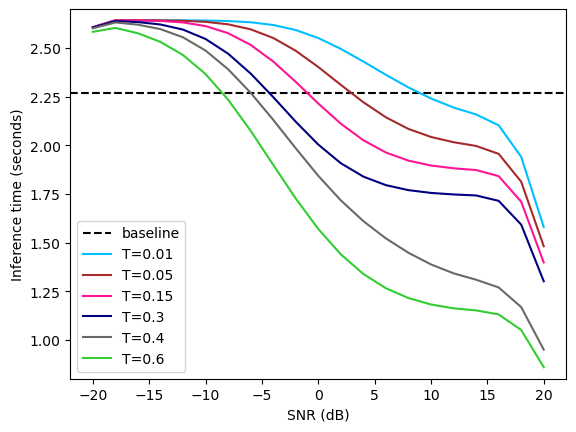

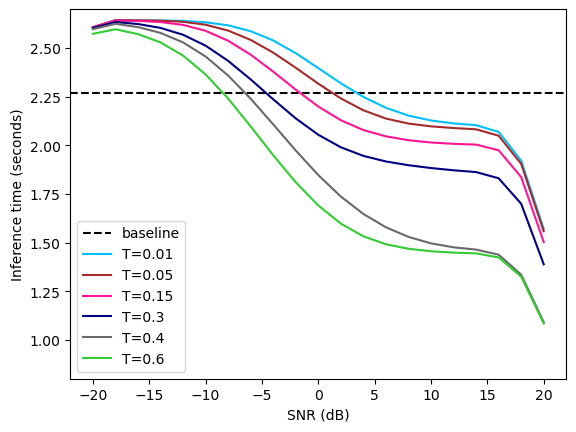

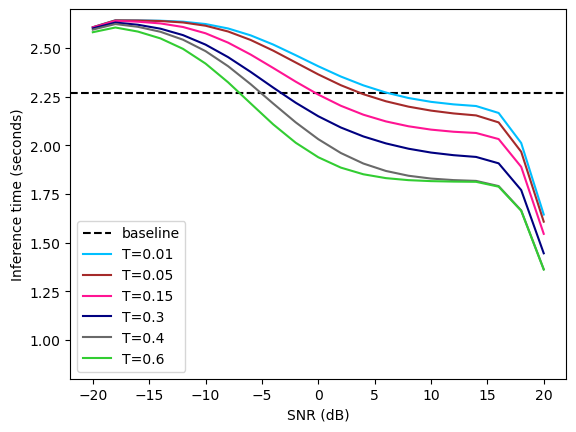

In [312]:
figTitle = './Figures/time/diff_Thresholds/times_{}.png'
dbl_calc_time = 0.00020662546157836914
xAxis = np.arange(-20, 21, 2) #SNRs

finalTimes2 = {x: {THRESHOLD:{snrV: 0 for snrV in stringSNRs} for THRESHOLD in thresholds} for x in ["V0", "V1", "V2", "V3"]}

for Version in ["V0", "V1", "V2", "V3"]:

    
    for i, THRESHOLD in enumerate(thresholds):
        for snrV in stringSNRs:
            short_percentage = inferenceCounter[Version][THRESHOLD][0][snrV]
            long_percentage = inferenceCounter[Version][THRESHOLD][1][snrV]

            shortTime = int(short_percentage*1800/100)*Versions_times[Version]['short'] 

            longTime = int(long_percentage*1800/100)*(avg_longTime+dbl_calc_time)  
            #longTime += long_percentage*len(valLoader)*dbl_calc_time

            finalTimes2[Version][THRESHOLD][snrV] = shortTime + longTime
    
    #fig = plt.Figure()
    fig, ax = plt.subplots()
    # Add the vertical line
    plt.axhline(y=bl_time, color='black', ls='--')
    
    # T=0.01
    x, y_0 = smoothing(xAxis, list(finalTimes2[Version][0.01].values()))
    plt.plot(xAxis, y_0[3:], color = colors[0.01])
    # T=0.05
    x, y_1 = smoothing(xAxis, list(finalTimes2[Version][0.05].values()))
    plt.plot(xAxis, y_1[3:], color = colors[0.05])
    # T = 0.15
    x, y_2 = smoothing(xAxis, list(finalTimes2[Version][0.15].values()))
    plt.plot(xAxis, y_2[3:], color = colors[0.15])
    # T = 0.3
    x, y_3 = smoothing(xAxis, list(finalTimes2[Version][0.3].values()))
    plt.plot(xAxis, y_3[3:], color = colors[0.3])
    # T = 0.4
    x, y_4 = smoothing(xAxis, list(finalTimes2[Version][0.4].values()))
    plt.plot(xAxis, y_4[3:], color = colors[0.4])
    # T = 0.6
    x, y_5 = smoothing(xAxis, list(finalTimes2[Version][0.6].values()))
    plt.plot(xAxis, y_5[3:], color = colors[0.6])
    
    
    plt.legend(["baseline", "T=0.01", "T=0.05", "T=0.15", "T=0.3", "T=0.4", "T=0.6"])
    plt.xlabel("SNR (dB)")
    plt.ylabel("Inference time (seconds)")
    
    plt.ylim(0.8, 2.7)
    plt.show()
    fig.savefig(figTitle.format(Version))

# Testing Results

In [244]:
accuracies_test = {typ: {thre:{y: 0 for y in stringSNRs} for thre in thresholds} for typ in ["Baseline", "V0", "V1", "V2", "V3"]}
inferenceCounter_test= {y: {thre: {x: {snr: 0 for snr in stringSNRs} for x in range(nBranches)} for thre in thresholds} for y in ["V0", "V1", "V2", "V3"]}
shortAccs_test = {V:{thre: {y: 0 for y in stringSNRs} for thre in thresholds} for V in ["V0", "V1", "V2", "V3"]}

In [245]:
# Getting TRAIN data with differebt SNRs values in dB
for snr in stringSNRs:
    
    tmpData = np.array([testXs[i] for i in range(len(testLabels)) if testLabels[i][1]==snr])
    tmpLabels = np.array([testLabels[i][0] for i in range(len(testLabels)) if testLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    

    bl_Acc = 0
    
    with torch.no_grad():
            blNet.eval()
            for data, labels in tmpLoader:
                data, labels = data.to(device), labels.to(device)
                # Long
                outputs = blNet(data)
                _, preds = torch.max(outputs, 1)
                bl_Acc += accuracy_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())     
                
            bl_Acc = bl_Acc/len(tmpLoader)
            
            accuracies_test["Baseline"][0.05][snr] = bl_Acc  # 0.01 is just a placeholder..
    
    # Early Exiting
    for thre in thresholds:
        recorder_V0, _, eeAcc_V0 = EE_V0.infer(tmpLoader, threshold=thre)
        accuracies_test["V0"][thre][snr] = eeAcc_V0
        if len(recorder_V0[0]) > 0:
            shortAccs_test["V0"][thre][snr] = sum(recorder_V0[0])/len(recorder_V0[0])
        
        recorder_V1, _, eeAcc_V1 = EE_V1.infer(tmpLoader, threshold=thre)
        accuracies_test["V1"][thre][snr] = eeAcc_V1
        if len(recorder_V1[0]) > 0:
            shortAccs_test["V1"][thre][snr] = sum(recorder_V1[0])/len(recorder_V1[0])

        recorder_V2, _, eeAcc_V2 = EE_V2.infer(tmpLoader, threshold=thre)
        accuracies_test["V2"][thre][snr] = eeAcc_V2
        if len(recorder_V2[0]) > 0:
            shortAccs_test["V2"][thre][snr] = sum(recorder_V2[0])/len(recorder_V2[0])
        
        recorder_V3, _, eeAcc_V3 = EE_V3.infer(tmpLoader, threshold=thre)
        accuracies_test["V3"][thre][snr] = eeAcc_V3
        if len(recorder_V3[0]) > 0:
            shortAccs_test["V3"][thre][snr] = sum(recorder_V3[0])/len(recorder_V3[0])

    
        for i in range(nBranches):
            inferenceCounter_test["V0"][thre][i][snr] = len(recorder_V0[i])/(len(recorder_V0[0])+len(recorder_V0[1]))*100
            inferenceCounter_test["V1"][thre][i][snr] = len(recorder_V1[i])/(len(recorder_V1[0])+len(recorder_V1[1]))*100 
            inferenceCounter_test["V2"][thre][i][snr] = len(recorder_V2[i])/(len(recorder_V2[0])+len(recorder_V2[1]))*100
            inferenceCounter_test["V3"][thre][i][snr] = len(recorder_V3[i])/(len(recorder_V3[0])+len(recorder_V3[1]))*100

## Accuracy

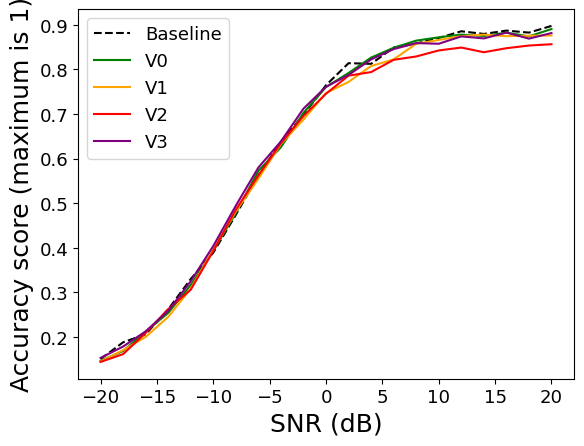

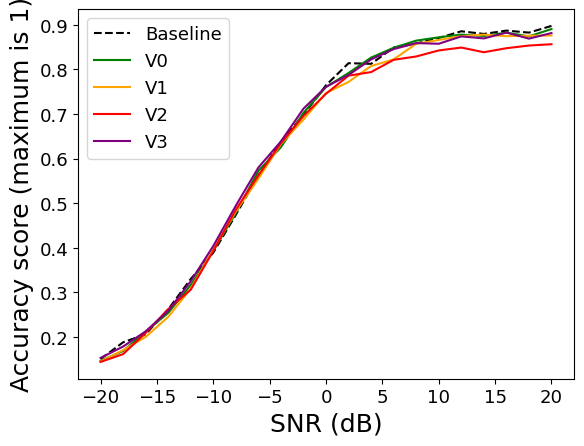

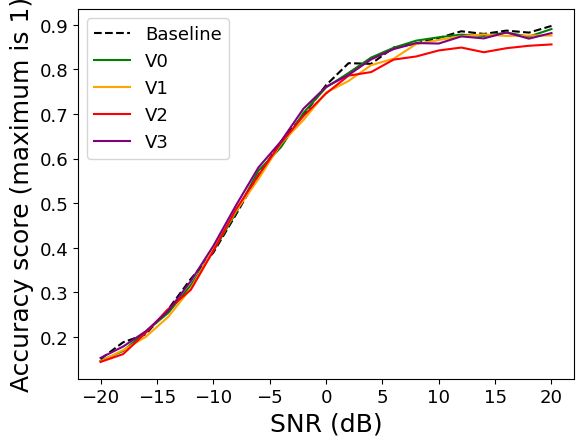

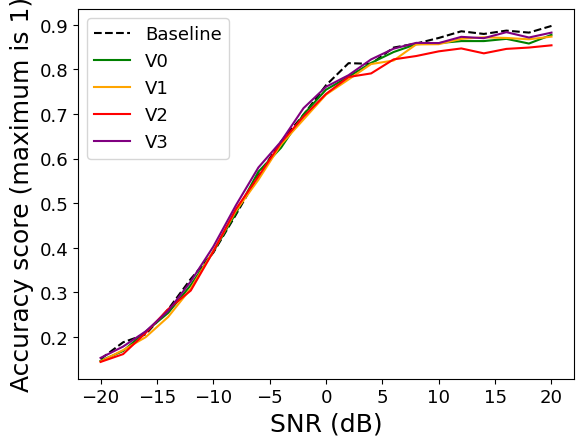

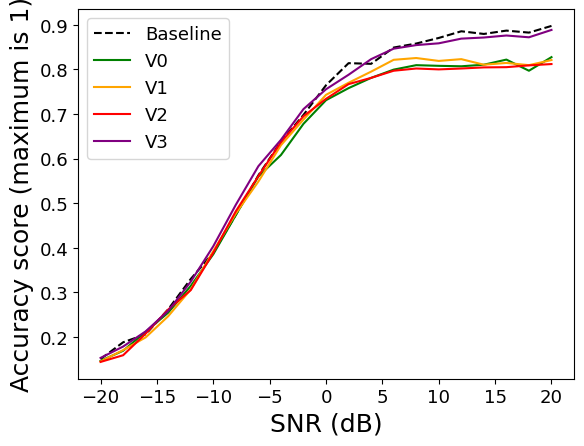

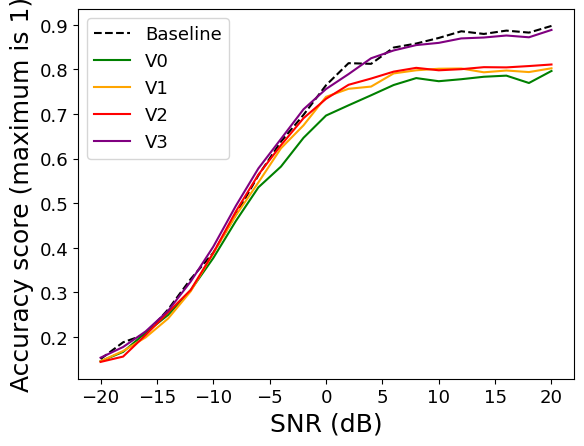

In [449]:
#thresholds = [0.01, 0.05, 0.15, 0.3, 0.4, 0.6]
figTitles = ['./TestFigures/accs/accuracy_all_T001.png', './TestFigures/accs/accuracy_all_T005.png', './TestFigures/accs/accuracy_all_T015.png',
             './TestFigures/accs/accuracy_all_T03.png','./TestFigures/accs/accuracy_all_T04.png','./TestFigures/accs/accuracy_all_T06.png']
for i in range(len(thresholds)):
    
    THRESHOLD = thresholds[i]
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(accuracies_test["Baseline"][0.05].values()), color = colors["baseline"], ls='--');
    plt.plot(xAxis, list(accuracies_test["V0"][THRESHOLD].values()), color = colors["V0"]);
    plt.plot(xAxis, list(accuracies_test["V1"][THRESHOLD].values()), color = colors["V1"]);
    plt.plot(xAxis, list(accuracies_test["V2"][THRESHOLD].values()), color = colors["V2"]);
    plt.plot(xAxis, list(accuracies_test["V3"][THRESHOLD].values()), color = colors["V3"]);
    plt.legend(["Baseline", "V0", "V1", "V2", "V3"], fontsize=13)
    plt.xlabel('SNR (dB)',fontsize=18)
    plt.ylabel('Accuracy score (maximum is 1)', fontsize=18)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
    plt.savefig(figTitles[i])
    plt.show()

## Accuracy at short branch

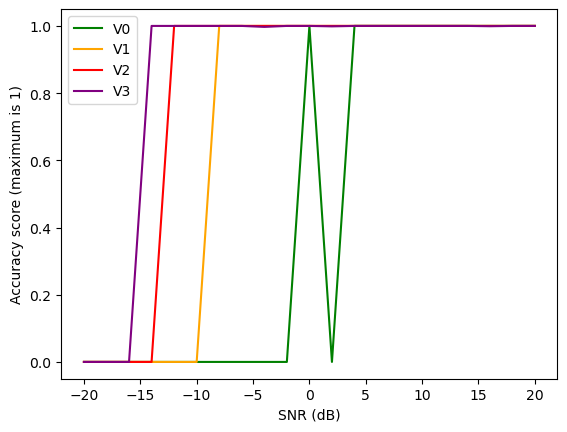

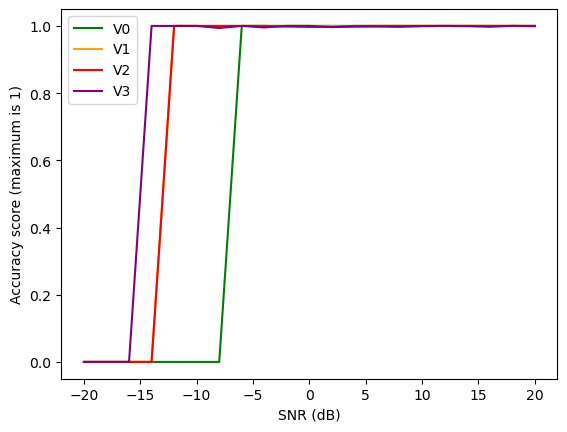

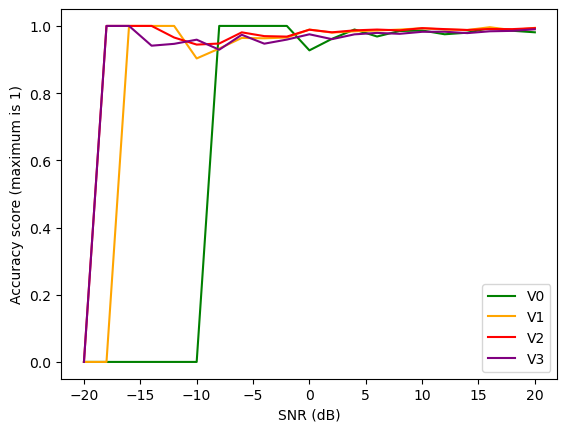

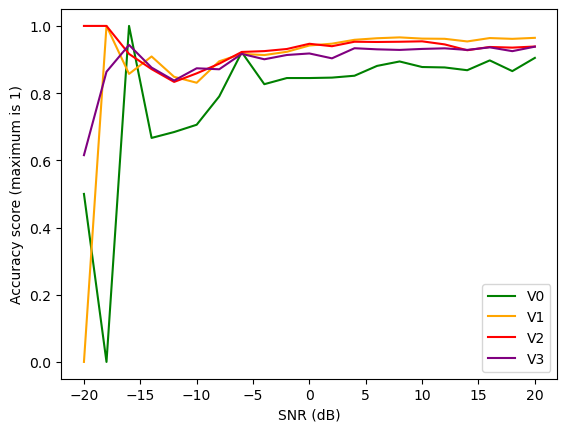

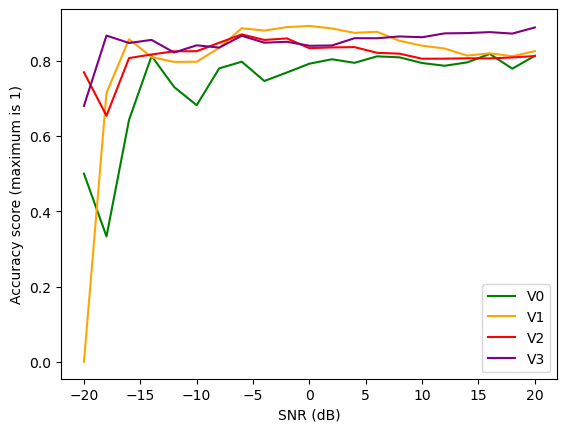

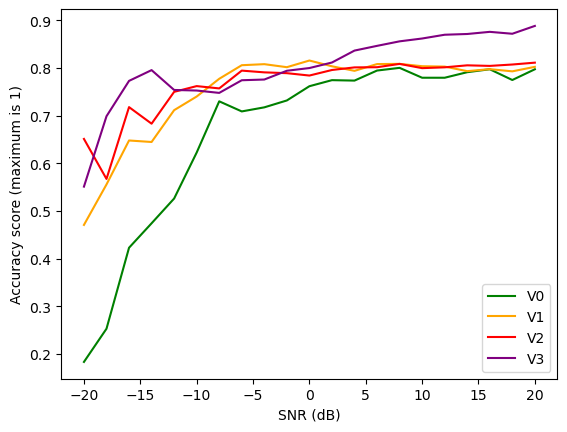

In [247]:
#thresholds = [0.01, 0.05, 0.15, 0.3, 0.4, 0.6]
figTitles = ['./TestFigures/accs/accuracy_short_T001.png', './TestFigures/accs/accuracy_short_T005.png', './TestFigures/accs/accuracy_short_T015.png',
             './TestFigures/accs/accuracy_short_T03.png','./TestFigures/accs/accuracy_short_T04.png','./TestFigures/accs/accuracy_short_T06.png']
for i in range(len(thresholds)):
    
    THRESHOLD = thresholds[i]
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(shortAccs_test["V0"][THRESHOLD].values()), color = colors["V0"]);
    plt.plot(xAxis, list(shortAccs_test["V1"][THRESHOLD].values()), color = colors["V1"]);
    plt.plot(xAxis, list(shortAccs_test["V2"][THRESHOLD].values()), color = colors["V2"]);
    plt.plot(xAxis, list(shortAccs_test["V3"][THRESHOLD].values()), color = colors["V3"]);
    plt.legend(["V0", "V1", "V2", "V3"])
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy score (maximum is 1)')
    #plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
    #plt.savefig(figTitles[i])
    plt.show()

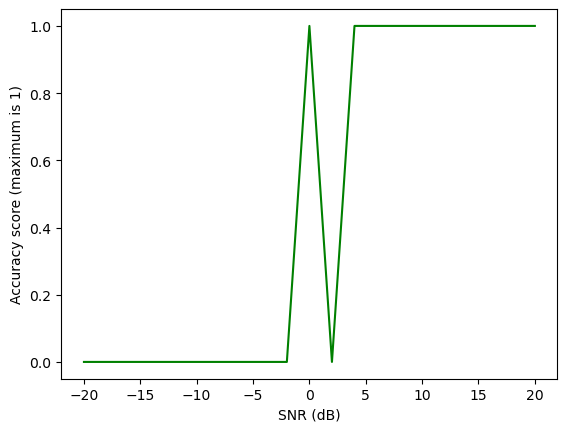

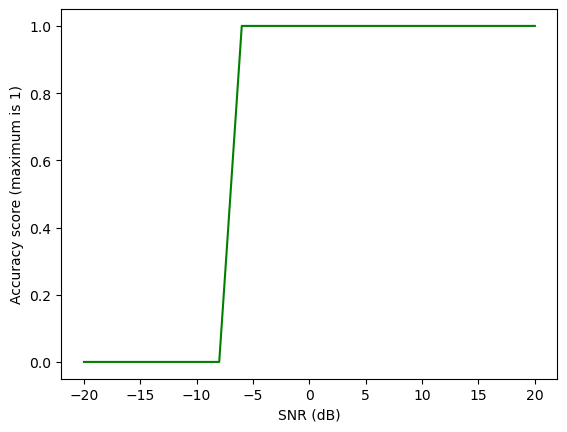

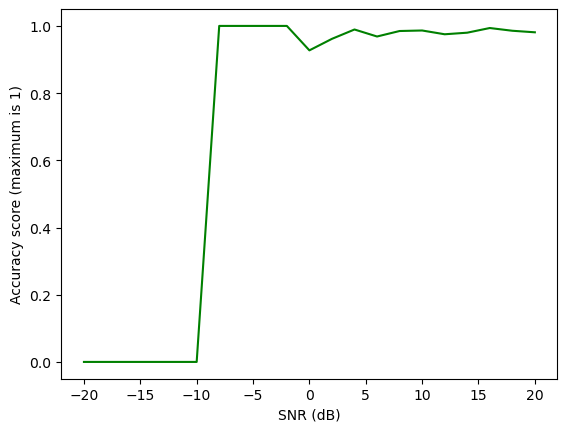

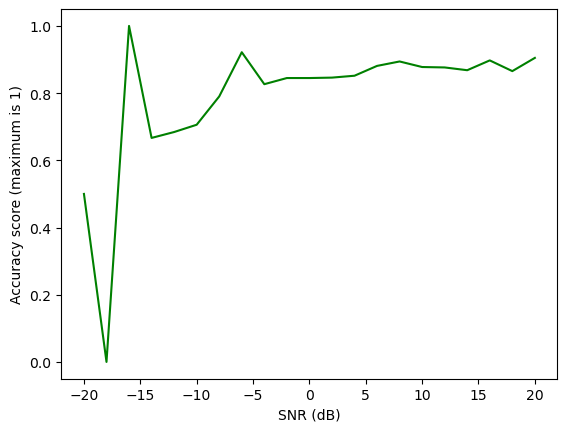

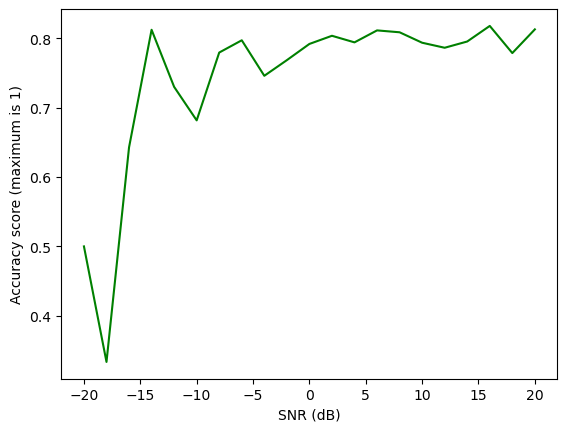

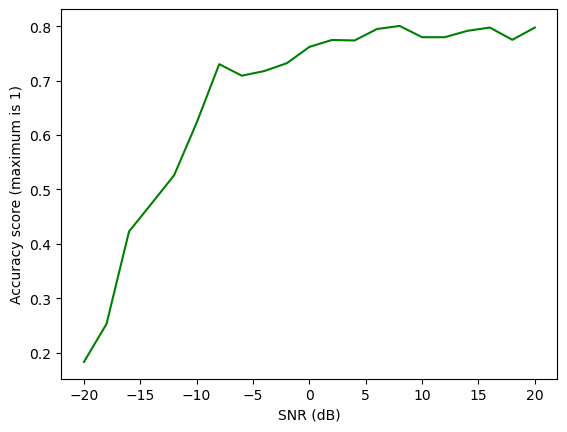

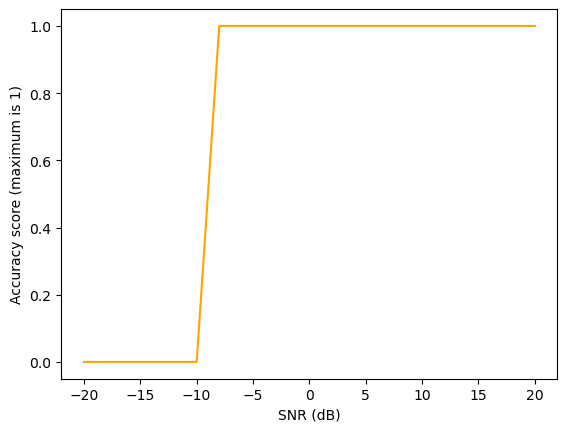

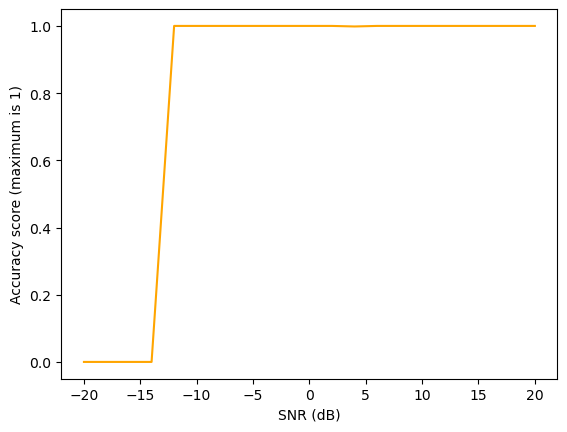

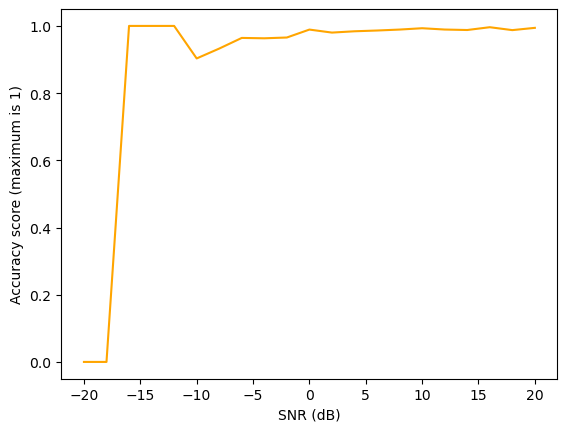

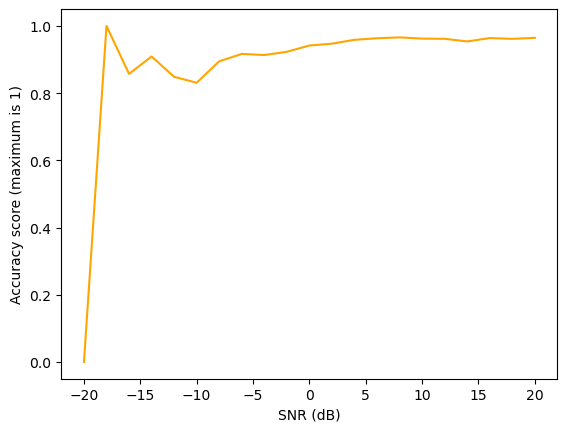

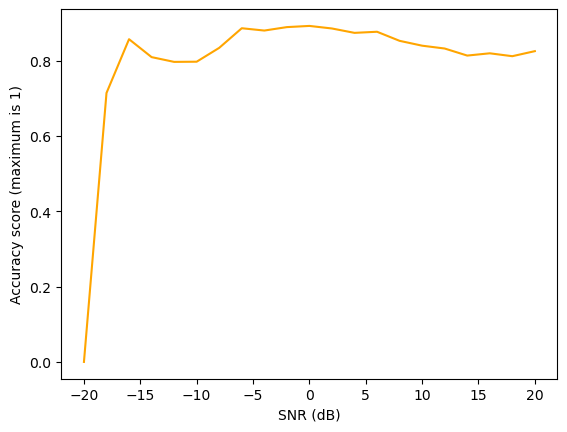

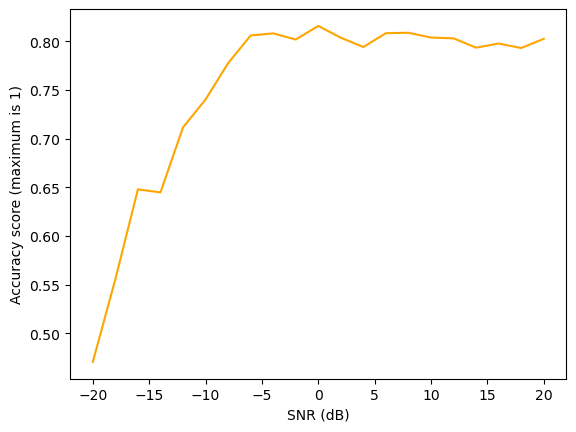

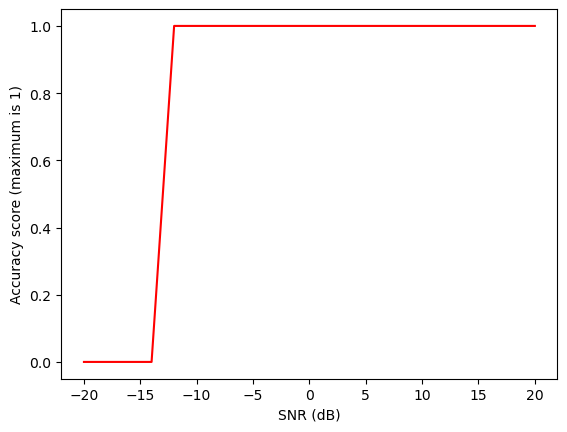

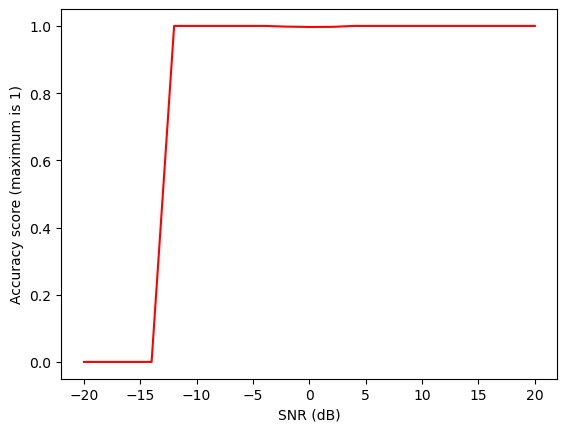

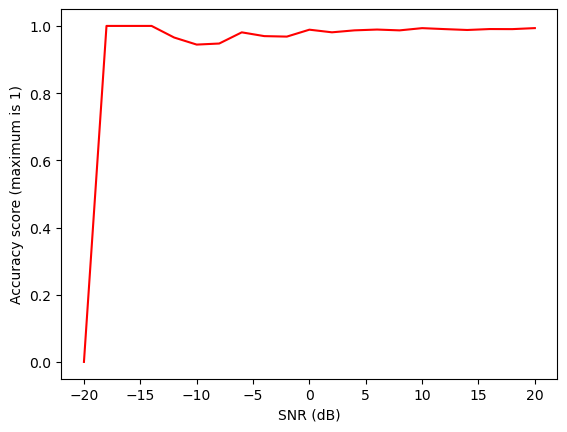

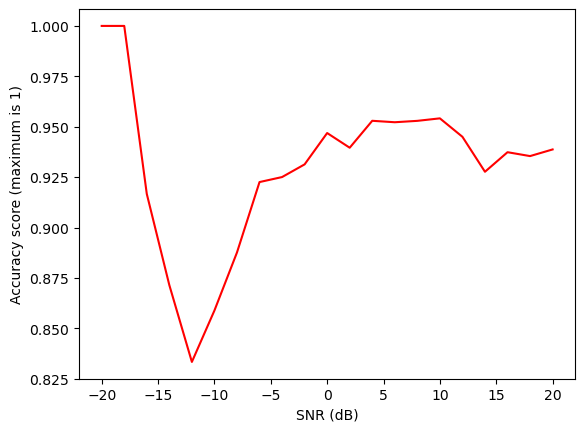

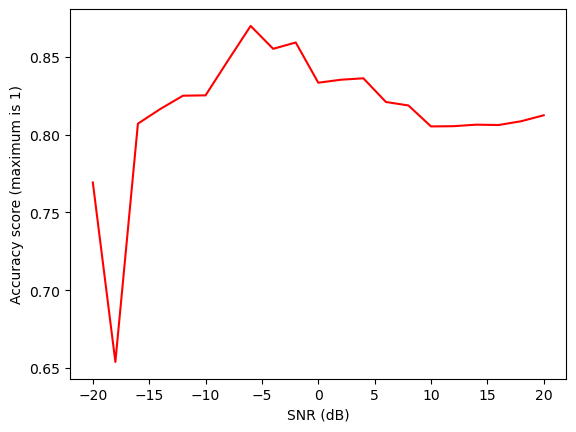

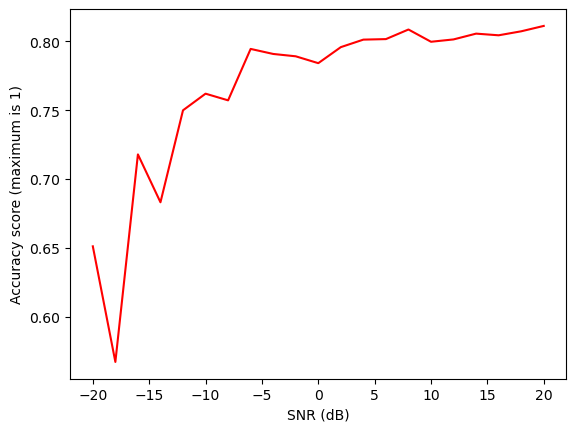

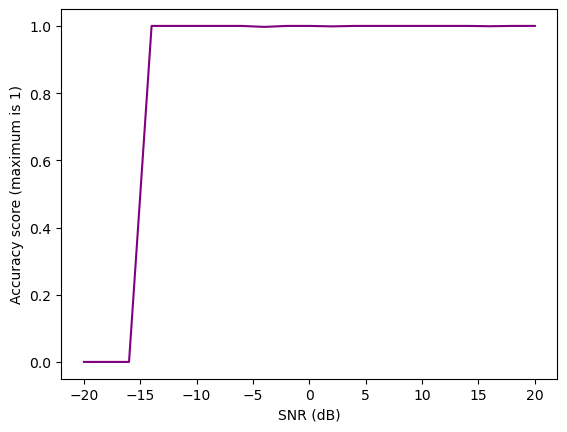

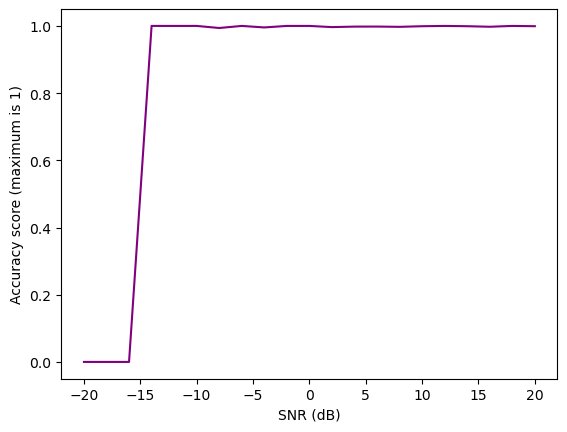

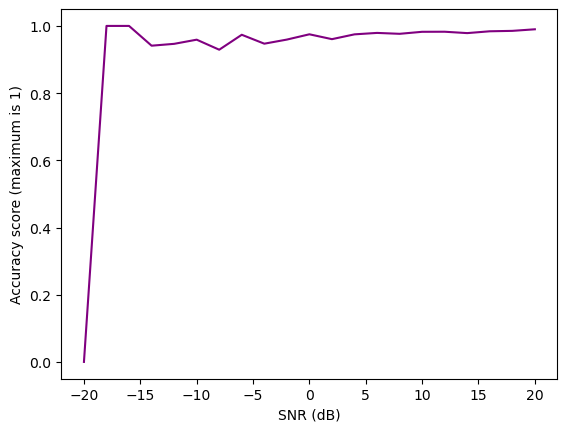

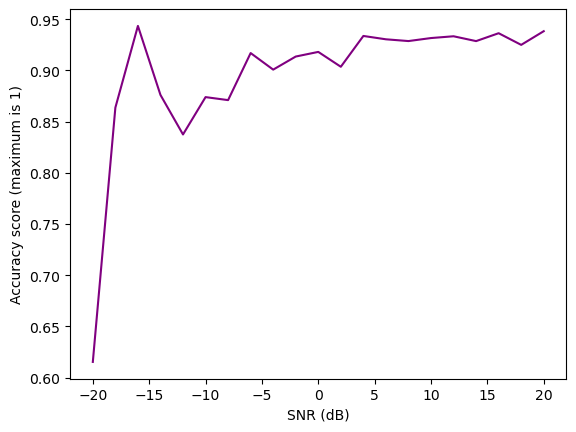

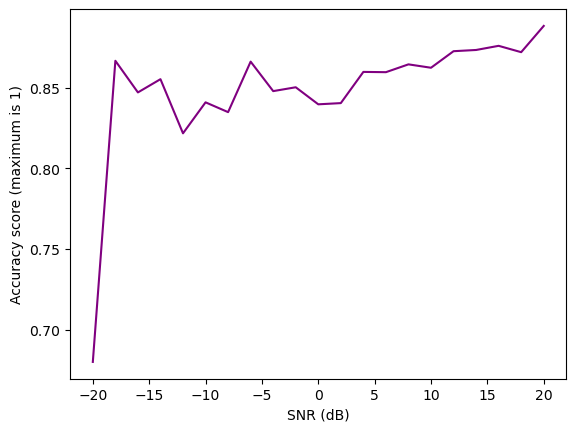

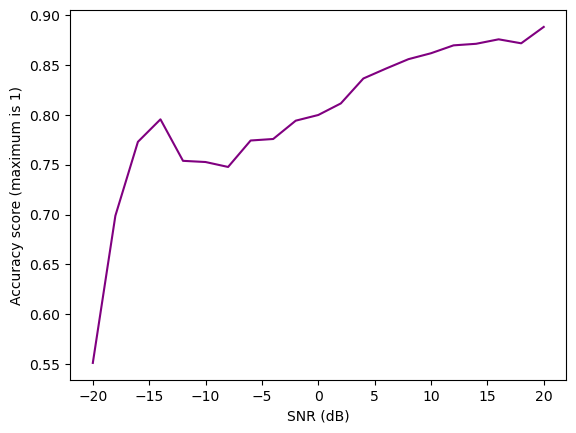

In [248]:
#thresholds = [0.01, 0.05, 0.15, 0.3, 0.4, 0.6]
# Only for certain V and T
figTitle = './TestFigures/accs/accuracy_short_{}_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']

for Version in ["V0", "V1", "V2", "V3"]:
    for i, THRESHOLD in enumerate(thresholds):

        fig = plt.Figure()

        xAxis = np.arange(-20, 21, 2) #SNRs
        plt.plot(xAxis, list(shortAccs_test[Version][THRESHOLD].values()), color = colors[Version]);
        
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy score (maximum is 1)')
        #plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
        #plt.savefig(figTitle.format(Version, thresholds_titles[i]))
        plt.show()

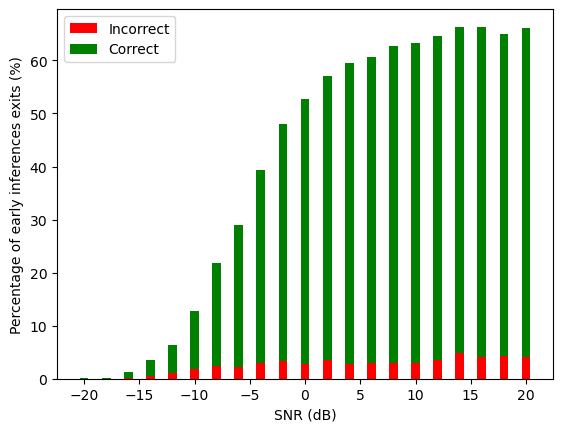

In [249]:
# Data
THRESHOLD = 0.3
Version = "V2"
figTitle = "./TestFigures/accs/bar_{}_T{}"
percentages = list(inferenceCounter_test[Version][THRESHOLD][0].values())
correct = list(shortAccs_test[Version][THRESHOLD].values())
correct_percentage = [correct[i] * percentages[i] for i in range(len(percentages))]
incorrect_percentage = [percentages[i] - correct_percentage[i] for i in range(len(percentages))]


# Set the figure size
fig = plt.Figure(figsize=(8, 6))

# Create the plot
plt.bar(xAxis, incorrect_percentage, label='Incorrect', color='red')
plt.bar(xAxis, correct_percentage, label='Correct', bottom=incorrect_percentage, color='green')

# Add legend and labels
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('Percentage of early inferences exits (%)')
plt.savefig(figTitle.format(Version, "03"))
plt.show()


## EE Inference

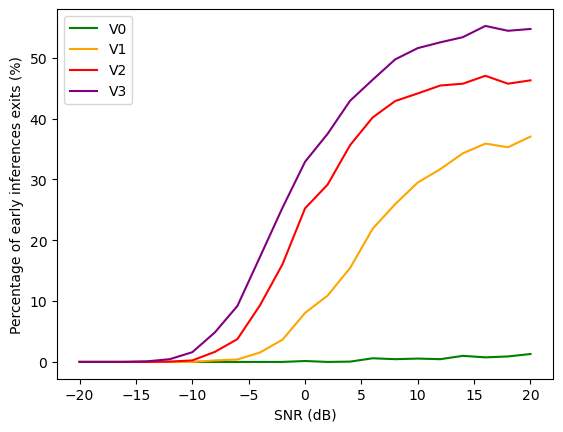

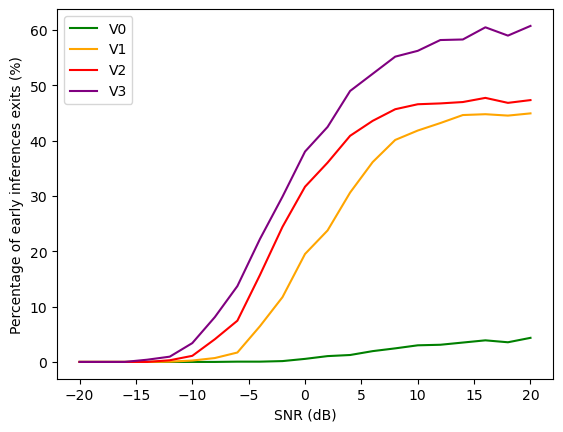

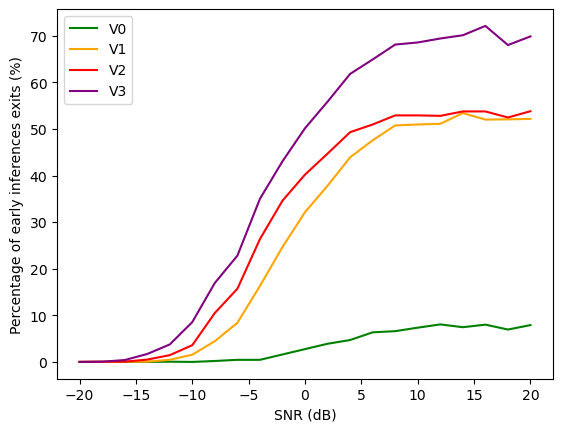

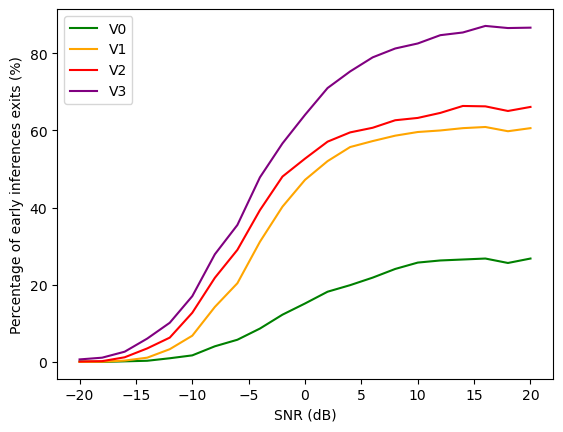

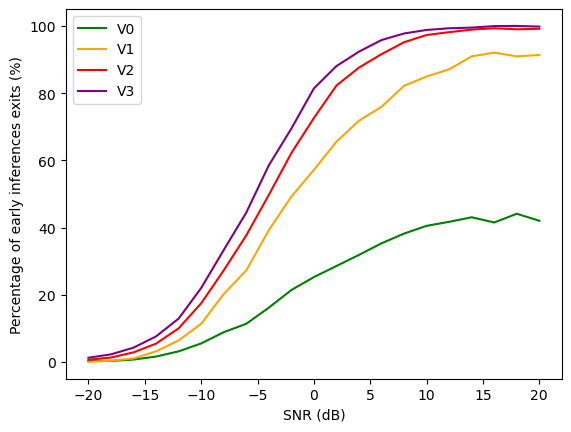

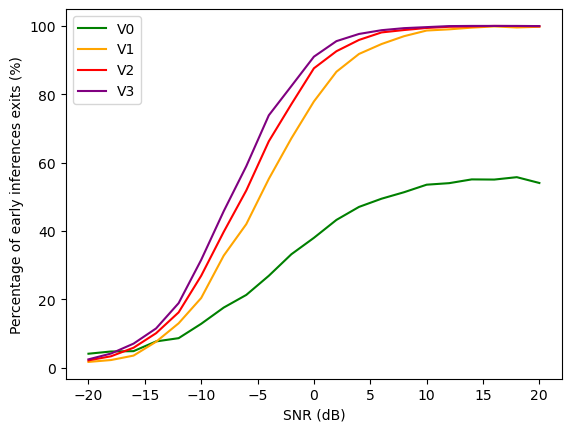

In [250]:
figTitle = './TestFigures/inference/diff_Versions/percent_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']

for i, THRESHOLD in enumerate(thresholds):
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(inferenceCounter_test["V0"][THRESHOLD][0].values()), color = colors["V0"])
    plt.plot(xAxis, list(inferenceCounter_test["V1"][THRESHOLD][0].values()), color = colors["V1"])
    plt.plot(xAxis, list(inferenceCounter_test["V2"][THRESHOLD][0].values()), color = colors["V2"])
    plt.plot(xAxis, list(inferenceCounter_test["V3"][THRESHOLD][0].values()), color = colors["V3"])

    plt.legend(["V0","V1", "V2", "V3"])
    plt.xlabel("SNR (dB)")
    plt.ylabel('Percentage of early inferences exits (%)')
    # Save the figure as a PNG file
    plt.savefig(figTitle.format(thresholds_titles[i]))
    plt.show()

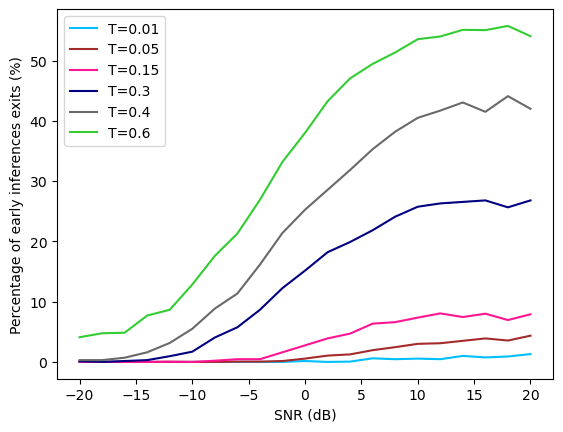

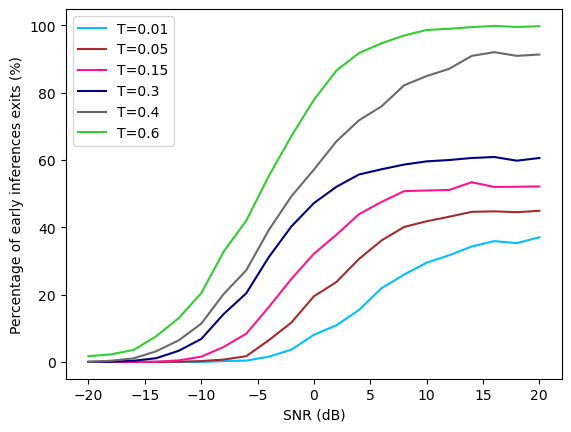

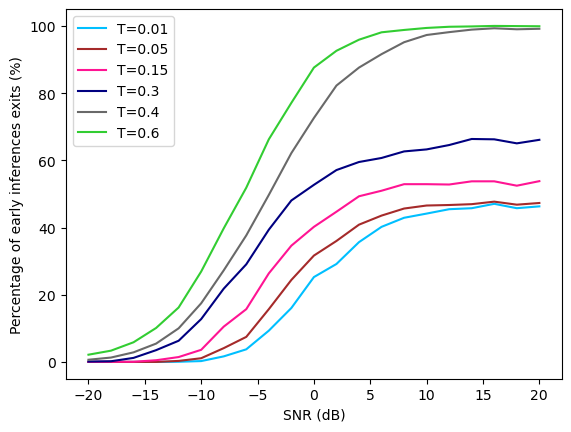

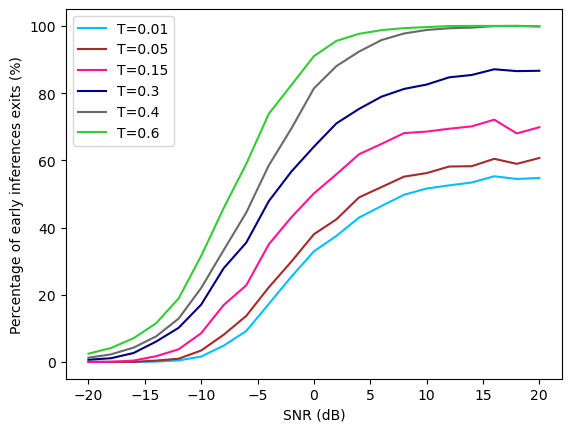

In [251]:
figTitle = './TestFigures/inference/diff_Thresholds/percent_{}.png'

for Version in ["V0", "V1", "V2", "V3"]:
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    for THRESHOLD in thresholds:
        plt.plot(xAxis, list(inferenceCounter_test[Version][THRESHOLD][0].values()), color = colors[THRESHOLD])

    plt.legend(["T=0.01", "T=0.05", "T=0.15", "T=0.3", "T=0.4", "T=0.6"])
    plt.xlabel("SNR (dB)")
    plt.ylabel('Percentage of early inferences exits (%)')
    # Save the figure as a PNG file
    plt.savefig(figTitle.format(Version))
    plt.show()

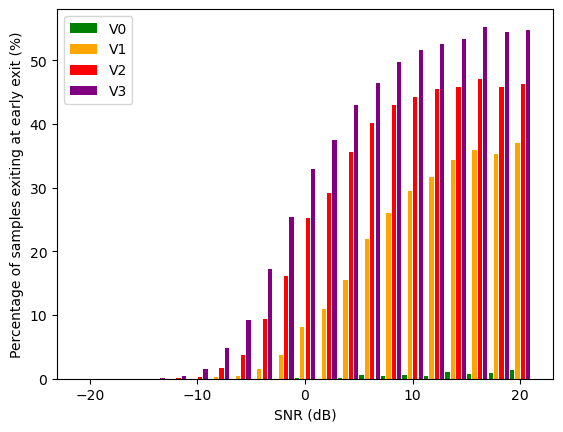

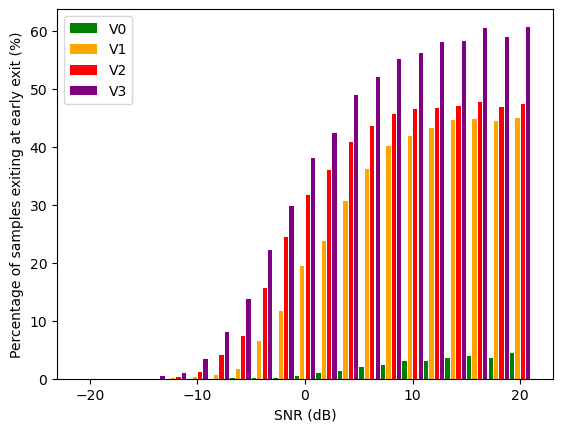

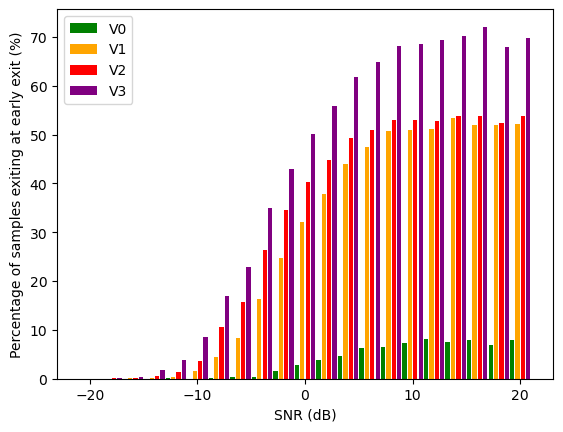

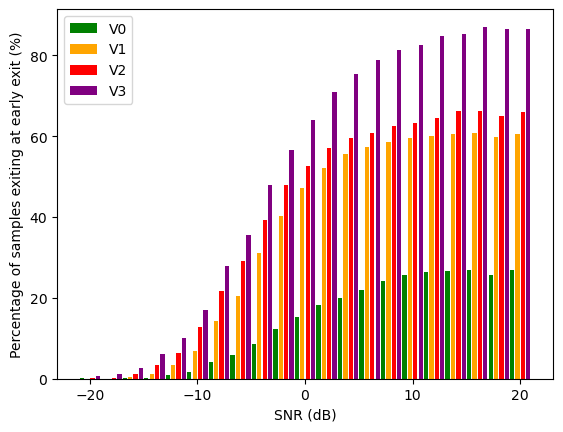

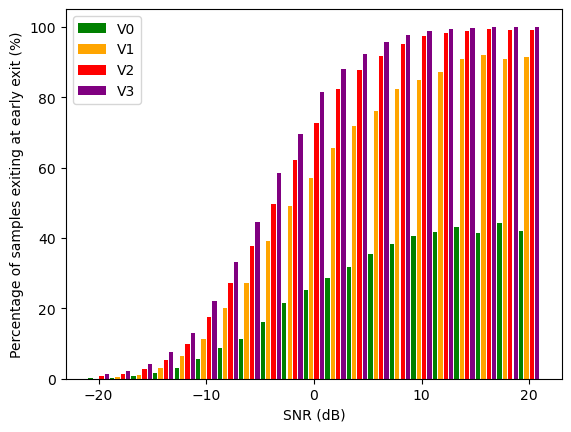

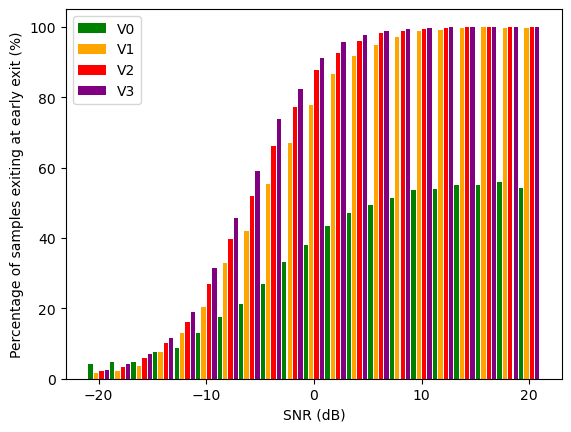

In [252]:
figTitle = './TestFigures/inference/bars/percent_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']
bar_width = 0.5 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

for i, THRESHOLD in enumerate(thresholds):

    data0 = list(inferenceCounter_test["V0"][THRESHOLD][0].values())
    data1 = list(inferenceCounter_test["V1"][THRESHOLD][0].values())
    data2 = list(inferenceCounter_test["V2"][THRESHOLD][0].values())
    data3 = list(inferenceCounter_test["V3"][THRESHOLD][0].values())

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot the data as grouped bars
    ax.bar(xAxis - 1.5*bar_width, data0, width=bar_width*0.8, label='V0', color = colors["V0"])
    ax.bar(xAxis - 0.5*bar_width, data1, width=bar_width*0.8, label='V1', color = colors["V1"])
    ax.bar(xAxis + 0.5*bar_width, data2, width=bar_width*0.8, label='V2', color = colors["V2"])
    ax.bar(xAxis + 1.5*bar_width, data3, width=bar_width*0.8, label='V3', color = colors["V3"])

    # Set the axis labels and title
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Percentage of samples exiting at early exit (%)')
    #ax.set_title('Grouped Bar Chart')

    # Add a legend
    ax.legend()

    # Save the figure as a PNG file
    fig.savefig(figTitle.format(thresholds_titles[i]))
    
    plt.show()


### Individuals

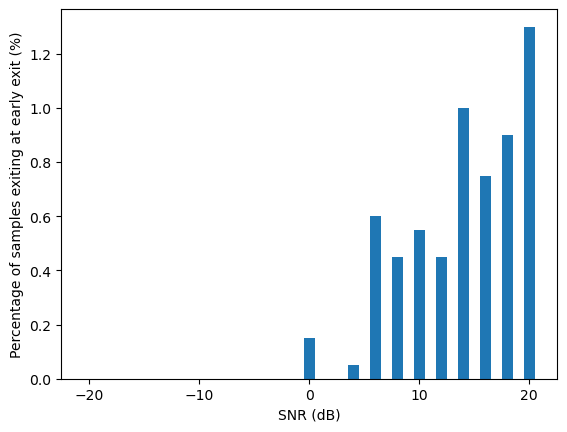

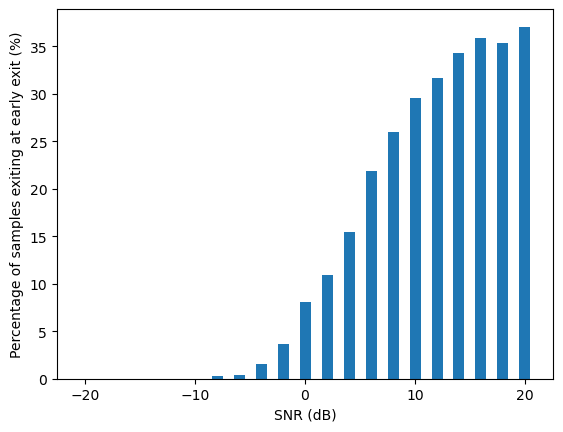

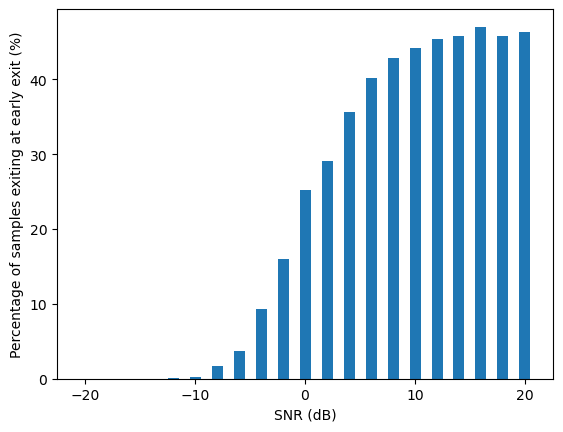

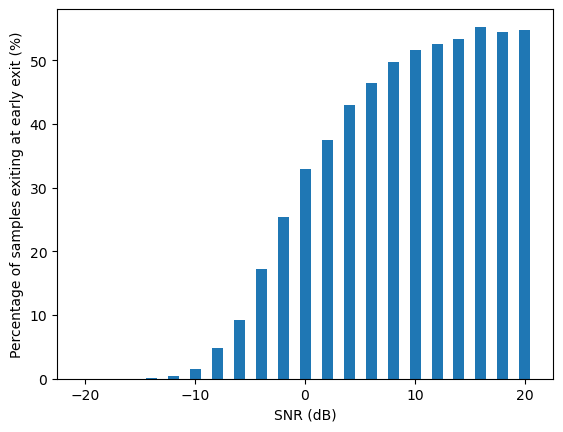

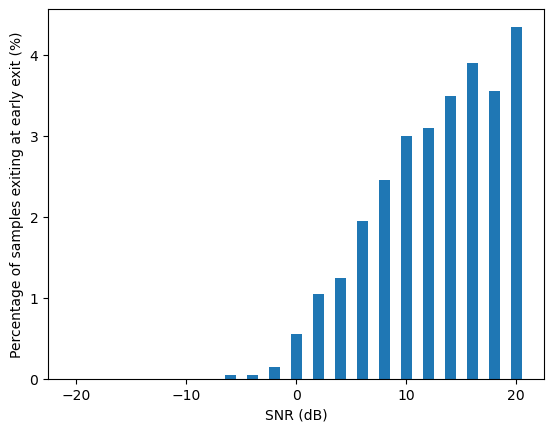

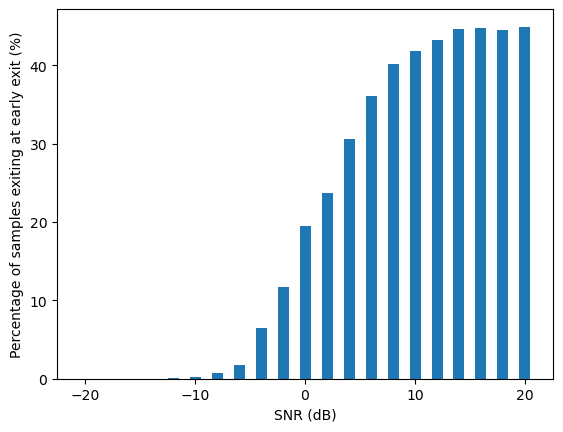

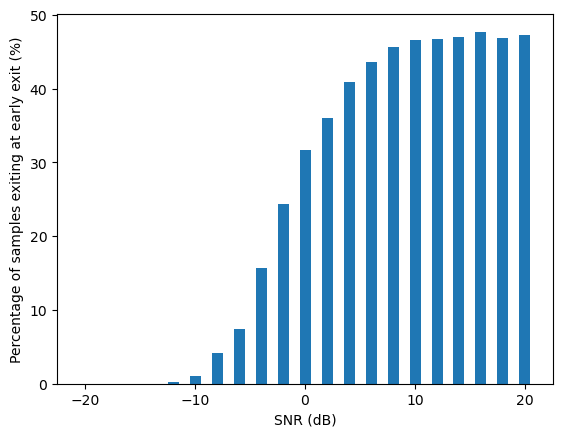

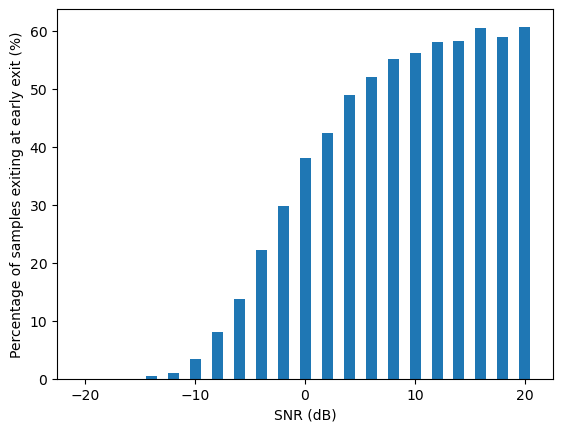

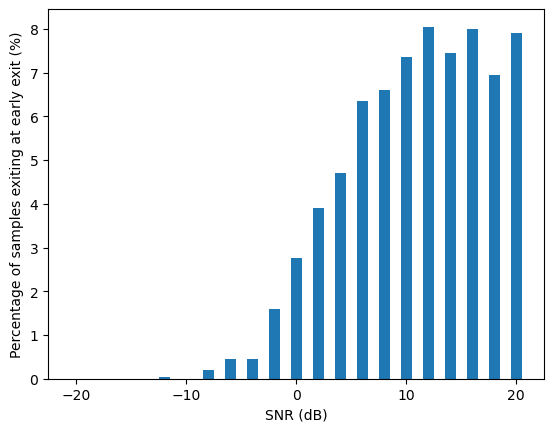

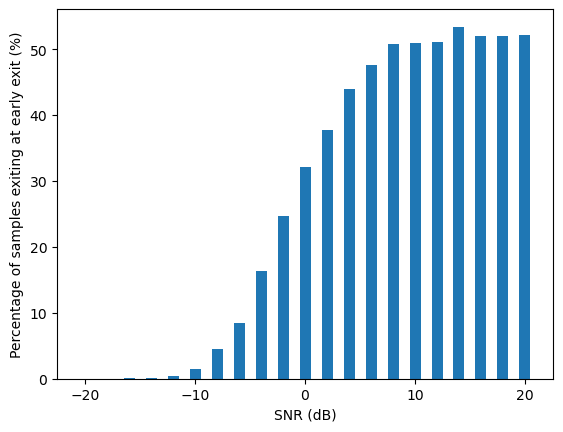

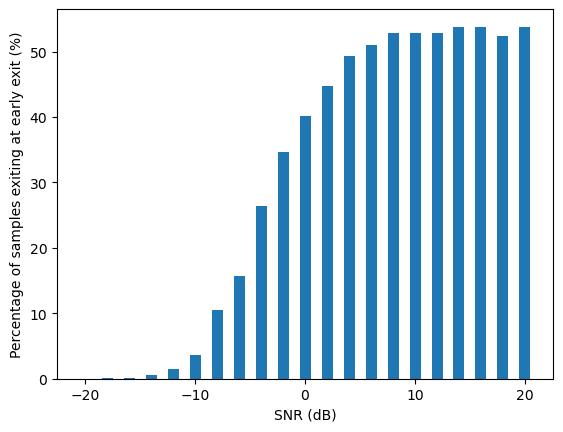

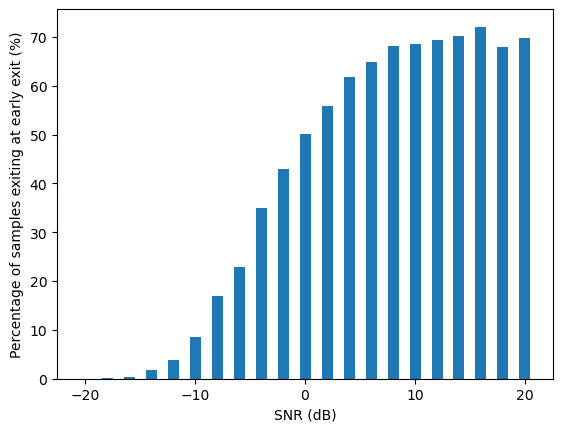

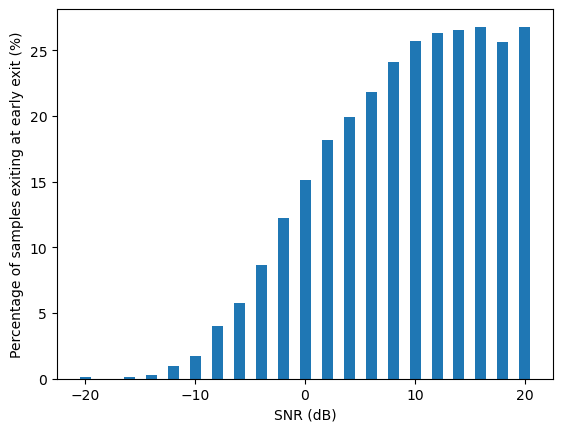

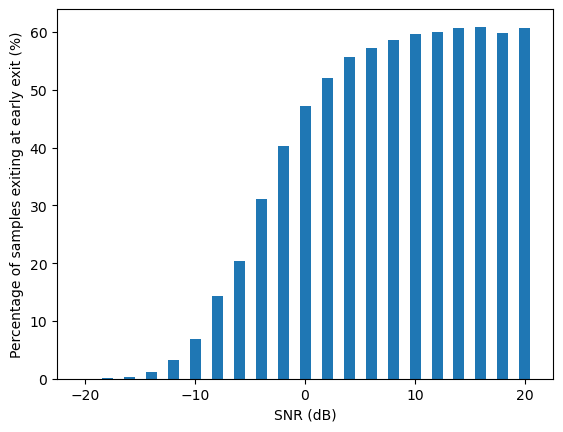

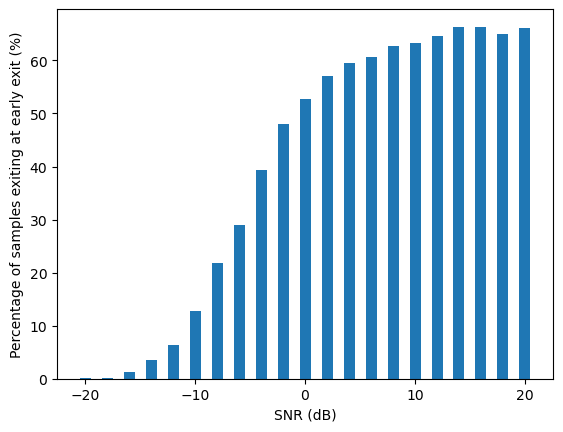

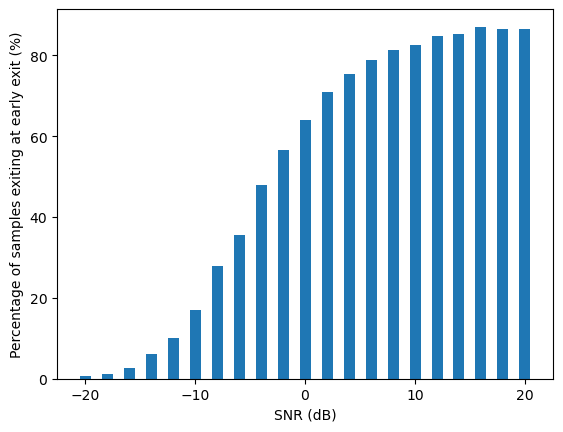

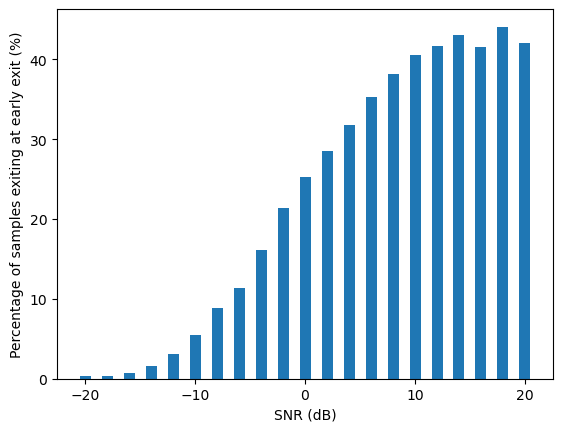

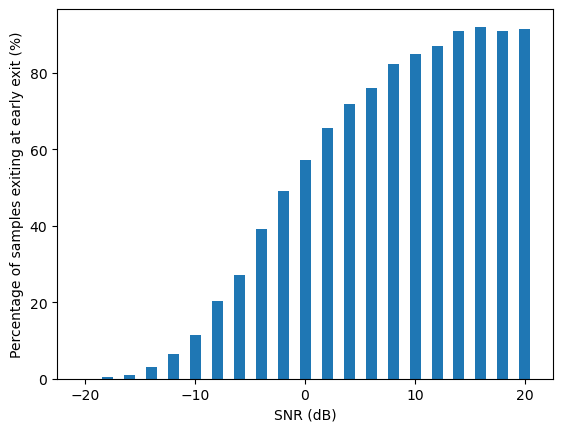

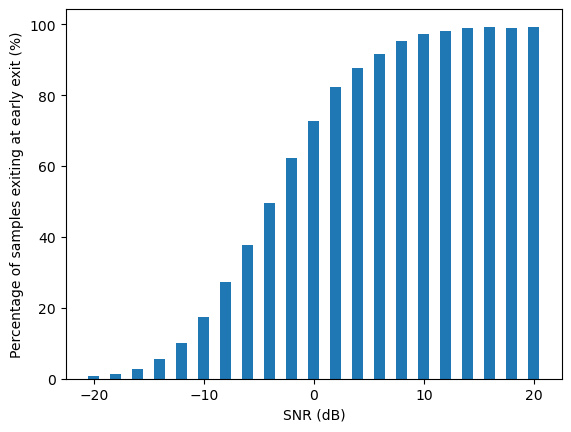

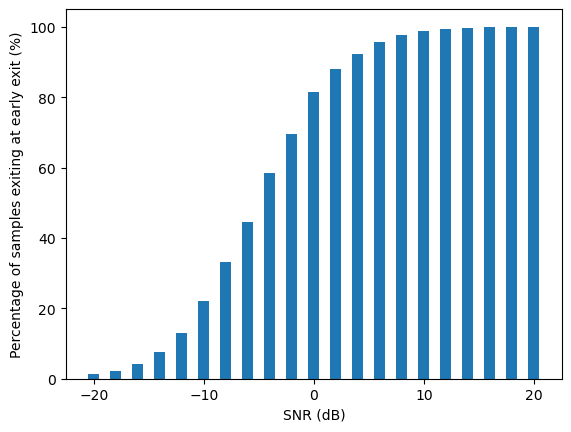

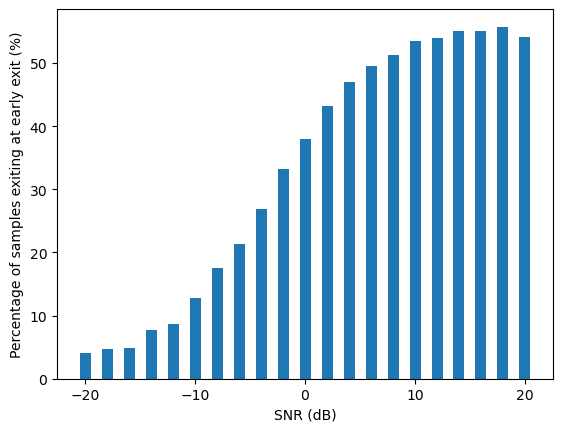

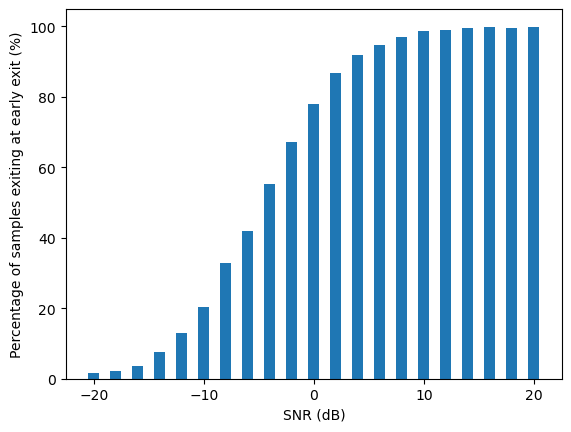

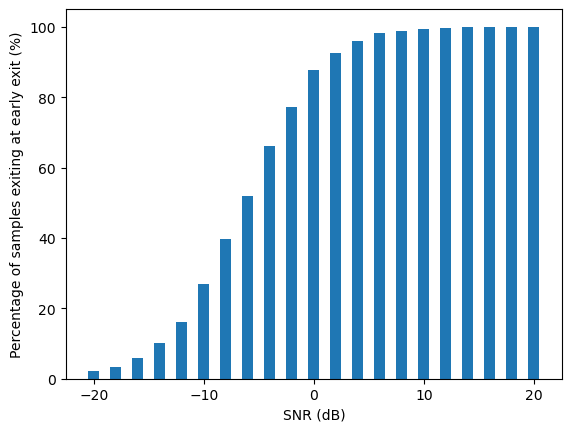

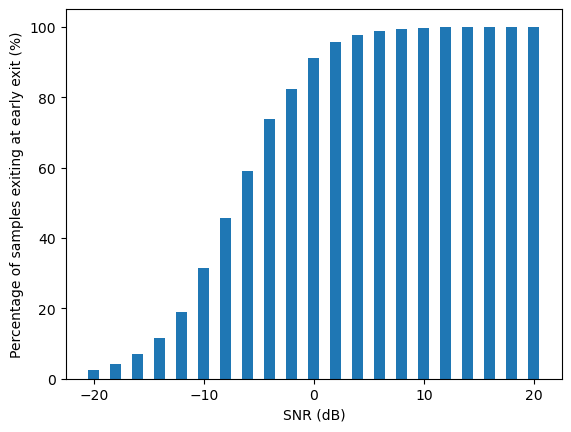

In [253]:
figTitle = './TestFigures/inference/individuals/percent_{}_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']
bar_width = 1.0 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

for i, THRESHOLD in enumerate(thresholds):
    for Version in ["V0", "V1", "V2", "V3"]:
        # Create a figure and axis object
        fig, ax = plt.subplots()

        # Plot the data as grouped bars
        ax.bar(xAxis, inferenceCounter_test[Version][THRESHOLD][0].values(), width=bar_width, label='short branch')

        # Set the axis labels and title
        ax.set_xlabel('SNR (dB)')
        ax.set_ylabel('Percentage of samples exiting at early exit (%)')

        # Show the plot
        plt.show()

        # Save the figure as a PNG file
        fig.savefig(figTitle.format(Version, thresholds_titles[i]))

## Inference Times

In [254]:
Versions_times_test = {x:{"short": 0, "long":0} for x in ["V0", "V1", "V2", "V3"]}


v0_short, v1_short, v2_short, v3_short = 0, 0, 0, 0
v0_long, v1_long, v2_long, v3_long = 0, 0, 0, 0
N = 200
for _ in range(N):
    # V0
    start_time = time.time()
    infer_short(eeNet_V0, input_)
    v0_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V0, input_)
    v0_long += time.time() - start_time
        
    # V1
    start_time = time.time()
    infer_short(eeNet_V1, input_)
    v1_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V1, input_)
    v1_long += time.time() - start_time
        
    # V2
    start_time = time.time()
    infer_short(eeNet_V2, input_)
    v2_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V2, input_)
    v2_long += time.time() - start_time
        
    # V3
    start_time = time.time()
    infer_short(eeNet_V3, input_)
    v3_short += time.time() - start_time
            
    start_time = time.time()
    infer_long(eeNet_V3, input_)
    v3_long += time.time() - start_time
        

    Versions_times_test["V0"]["short"], Versions_times_test["V1"]["short"], Versions_times_test["V2"]["short"], Versions_times_test["V3"]["short"] = v0_short/N, v1_short/N, v2_short/N, v3_short/N
    Versions_times_test["V0"]["long"], Versions_times_test["V1"]["long"], Versions_times_test["V2"]["long"], Versions_times_test["V3"]["long"] = v0_long/N, v1_long/N, v2_long/N, v3_long/N

Versions_times_test     

{'V0': {'short': 0.0006881427764892579, 'long': 0.0009381496906280518},
 'V1': {'short': 0.0007401514053344727, 'long': 0.0010511767864227295},
 'V2': {'short': 0.0009570014476776123, 'long': 0.001440674066543579},
 'V3': {'short': 0.0012570154666900635, 'long': 0.0011228621006011963}}

In [255]:
avg_longTime_test = sum(Versions_times_test[x]["long"] for x in ["V0", "V1", "V2", "V3"])/4
avg_longTime_test

# Baseline Inference Time
bl_time_test = 2000*avg_longTime_test
bl_time_test

2.2764313220977783

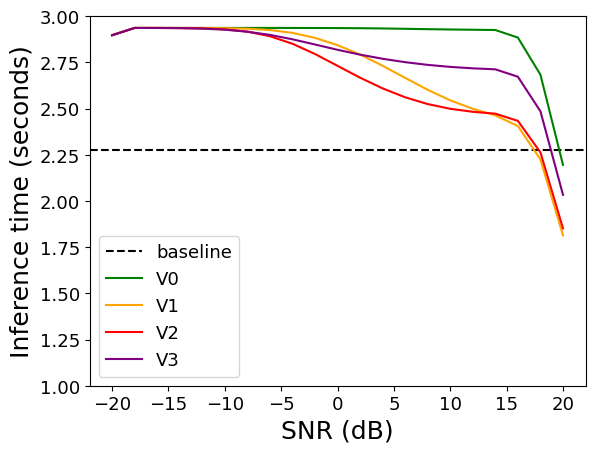

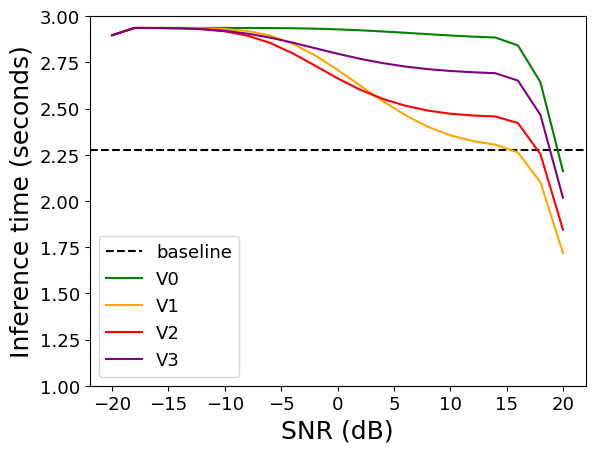

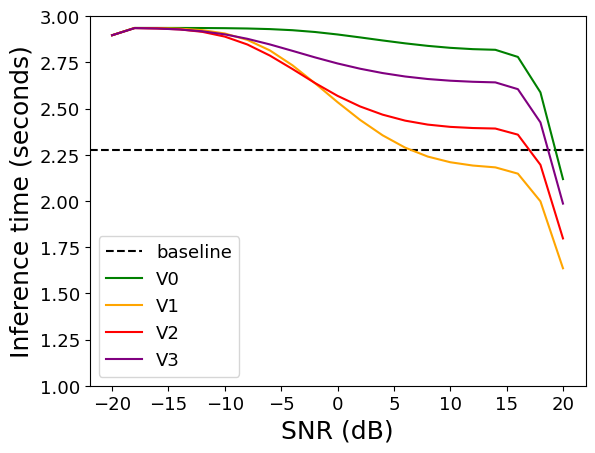

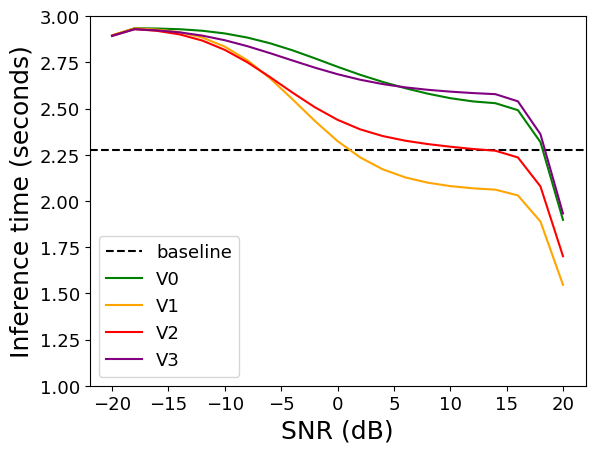

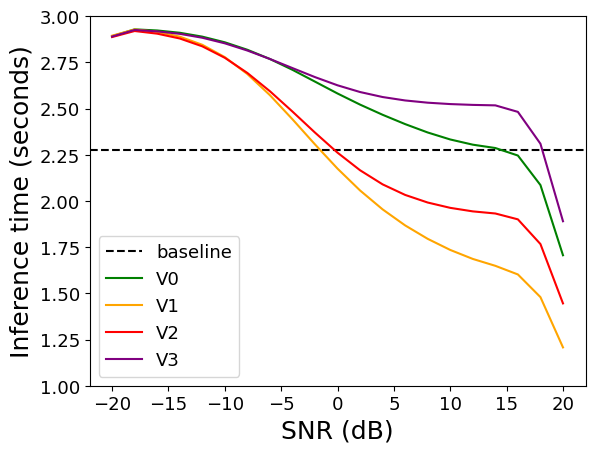

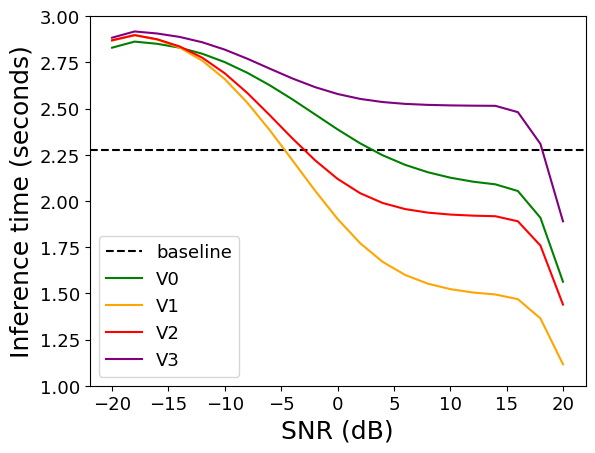

In [448]:
figTitle = './TestFigures/time/diff_Versions/times_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '04', '06']
dbl_calc_time = 0.00020662546157836914
xAxis = np.arange(-20, 21, 2) #SNRs

finalTimes_test = {x: {v:{snrV: 0 for snrV in stringSNRs} for v in ["V0", "V1", "V2", "V3"]} for x in thresholds}
for i, THRESHOLD in enumerate(thresholds):
 
    for Version in ["V0", "V1", "V2", "V3"]:
        for snrV in stringSNRs:
            short_percentage = inferenceCounter_test[Version][THRESHOLD][0][snrV]
            long_percentage = inferenceCounter_test[Version][THRESHOLD][1][snrV]
            shortTime = int(short_percentage*2000/100)*Versions_times_test[Version]['short'] 

            longTime = int(long_percentage*2000/100)*(avg_longTime+dbl_calc_time)  
            #longTime += int(long_percentage*1800/100)*dbl_calc_time

            finalTimes_test[THRESHOLD][Version][snrV] = shortTime + longTime
    
    #fig = plt.Figure()
    fig, ax = plt.subplots()
    # Add the vertical line
    plt.axhline(y=bl_time_test, color=colors["baseline"], ls='--')
    
    # V0
    x, y_0 = smoothing(xAxis, list(finalTimes_test[THRESHOLD]['V0'].values()))
    plt.plot(xAxis, y_0[3:], color = colors["V0"])
    # V1
    x, y_1 = smoothing(xAxis, list(finalTimes_test[THRESHOLD]['V1'].values()))
    plt.plot(xAxis, y_1[3:], color = colors["V1"])
    # V2
    x, y_2 = smoothing(xAxis, list(finalTimes_test[THRESHOLD]['V2'].values()))
    plt.plot(xAxis, y_2[3:], color = colors["V2"])
    # V3
    x, y_3 = smoothing(xAxis, list(finalTimes_test[THRESHOLD]['V3'].values()))
    plt.plot(xAxis, y_3[3:], color = colors["V3"])

    

    plt.legend(["baseline", "V0", "V1", "V2", "V3"], fontsize=13)
    plt.xlabel("SNR (dB)", fontsize=18)
    plt.ylabel("Inference time (seconds)", fontsize=18)
    plt.ylim(1, 3)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()
    fig.savefig(figTitle.format(thresholds_titles[i]))

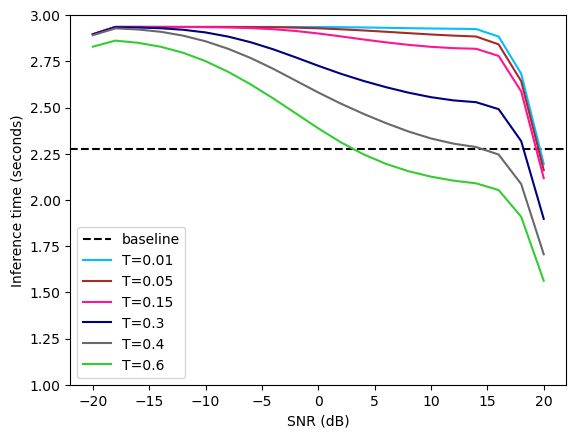

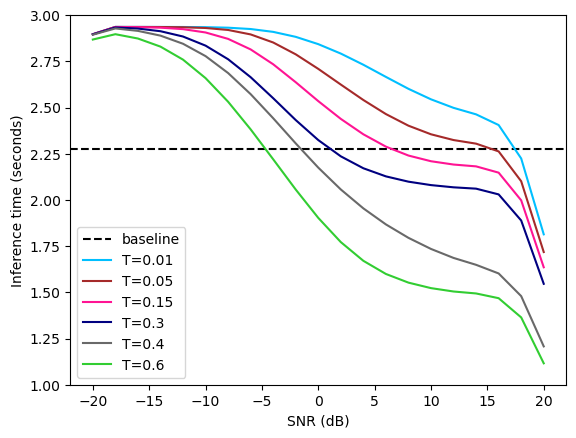

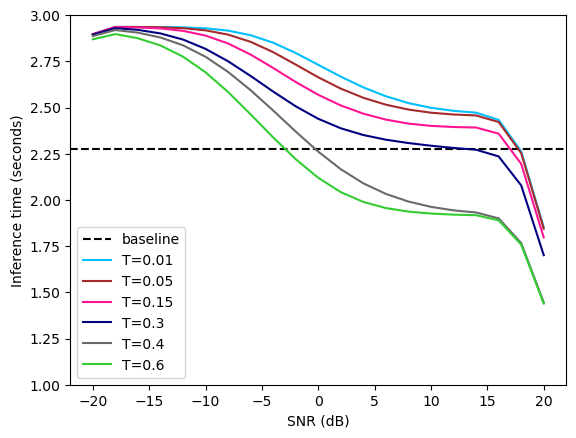

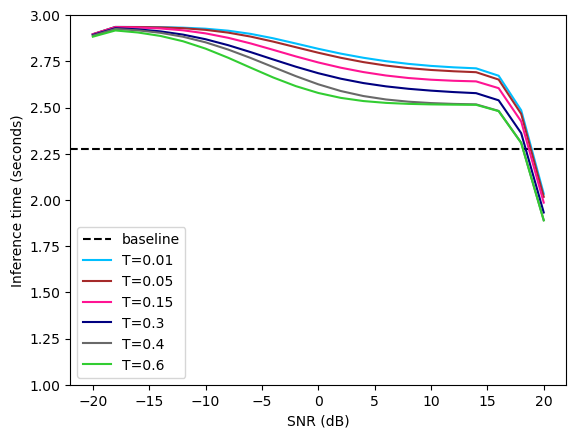

In [323]:
figTitle = './TestFigures/time/diff_Thresholds/times_{}.png'
dbl_calc_time = 0.00020662546157836914
xAxis = np.arange(-20, 21, 2) #SNRs

finalTimes_test2 = {x: {THRESHOLD:{snrV: 0 for snrV in stringSNRs} for THRESHOLD in thresholds} for x in ["V0", "V1", "V2", "V3"]}
for Version in ["V0", "V1", "V2", "V3"]:

    for i, THRESHOLD in enumerate(thresholds):
        for snrV in stringSNRs:
            short_percentage = inferenceCounter_test[Version][THRESHOLD][0][snrV]
            long_percentage = inferenceCounter_test[Version][THRESHOLD][1][snrV]

            shortTime = int(short_percentage*2000/100)*Versions_times_test[Version]['short'] 

            longTime = int(long_percentage*2000/100)*(avg_longTime+dbl_calc_time)  
            #longTime += long_percentage*len(valLoader)*dbl_calc_time

            finalTimes_test2[Version][THRESHOLD][snrV] = shortTime + longTime
    
    #fig = plt.Figure()
    fig, ax = plt.subplots()
    # Add the vertical line
    plt.axhline(y=bl_time_test, color='black', ls='--')
    
    # T=0.01
    x, y_0 = smoothing(xAxis, list(finalTimes_test2[Version][0.01].values()))
    plt.plot(xAxis, y_0[3:], color = colors[0.01])
    # T=0.05
    x, y_1 = smoothing(xAxis, list(finalTimes_test2[Version][0.05].values()))
    plt.plot(xAxis, y_1[3:], color = colors[0.05])
    # T = 0.15
    x, y_2 = smoothing(xAxis, list(finalTimes_test2[Version][0.15].values()))
    plt.plot(xAxis, y_2[3:], color = colors[0.15])
    # T = 0.3
    x, y_3 = smoothing(xAxis, list(finalTimes_test2[Version][0.3].values()))
    plt.plot(xAxis, y_3[3:], color = colors[0.3])
    # T = 0.4
    x, y_4 = smoothing(xAxis, list(finalTimes_test2[Version][0.4].values()))
    plt.plot(xAxis, y_4[3:], color = colors[0.4])
    # T = 0.6
    x, y_5 = smoothing(xAxis, list(finalTimes_test2[Version][0.6].values()))
    plt.plot(xAxis, y_5[3:], color = colors[0.6])
    
    
    plt.legend(["baseline", "T=0.01", "T=0.05", "T=0.15", "T=0.3", "T=0.4", "T=0.6"])
    plt.xlabel("SNR (dB)")
    plt.ylabel("Inference time (seconds)")
    
    plt.ylim(1, 3)
    plt.show()
    fig.savefig(figTitle.format(Version))

# Checking Numbers

In [ ]:
accuracies2
inferenceCounter2
shortAccs

In [335]:
bl_time_test

2.2764313220977783

####  V2

In [309]:
SNR, THRE = "20", 0.15
BL_acc = accuracies_test["Baseline"][0.05][SNR]

V0_acc = accuracies_test["V0"][THRE][SNR]
print("V0: {:.03f}".format(100*(BL_acc-V0_acc)))
V1_acc = accuracies_test["V1"][THRE][SNR]
print("V1: {:.03f}".format(100*(BL_acc-V1_acc)))
V2_acc = accuracies_test["V2"][THRE][SNR]
print("V2: {:.03f}".format(100*(BL_acc-V2_acc)))
V3_acc = accuracies_test["V3"][THRE][SNR]
print("V3: {:.03f}".format(100*(BL_acc-V3_acc)))

V0: 0.700
V1: 2.150
V2: 4.150
V3: 1.600


In [314]:
for Version in ["V0", "V1", "V2", "V3"]:
    time = finalTimes_test[THRE][Version][SNR]
    Ratio = (bl_time_test-time)/bl_time_test*100
    print("{}: {:.03f}".format(Version, Ratio))
    #print("{}: {:.03f}".format(Version, (bl_time_test-time)))

V0: 123.565
V1: 95.628
V2: 104.823
V3: 116.028


In [307]:
1.5/2.75

0.5454545454545454

# New Test Results

In [317]:
accuracies_test_035 = {typ: {thre:{y: 0 for y in stringSNRs} for thre in [0.35]} for typ in ["Baseline", "V0", "V1", "V2", "V3"]}
inferenceCounter_test_035= {y: {thre: {x: {snr: 0 for snr in stringSNRs} for x in range(nBranches)} for thre in [0.35]} for y in ["V0", "V1", "V2", "V3"]}
shortAccs_test_035 = {V:{thre: {y: 0 for y in stringSNRs} for thre in [0.35]} for V in ["V0", "V1", "V2", "V3"]}
# Getting TRAIN data with differebt SNRs values in dB
for snr in stringSNRs:
    
    tmpData = np.array([testXs[i] for i in range(len(testLabels)) if testLabels[i][1]==snr])
    tmpLabels = np.array([testLabels[i][0] for i in range(len(testLabels)) if testLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    

    bl_Acc = 0
    
#     with torch.no_grad():
#             blNet.eval()
#             for data, labels in tmpLoader:
#                 data, labels = data.to(device), labels.to(device)
#                 # Long
#                 outputs = blNet(data)
#                 _, preds = torch.max(outputs, 1)
#                 bl_Acc += accuracy_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())     
                
#             bl_Acc = bl_Acc/len(tmpLoader)
            
#             accuracies_test["Baseline"][0.05][snr] = bl_Acc  # 0.01 is just a placeholder..
    
    # Early Exiting
    thresholds2 = [0.35]
    for thre in thresholds2:
        recorder_V0, _, eeAcc_V0 = EE_V0.infer(tmpLoader, threshold=thre)
        accuracies_test_035["V0"][thre][snr] = eeAcc_V0
        if len(recorder_V0[0]) > 0:
            shortAccs_test_035["V0"][thre][snr] = sum(recorder_V0[0])/len(recorder_V0[0])
        
        recorder_V1, _, eeAcc_V1 = EE_V1.infer(tmpLoader, threshold=thre)
        accuracies_test_035["V1"][thre][snr] = eeAcc_V1
        if len(recorder_V1[0]) > 0:
            shortAccs_test_035["V1"][thre][snr] = sum(recorder_V1[0])/len(recorder_V1[0])

        recorder_V2, _, eeAcc_V2 = EE_V2.infer(tmpLoader, threshold=thre)
        accuracies_test_035["V2"][thre][snr] = eeAcc_V2
        if len(recorder_V2[0]) > 0:
            shortAccs_test_035["V2"][thre][snr] = sum(recorder_V2[0])/len(recorder_V2[0])
        
        recorder_V3, _, eeAcc_V3 = EE_V3.infer(tmpLoader, threshold=thre)
        accuracies_test_035["V3"][thre][snr] = eeAcc_V3
        if len(recorder_V3[0]) > 0:
            shortAccs_test_035["V3"][thre][snr] = sum(recorder_V3[0])/len(recorder_V3[0])

    
        for i in range(nBranches):
            inferenceCounter_test_035["V0"][thre][i][snr] = len(recorder_V0[i])/(len(recorder_V0[0])+len(recorder_V0[1]))*100
            inferenceCounter_test_035["V1"][thre][i][snr] = len(recorder_V1[i])/(len(recorder_V1[0])+len(recorder_V1[1]))*100 
            inferenceCounter_test_035["V2"][thre][i][snr] = len(recorder_V2[i])/(len(recorder_V2[0])+len(recorder_V2[1]))*100
            inferenceCounter_test_035["V3"][thre][i][snr] = len(recorder_V3[i])/(len(recorder_V3[0])+len(recorder_V3[1]))*100

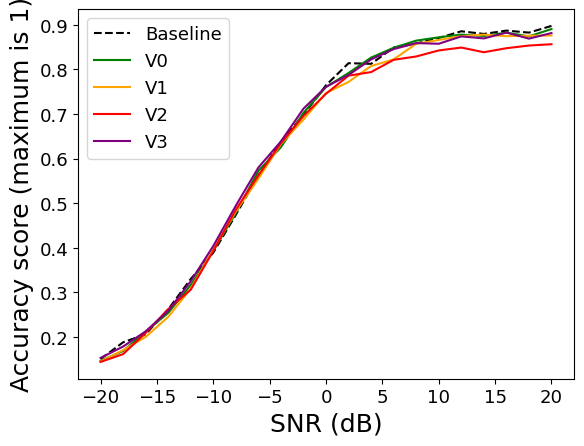

In [451]:
for i in range(len([0.35])):
    
    THRESHOLD = thresholds[i]
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(accuracies_test["Baseline"][0.05].values()), color = colors["baseline"], ls='--');
    plt.plot(xAxis, list(accuracies_test["V0"][THRESHOLD].values()), color = colors["V0"]);
    plt.plot(xAxis, list(accuracies_test["V1"][THRESHOLD].values()), color = colors["V1"]);
    plt.plot(xAxis, list(accuracies_test["V2"][THRESHOLD].values()), color = colors["V2"]);
    plt.plot(xAxis, list(accuracies_test["V3"][THRESHOLD].values()), color = colors["V3"]);
    plt.legend(["Baseline", "V0", "V1", "V2", "V3"], fontsize=13)
    plt.xlabel('SNR (dB)', fontsize=18)
    plt.ylabel('Accuracy score (maximum is 1)', fontsize=18)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
    plt.savefig('./TestFigures/035Results/accuracy_all_T035.png')
    plt.show()

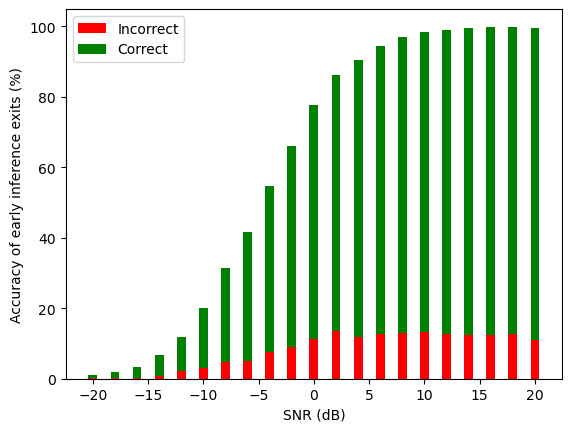

In [366]:
# Data
THRESHOLD = 0.35
Version = "V3"
figTitle = "./TestFigures/035Results/bar_{}_T{}"
percentages = list(inferenceCounter_test_035[Version][THRESHOLD][0].values())
correct = list(shortAccs_test_035[Version][THRESHOLD].values())
correct_percentage = [correct[i] * percentages[i] for i in range(len(percentages))]
incorrect_percentage = [percentages[i] - correct_percentage[i] for i in range(len(percentages))]


# Set the figure size
fig = plt.Figure(figsize=(8, 6))

# Create the plot
plt.bar(xAxis, incorrect_percentage, label='Incorrect', color='red')
plt.bar(xAxis, correct_percentage, label='Correct', bottom=incorrect_percentage, color='green')

# Add legend and labels
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy of early inference exits (%)')
plt.savefig(figTitle.format(Version, "035"))
plt.show()

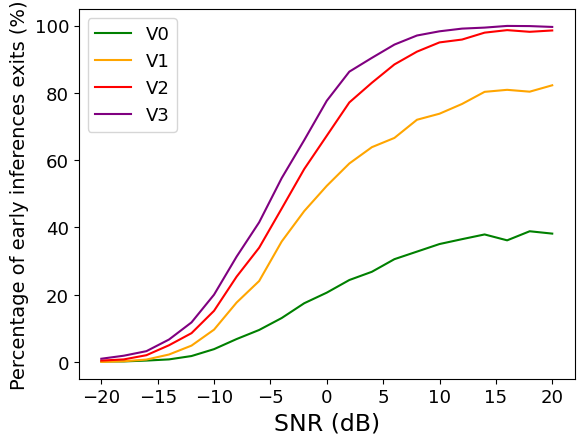

In [463]:
figTitle = './TestFigures/035Results/percent_T035.png'

for i, THRESHOLD in enumerate([0.35]):
    fig = plt.Figure()

    xAxis = np.arange(-20, 21, 2) #SNRs
    plt.plot(xAxis, list(inferenceCounter_test_035["V0"][THRESHOLD][0].values()), color = colors["V0"])
    plt.plot(xAxis, list(inferenceCounter_test_035["V1"][THRESHOLD][0].values()), color = colors["V1"])
    plt.plot(xAxis, list(inferenceCounter_test_035["V2"][THRESHOLD][0].values()), color = colors["V2"])
    plt.plot(xAxis, list(inferenceCounter_test_035["V3"][THRESHOLD][0].values()), color = colors["V3"])

    plt.legend(["V0","V1", "V2", "V3"],fontsize=13)
    plt.xlabel("SNR (dB)",fontsize=17)
    plt.ylabel('Percentage of early inferences exits (%)',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    # Save the figure as a PNG file
    plt.savefig(figTitle)
    plt.show()

In [361]:
inferenceCounter_test_035["V2"][0.35][0]

{'-20': 0.4,
 '-18': 0.75,
 '-16': 2.0,
 '-14': 4.95,
 '-12': 8.55,
 '-10': 15.2,
 '-8': 25.35,
 '-6': 33.95,
 '-4': 45.6,
 '-2': 57.35,
 '0': 67.25,
 '2': 77.14999999999999,
 '4': 83.0,
 '6': 88.44999999999999,
 '8': 92.25,
 '10': 95.0,
 '12': 95.85000000000001,
 '14': 97.89999999999999,
 '16': 98.65,
 '18': 98.15,
 '20': 98.55000000000001}

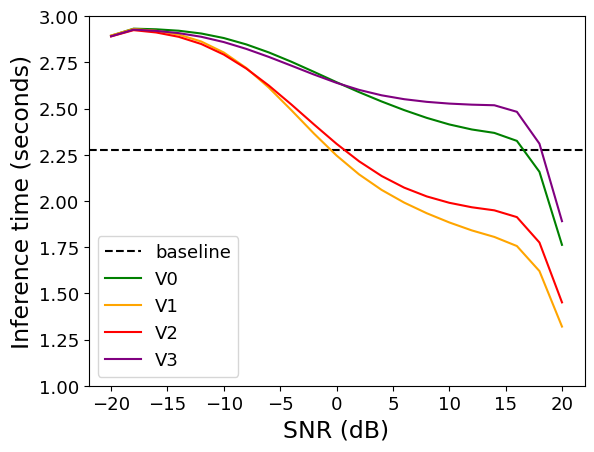

In [457]:
figTitle = './TestFigures/035Results/times_T{}.png'
thresholds_titles = ['001', '005', '015', '03', '035', '04', '06']
dbl_calc_time = 0.00020662546157836914
xAxis = np.arange(-20, 21, 2) #SNRs

finalTimes_test_035 = {x: {v:{snrV: 0 for snrV in stringSNRs} for v in ["V0", "V1", "V2", "V3"]} for x in [0.35]}
for i, THRESHOLD in enumerate([0.35]):
 
    for Version in ["V0", "V1", "V2", "V3"]:
        for snrV in stringSNRs:
            short_percentage = inferenceCounter_test_035[Version][THRESHOLD][0][snrV]
            long_percentage = inferenceCounter_test_035[Version][THRESHOLD][1][snrV]
            shortTime = int(short_percentage*2000/100)*Versions_times_test[Version]['short'] 

            longTime = int(long_percentage*2000/100)*(avg_longTime+dbl_calc_time)  
            #longTime += int(long_percentage*1800/100)*dbl_calc_time

            finalTimes_test_035[THRESHOLD][Version][snrV] = shortTime + longTime
    
    #fig = plt.Figure()
    fig, ax = plt.subplots()
    # Add the vertical line
    plt.axhline(y=bl_time_test, color=colors["baseline"], ls='--')
    
    # V0
    x, y_0 = smoothing(xAxis, list(finalTimes_test_035[THRESHOLD]['V0'].values()))
    plt.plot(xAxis, y_0[3:], color = colors["V0"])
    # V1
    x, y_1 = smoothing(xAxis, list(finalTimes_test_035[THRESHOLD]['V1'].values()))
    plt.plot(xAxis, y_1[3:], color = colors["V1"])
    # V2
    x, y_2 = smoothing(xAxis, list(finalTimes_test_035[THRESHOLD]['V2'].values()))
    plt.plot(xAxis, y_2[3:], color = colors["V2"])
    # V3
    x, y_3 = smoothing(xAxis, list(finalTimes_test_035[THRESHOLD]['V3'].values()))
    plt.plot(xAxis, y_3[3:], color = colors["V3"])

    

    plt.legend(["baseline", "V0", "V1", "V2", "V3"], fontsize=13)
    plt.xlabel("SNR (dB)", fontsize=17)
    plt.ylabel("Inference time (seconds)", fontsize=17)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim(1, 3)
    plt.show()
    fig.savefig(figTitle.format('035'))

In [345]:
y_1

array([1.46805406, 2.20680326, 2.69585793, 2.89497342, 2.93049031,
       2.92065001, 2.90004887, 2.86263741, 2.80314382, 2.71918901,
       2.61273923, 2.49073833, 2.36437377, 2.24585103, 2.14357962,
       2.05959061, 1.99100419, 1.93345402, 1.88363681, 1.84045246,
       1.80509871, 1.75587846, 1.62044223, 1.32011122])

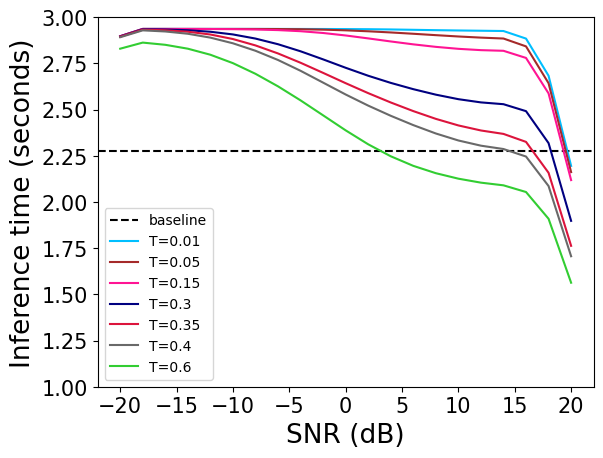

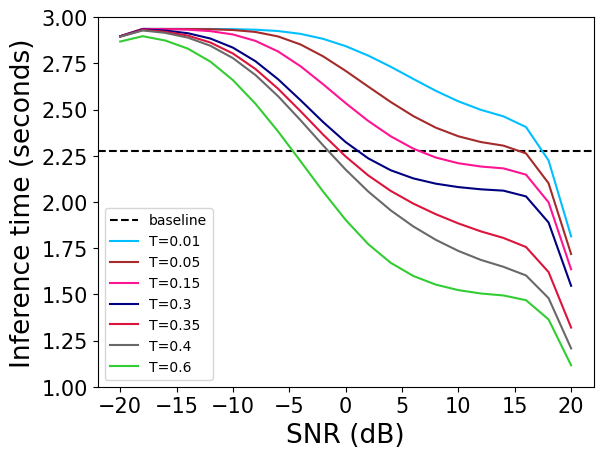

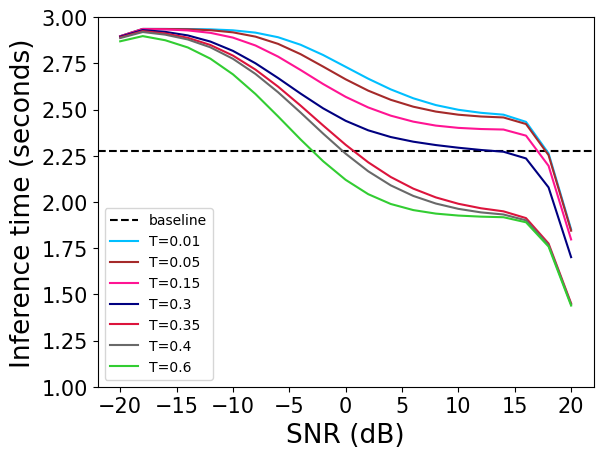

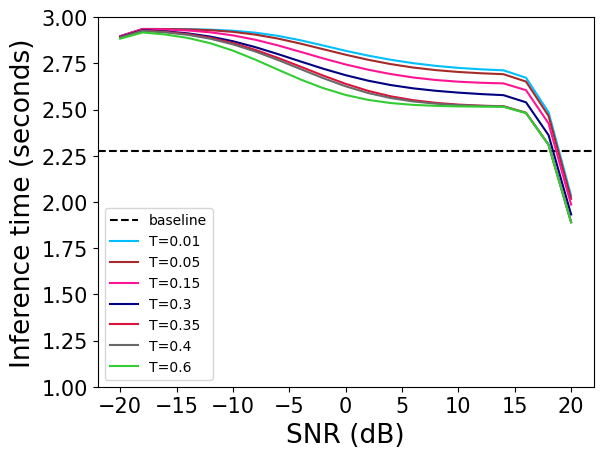

In [442]:
figTitle = './TestFigures/035Results/times_{}.png'
dbl_calc_time = 0.00020662546157836914
xAxis = np.arange(-20, 21, 2) #SNRs

finalTimes_test2_035 = {x: {THRESHOLD:{snrV: 0 for snrV in stringSNRs} for THRESHOLD in [0.35]} for x in ["V0", "V1", "V2", "V3"]}
for Version in ["V0", "V1", "V2", "V3"]:

    for i, THRESHOLD in enumerate([0.35]):
        for snrV in stringSNRs:
            short_percentage = inferenceCounter_test_035[Version][THRESHOLD][0][snrV]
            long_percentage = inferenceCounter_test_035[Version][THRESHOLD][1][snrV]

            shortTime = int(short_percentage*2000/100)*Versions_times_test[Version]['short'] 

            longTime = int(long_percentage*2000/100)*(avg_longTime+dbl_calc_time)  
            #longTime += long_percentage*len(valLoader)*dbl_calc_time

            finalTimes_test2_035[Version][THRESHOLD][snrV] = shortTime + longTime
    
    #fig = plt.Figure()
    fig, ax = plt.subplots()
    # Add the vertical line
    plt.axhline(y=bl_time_test, color='black', ls='--')
    
    # T=0.01
    x, y_0 = smoothing(xAxis, list(finalTimes_test2[Version][0.01].values()))
    plt.plot(xAxis, y_0[3:], color = colors[0.01])
    # T=0.05
    x, y_1 = smoothing(xAxis, list(finalTimes_test2[Version][0.05].values()))
    plt.plot(xAxis, y_1[3:], color = colors[0.05])
    # T = 0.15
    x, y_2 = smoothing(xAxis, list(finalTimes_test2[Version][0.15].values()))
    plt.plot(xAxis, y_2[3:], color = colors[0.15])
    # T = 0.3
    x, y_3 = smoothing(xAxis, list(finalTimes_test2[Version][0.3].values()))
    plt.plot(xAxis, y_3[3:], color = colors[0.3])
    
    # T = 0.35
    x, y_5 = smoothing(xAxis, list(finalTimes_test2_035[Version][0.35].values()))
    plt.plot(xAxis, y_5[3:], color = colors[0.35])
    
    
    # T = 0.4
    x, y_4 = smoothing(xAxis, list(finalTimes_test2[Version][0.4].values()))
    plt.plot(xAxis, y_4[3:], color = colors[0.4])
    # T = 0.6
    x, y_5 = smoothing(xAxis, list(finalTimes_test2[Version][0.6].values()))
    plt.plot(xAxis, y_5[3:], color = colors[0.6])
    
    
    
    
    plt.legend(["baseline", "T=0.01", "T=0.05", "T=0.15", "T=0.3", "T=0.35", "T=0.4", "T=0.6"], fontsize=10)
    plt.xlabel("SNR (dB)", fontsize=19)
    plt.ylabel("Inference time (seconds)",fontsize=19)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.ylim(1, 3)
    plt.show()
    fig.savefig(figTitle.format(Version))

In [334]:
SNR, THRE = "20", 0.35
BL_acc = accuracies_test["Baseline"][0.05][SNR]

V0_acc = accuracies_test_035["V0"][THRE][SNR]
print("V0: {:.03f}".format(100*(BL_acc-V0_acc)))
V1_acc = accuracies_test_035["V1"][THRE][SNR]
print("V1: {:.03f}".format(100*(BL_acc-V1_acc)))
V2_acc = accuracies_test_035["V2"][THRE][SNR]
print("V2: {:.03f}".format(100*(BL_acc-V2_acc)))
V3_acc = accuracies_test_035["V3"][THRE][SNR]
print("V3: {:.03f}".format(100*(BL_acc-V3_acc)))
print("time")
for Version in ["V0", "V1", "V2", "V3"]:
    time = finalTimes_test_035[THRE][Version][SNR]
    Ratio = (bl_time_test-time)/bl_time_test*100
    print("{}: {:.03f}".format(Version, Ratio))
    #print("{}: {:.03f}".format(Version, (bl_time_test-time)))

V0: 6.000
V1: 5.150
V2: 8.600
V3: 0.850
time
V0: -2.838
V1: 23.621
V2: 15.270
V3: -10.512


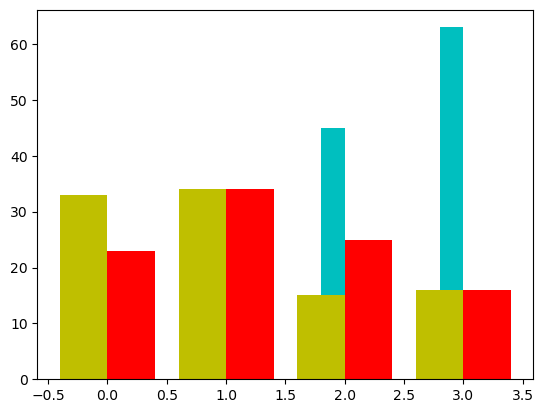

In [374]:
import pandas as pd

df = pd.DataFrame(dict(
x1 = [3,4,5,6],
x2 = [13,24,45,63],
x3 = [23,34,25,16],
x4 = [33,34,15,16],
))

plt.bar([0, 1, 2,3], df.x1, align='edge', width=0.4, color='g')
plt.bar([0, 1, 2,3], df.x2, align='edge', width=-0.2, color='c')
plt.bar([0, 1, 2,3], df.x3, align='edge', width=0.4, color='r')
plt.bar([0, 1, 2,3], df.x4, align='edge', width=-0.4, color='y')

plt.show()

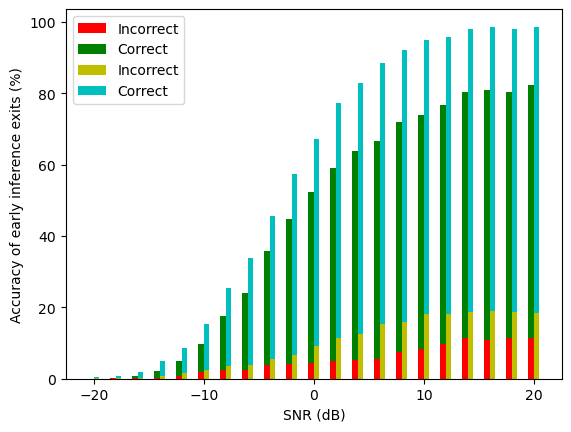

In [392]:
# Data
THRESHOLD = 0.35
figTitle = "./TestFigures/035Results/bar_stacked_T{}"
percentages_V1 = list(inferenceCounter_test_035["V1"][THRESHOLD][0].values())
correct_V1 = list(shortAccs_test_035["V1"][THRESHOLD].values())
correct_percentage_V1 = [correct_V1[i] * percentages_V1[i] for i in range(len(percentages_V1))]
incorrect_percentage_V1 = [percentages_V1[i] - correct_percentage_V1[i] for i in range(len(percentages_V1))]

percentages_V2 = list(inferenceCounter_test_035["V2"][THRESHOLD][0].values())
correct_V2 = list(shortAccs_test_035["V2"][THRESHOLD].values())
correct_percentage_V2 = [correct_V2[i] * percentages_V2[i] for i in range(len(percentages_V2))]
incorrect_percentage_V2 = [percentages_V2[i] - correct_percentage_V2[i] for i in range(len(percentages_V2))]


# Set the figure size
#fig = plt.Figure(figsize=(100, 100))

# Create the plot
plt.bar(xAxis, incorrect_percentage_V1, label='Incorrect', color='red', align='edge', width=-0.5)
plt.bar(xAxis, correct_percentage_V1, label='Correct', bottom=incorrect_percentage_V1, color='green',align='edge', width=-0.5)

plt.bar(xAxis, incorrect_percentage_V2, label='Incorrect', color='y', align='edge', width=0.5)
plt.bar(xAxis, correct_percentage_V2, label='Correct', bottom=incorrect_percentage_V2, color='c',align='edge', width=0.5)

# Add legend and labels
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy of early inference exits (%)')
plt.savefig(figTitle.format(Version, "035"))
plt.show()

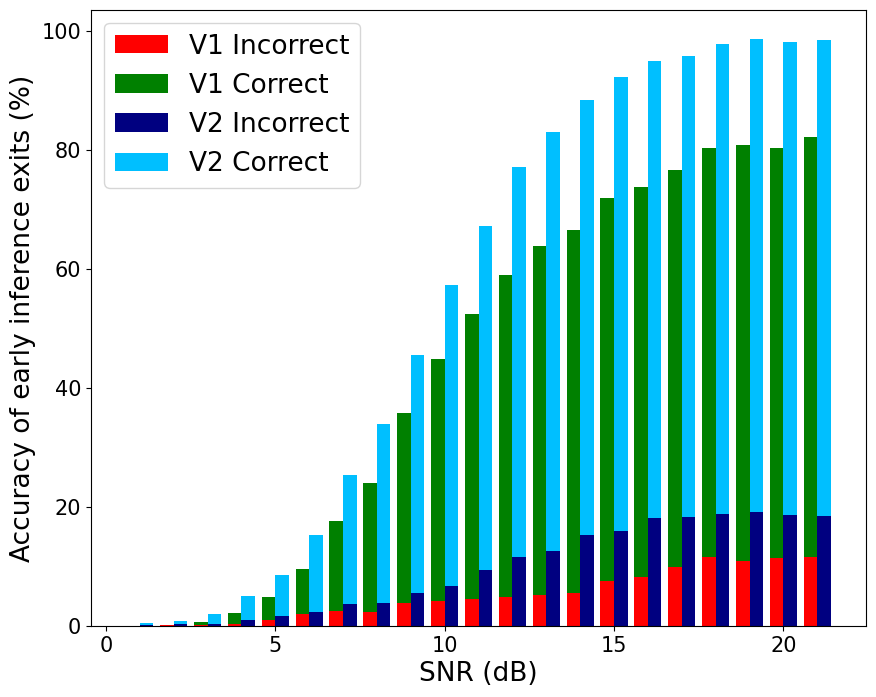

In [438]:
import matplotlib.pyplot as plt

# Data
THRESHOLD = 0.35
figTitle = "./TestFigures/035Results/bar_stacked_T{}"
percentages_V1 = list(inferenceCounter_test_035["V1"][THRESHOLD][0].values())
correct_V1 = list(shortAccs_test_035["V1"][THRESHOLD].values())
correct_percentage_V1 = [correct_V1[i] * percentages_V1[i] for i in range(len(percentages_V1))]
incorrect_percentage_V1 = [percentages_V1[i] - correct_percentage_V1[i] for i in range(len(percentages_V1))]

percentages_V2 = list(inferenceCounter_test_035["V2"][THRESHOLD][0].values())
correct_V2 = list(shortAccs_test_035["V2"][THRESHOLD].values())
correct_percentage_V2 = [correct_V2[i] * percentages_V2[i] for i in range(len(percentages_V2))]
incorrect_percentage_V2 = [percentages_V2[i] - correct_percentage_V2[i] for i in range(len(percentages_V2))]

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Create the plot
xAxis = [i+1 for i in range(len(correct_percentage_V1))]
ax.bar(xAxis, incorrect_percentage_V1, label='V1 Incorrect', color='red', align='edge', width=-0.4)
ax.bar(xAxis, correct_percentage_V1, label='V1 Correct', bottom=incorrect_percentage_V1, color='green',align='edge', width=-0.4)

ax.bar(xAxis, incorrect_percentage_V2, label='V2 Incorrect', color='navy', align='edge', width=0.4)
ax.bar(xAxis, correct_percentage_V2, label='V2 Correct', bottom=incorrect_percentage_V2, color='deepskyblue',align='edge', width=0.4)

# Add legend and labels
plt.legend(fontsize=19)
plt.xlabel('SNR (dB)', fontsize=19)
plt.ylabel('Accuracy of early inference exits (%)', fontsize=19)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(figTitle.format("035"))
plt.show()
